# Inference Pipeline

In [1]:
from abc import ABC, abstractmethod

import os
from tqdm import tqdm
import math 
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats
from scipy.special import digamma

import torch
from torch.distributions import Beta
from torch.distributions.bernoulli import Bernoulli
from torch.nn.functional import log_softmax
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset

from bayes_opt import BayesianOptimization

In [2]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

## Generation

In [10]:
### these params control the generation scheme (2/10 generation)
rho        = 0.8    # polarization
pop_size   = 500000 # num individuals
epsilon    = 0.05   # expected prop of speech consisting of neutral words
pi         = 0.5    # pi == 0.5 => beta mixture symmetrical (choose beta1 with prob pi = 0.5)
speech_len = 30     # words per speech

In [11]:
def generate(rho=rho, N=pop_size, epsilon=epsilon, pi=pi, speech_len=speech_len, verbose='low'):
    """
    Uses 2/10 generation scheme to generate N samples.

    Returns:
        (X, y), (a, b, rho, epsilon, u)
        X.size() == [N, 3] is a vector of word counts
        y.size() == [N] is a vector of political parties
        u.shape  == (N,) is a vector of individual stances
        rho is true polarization
        epsilon is expected prop of neutral words
        a, b are true alpha/beta for beta mixture model
    """
    start = time.time()
    if verbose in ['mid', 'high']:
        print(f'Beginning Data Generation...')
        print(f'=' * 20)
        
    ### get beta mixture model params 
    sigma = 0.175 * (rho ** 2) - 0.3625 * rho + 0.1875
    a     = rho * ((rho * (1 - rho)) / sigma - 1)
    b     = (1 - rho) * ((rho * (1 - rho)) / sigma - 1)

    if verbose in ['mid', 'high']:
        print(f"True Alpha: {a}")
        print(f"True Beta: {b}")
        print(f"True Epsilon: {epsilon}\n")

    mean = a / (a + b)
    var  = a * b / ((a + b)**2 * (a + b + 1))

    if abs(mean - rho) > 10e-15:
        print(f'Mean: {mean}')
        print(f"Rho: {rho}")
        raise AssertionError(f"Mean of BMM params should be rho")

    if abs(var - sigma) > 10e-15:
        print(f'Var: {var}')
        print(f'Sigma: {sigma}')
        raise AssertionError(f"Var of BMM params should be sigma")

    ### u ~ pi Beta(a, b) + (1 - pi) Beta(b, a)
    weights = [pi, 1-pi]
    mixture_samples = np.random.choice([0, 1], size=N, p=weights)

    u = 2 * np.where(mixture_samples == 1, stats.beta.rvs(a, b, size=N), stats.beta.rvs(b, a, size=N)) - 1

    if u.shape != (N,):
        raise AssertionError(f"u.shape should be (N,)")

    if verbose == 'high':
        print(f'mixture samples: {mixture_samples[:5]}')
        print(f'u samples: {u[:5]}\n')

    ### y = 1(u >= 0)
    y = (u >= 0).astype(int)

    if verbose == 'high':
        print(f'y samples: {y[:5]}\n')

    ### phi is a prob matrix that is a function of u, epsilon
    phi = np.array([(1 - (u+1)/2) * (1 - epsilon), (u+1)/2 * (1 - epsilon), np.repeat(epsilon, N)]).T
    
    if verbose == 'high':
        print(f'phi samples:\n {phi[:5, :]}\n')

    if phi.shape != (N, 3):
        raise AssertionError(f'phi.shape should be (N, V) == (N, 3)')

    if abs(sum(phi[0]) - 1) > 10e-5:
        raise AssertionError(f'rows of phi should sum to 1')
    
    X = np.array([stats.multinomial.rvs(n=speech_len, p=phi[i, :]) for i in range(N)])

    if verbose == 'high':
        print(f'X samples:\n {X[:5, :]}\n')
    
    if X.shape != (N, 3):
        raise AssertionError(f'X.shape should be (N, V) == (N, 3)')

    if X[:5].sum() != speech_len * 5:
        raise AssertionError(f'rows of phi should sum to 1')

    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.float32)

    known   = (X, y)
    unknown = (a, b, rho, epsilon, u)

    if verbose in ['mid', 'high']:
        print('=' * 20)
        print(f'Generation Time: {round(time.time() - start, 3)} seconds for {N} samples.')

    return known, unknown

known, unknown = generate(verbose='high')
X, y = known
a, b, rho, epsilon, u = unknown

Beginning Data Generation...
True Alpha: 12.673684210526261
True Beta: 3.1684210526315644
True Epsilon: 0.05

mixture samples: [0 0 1 1 0]
u samples: [-0.68046765 -0.82279682  0.71297122  0.23662272 -0.30125793]

y samples: [0 0 1 1 0]

phi samples:
 [[0.79822213 0.15177787 0.05      ]
 [0.86582849 0.08417151 0.05      ]
 [0.13633867 0.81366133 0.05      ]
 [0.36260421 0.58739579 0.05      ]
 [0.61809752 0.33190248 0.05      ]]

X samples:
 [[25  4  1]
 [24  2  4]
 [ 2 27  1]
 [13 17  0]
 [22  7  1]]

Generation Time: 10.02 seconds for 500000 samples.


## Generation Visualization

### Variance

Here we show we're assuming some sort of inductive bias on the variance of the beta mixture models. In other words, we're assuming they look nice (bimodal/not super low variance)

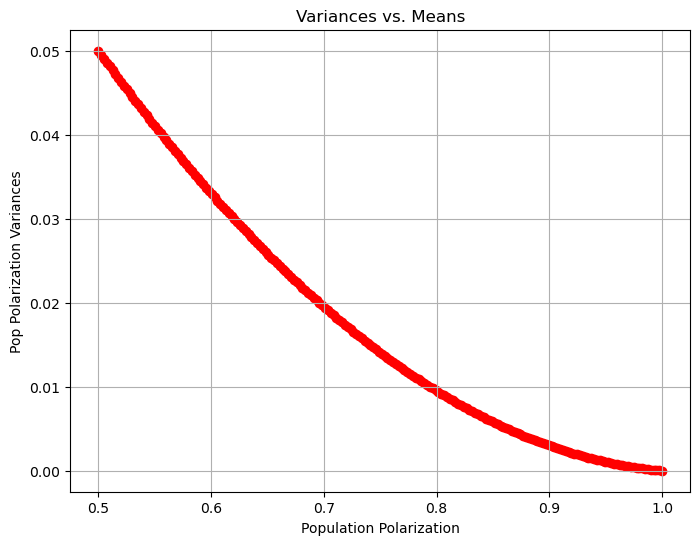

In [5]:
rhos   = np.linspace(0.5, 1, 200)
sigmas = 0.175 * (rhos ** 2) - 0.3625 * rhos + 0.1875

plt.figure(figsize=(8, 6))
plt.scatter(rhos, sigmas, color='r')
plt.grid(True)
plt.title(r"Variances vs. Means")
plt.xlabel("Population Polarization")
plt.ylabel("Pop Polarization Variances")
plt.show()

### Stance Distribution 

Here we show $\rho$ effectively parameterizes our beta mixture model. Important Note: why does inferring $\rho$ not make sense. Well, the plots below intuitively tell us increasing $\rho$ increasing polarization/bimodal-ness, but we cannot quantify this because in fact a single number cannot parameterize such a distribution (perhaps $\rho$ and $\sigma$ could though... meaning it would suffice to only infer these if you were able to make really strong assumptions about the distribution of $u$).

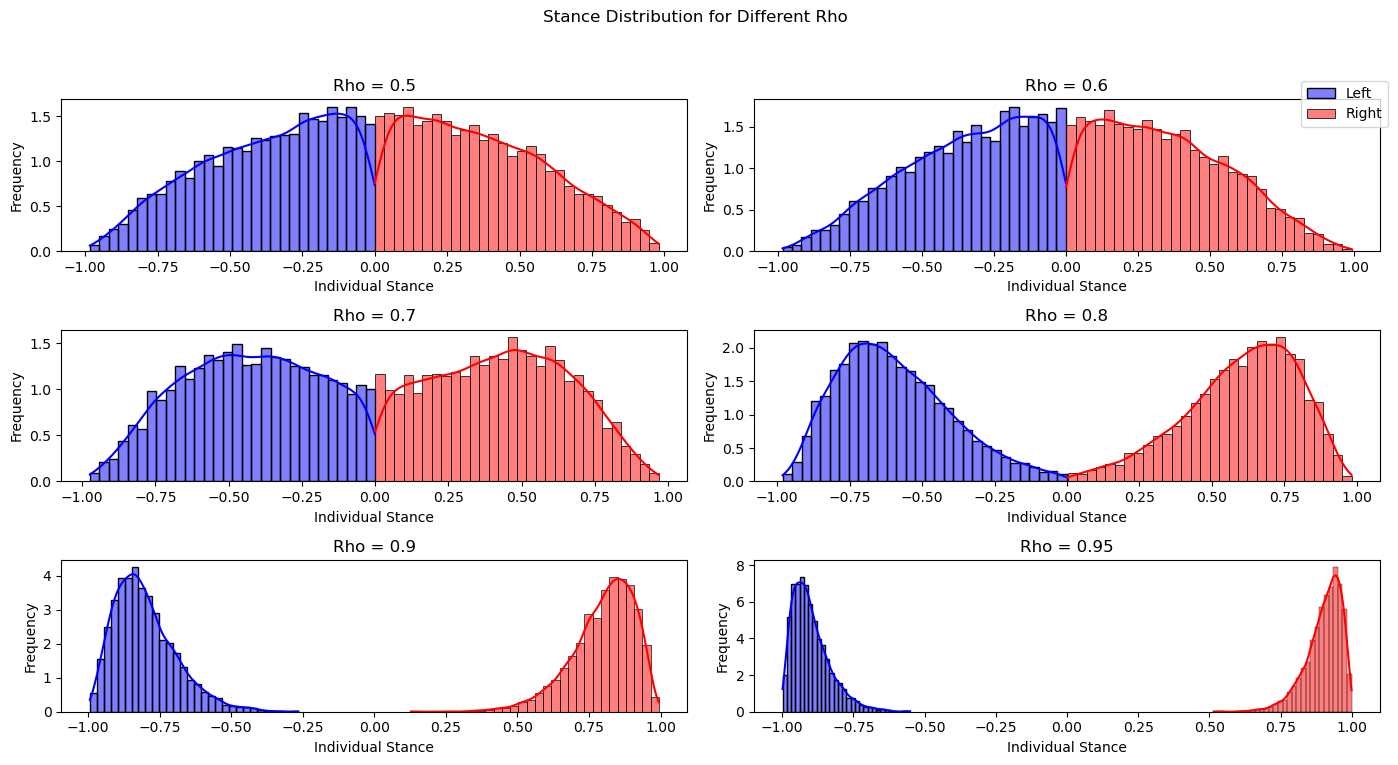

In [6]:
rhos = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

plt.figure(figsize=(14, 8))
plt.suptitle("Stance Distribution for Different Rho")

for i, rho in enumerate(rhos):
    plt.subplot(3, 2, i+1)
    known, unknown = generate(rho=rho, N=10000)
    X, y = known
    a, b, rho, epsilon, u = unknown
    sns.histplot(u[y==0], color='blue', kde=True, stat="density", bins=30, alpha=0.5, label='Left' if i==0 else "")
    sns.histplot(u[y==1], color='red', kde=True, stat="density", bins=30, alpha=0.5, label='Right' if i==0 else "")
    plt.title(f'Rho = {rho}')
    plt.xlabel('Individual Stance')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.figlegend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.show()

## Inference

The goal of inference is to recover $u$ given a sample of $(x,y)$ pairs. We assume the following data generating process:
$$
\begin{align*}
    u &\sim 2 \cdot \left(\pi\cdot\mathrm{Beta}\left(u;\alpha,\beta\right)+(1-\pi)\cdot\mathrm{Beta}\left(u;\beta,\alpha\right)\right)-1 \\
    y &= 1(u \ge \lambda) \\
    x &\sim \mathrm{Multinomial}\left(S, \mathrm{Softmax}(Wu)\right), W \in \R^V.
\end{align*}
$$
For now, we assume $\lambda = 0, V = 3, \pi = 0.5$, so our parameters are $\theta = \{\alpha, \beta, W\}$. Given we assume this full form of $u$ parameterized by $\alpha, \beta$, recovering the distribution of $u$ is equivalent to recovering $\alpha, \beta$. Using our probabilistic graph and the assumed DGP, we get the following joint:
$$
\begin{align*}

p(u,x^{(n)},y^{(n)};\theta) &= p(u)p(y^{(n)}|u)\prod_{s=1}^{S}p(x^{(n)}_s | u) \\
&= \left(\frac{1}{4}\mathrm{Beta}\left(\frac{u+1}{2};\alpha,\beta\right)+\frac{1}{4}\mathrm{Beta}\left(\frac{u+1}{2};\beta,\alpha\right)\right) \\&\cdot 1\left(1(u\ge0)=y^{(n)}\right)\frac{S!}{x^{(n)}_1!x^{(n)}_2!x^{(n)}_3!}\prod_{s=1}^{S}\mathrm{softmax}(Wu)_{x^{(n)}_s}

\end{align*}
$$
Here, we can get the density of $u$ by noting $u$ is a monotonic transform of a random variable whose density is known. Thus, applying a formula found [here](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function) we get the above expression.

The basic idea is to maximize the log marginal likelihood. Let $\theta = \{\alpha, \beta, W\}$. We'd like to find 
$$
\theta^* = \argmax_{\theta} \underbrace{\log p(x^{(1:N)}, y^{(1:N)}; \theta)}_{\mathcal{L}(\theta)}. 
$$


The goal is to recover $\alpha, \beta$ (hence $u$ given we are assuming $u \sim 2\left(\frac{1}{2} \cdot \mathrm{Beta}(\alpha, \beta) + \frac{1}{2} \cdot \mathrm{Beta}(\beta, \alpha)\right) - 1$ given $(x,y)$ pairs.

We cannot directly compute this argmax. So, to get MLE estimates for alpha, beta, W, we will take gradient descent steps on the log marginal likelihood. Its gradient is given by the following expression:
$$
\nabla_\theta \log p(x^{(1:N)},y^{(1:N)}) = \sum_{n=1}^{N} \mathbb{E}_{p(u|x^{(n)},y^{(n)};\theta)}[\nabla_\theta \log p(u,x^{(n)},y^{(n)};\theta)].
$$
There are a number of issues here, beginning with the fact that we cannot analytically recover the posterior due to the integral being intractable. However, since $u \in [-1,1]$, we can discretize the integral, which will be simpler than something like MCMC for sampling/using variational inference to approximate the posterior. To do this, let's write the definition of the expectation:
$$
\nabla_\theta \log p(x^{(1:N)},y^{(1:N)}) = \sum_{n=1}^{N} \int_{-1}^{1} \frac{p(x^{(n)}, y^{(n)}, u;\ \theta)}{p(x^{(n)},y^{(n)};\  \theta)}\nabla_\theta \log p(u,x^{(n)},y^{(n)};\theta) \mathrm{d}u
$$
Now, we could assume $u$ takes on $G$ linearly spaced points in $[-1,1]$. One way to do this is to essentially keep track of a hashmap $u \mapsto p(u, x^{(n)}, y^{(n)})$: 
$$
\text{Example:}\  \{u = -.99 : 0.03, \dots, u = .99 : 0.007\}.
$$
The sum of the values of this hashmap, by the law of total probability, is $p(x^{(n)}, y^{(n)})$. So, the posterior can be obtained by normalizing the values of the hashmap by the sum of the values. However, we can do better. Notice that when $y^{(n)} \ne 1(u \ge 0)$, $p(u, x^{(n)}, y^{(n)})$ is necessarily $0$. In other words, half of the entries of our discrete distribution will be $0$ in a very predictable way. Thus, we can just ignore these values and use $y^{(n)}$ as a condition. 

If $y^{(n)} = 1$, have $u$ take on $G$ linearly spaced points in $[0,1]$, and if $y^{(n)} = 0$ do $[-1,0]$. This is what we do in practice. Theoretically, we're still computing:
$$
\nabla_\theta \log p(x^{(1:N)},y^{(1:N)}) = \sum_{n=1}^{N} \sum_{u} \frac{p(x^{(n)}, y^{(n)}, u;\ \theta)}{p(x^{(n)},y^{(n)};\  \theta)}\nabla_\theta \log p(u,x^{(n)},y^{(n)};\theta).
$$
It's convenient to move the gradient outside the sum, since then we can efficiently compute the double sum via matrices and then just sum the matrix/call .backward(). This is what I was doing initially, but it's definitely wrong, since the posterior relies on theta. To fix this, I call .detach() on the "weight" (posterior probability), which means the gradients only flow through the joint log probability (which is what we want).

In [7]:
grid_size  = 200 ### discretize integral into grid_size linearly spaced pts
batch_size = 100 ### num samples processed simultaneously
num_epochs = 200 ### number epochs
lr         = 0.1 ### learning rate

def compute_nll(x_batch, y_batch, log_alpha, log_beta, W):
    """
    Parameters:
        (x_batch, y_batch) a batch of B (x,y) samples 
        (log_alpha, log_beta, W) trainable parameters

    Returns:
        A scaler quantity s.t. calling .backward() will compute
        grad_{theta} (L(theta))
    """
    raise NotImplementedError

def train(X, y, log_alpha=None, log_beta=None, W=None, num_epochs=num_epochs, batch_size=batch_size, grid_size=grid_size, lr=lr, verbose=True, threshold=0.00001, patience=5, speech_len=speech_len):
    if verbose:
        print(f'Beginning Inference...')
        print(f'=' * 20)
        print(f'Hyperparameters:')
        print(f'Dataset Length: {len(X)}')
        print(f'Number Epochs: {num_epochs}')
        print(f'Batch Size: {batch_size}')
        print(f'Grid Size: {grid_size}')
        print(f"Learning Rate: {lr}")
        print(f"Improvement Threshold: {threshold}")
        print(f"Patience: {patience}")
        print(f'Speech Len: {speech_len}')
        print('=' * 20)

    ### not strictly necessary 
    assert len(X) % batch_size == 0
    
    start = time.time()

    dataset    = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    X_batch, y_batch = list(dataloader)[0]

    if list(X_batch.size()) != [batch_size, 3]:
        raise AssertionError(f"X_ex.size() should be [batch_size, V] == [batch_size, 3], got {X_batch.size()}")

    if list(y_batch.size()) != [batch_size]:
        raise AssertionError(f"y_ex.size() should be [batch_size], got {y_batch.size()}")

    if log_alpha is None:
        log_alpha = torch.normal(0, math.sqrt(3), size=(1,), requires_grad=True)

    if log_beta is None:
        log_beta  = torch.normal(0, math.sqrt(3), size=(1,), requires_grad=True)

    if W is None:
        W = torch.normal(0, 1, size=(3,), requires_grad=True)

    print(f'Initial Parameters:')
    print(f'Alpha: {torch.exp(log_alpha).item()}')
    print(f"Beta: {torch.exp(log_beta).item()}")
    print(f"W: {W.data.tolist()}")

    optimizer = SGD([log_alpha, log_beta, W], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    # Early stopping logic
    best_nll = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(num_epochs)):
        if verbose:
            print(f'Epoch {epoch+1} of {num_epochs}')
        ### only step after each epoch
        optimizer.zero_grad() 
        nll = torch.tensor(0.)
        
        for x_batch, y_batch in dataloader:
            nll += compute_nll(x_batch, y_batch, log_alpha, log_beta, W, grid_size, batch_size, speech_len)
        
        nll = nll / len(dataloader.dataset)
        nll.backward()
        print('=' * 20)
        print(f'Log Alpha Grad: {log_alpha.grad}')
        print(f'Log Beta Grad: {log_beta.grad}')
        print(f'W Grad: {W.grad}')
        print('=' * 20)
        optimizer.step()
        scheduler.step()

        current_nll = nll.item()
        if current_nll < best_nll - threshold:
            best_nll = current_nll
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if verbose:
            print(f'Epoch {epoch+1}, NLL: {round(nll.item(), 3)}, Alpha: {round(np.exp(log_alpha.item()),3)}, Beta: {round(np.exp(log_beta.item()),3)}, W: {W.tolist()}')
            print('=' * 20)

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    final_alpha = np.exp(log_alpha.item())
    final_beta  = np.exp(log_beta.item())

    if verbose:
        print(f"Training Took {round(time.time() - start, 2)} Seconds.")
        
    print(f"Trained Params: alpha: {final_alpha}, beta: {final_beta}, W: {W.tolist()}")

    return best_nll, final_alpha, final_beta, W

In [8]:
### numerically stable factorial
factorial = lambda x : torch.exp(torch.lgamma(x+1))

assert factorial(torch.tensor(3.)) == torch.tensor(6.)
print(f"3.0001! = {factorial(torch.tensor(3.001)).item()}")

### notice this is infinity, so we can't call factorial on negative stuff
print(f"-1! = {factorial(torch.tensor(-1.)).item()}")

def compute_log_joint(u_mat, x_batch, y_batch, log_alpha, log_beta, W, grid_size, batch_size, speech_len):
    """
    Parameters:
        x_batch (size [batch_size, 3])
        y_batch (size [batch_size])
        u_mat   (size [batch_size, grid_size])
        (log_alpha, log_beta, W) trainable params 
    
    Returns:
        torch.tensor (size [batch_size, grid_size]), where the (i,j)th element 
        is the log joint probability (log p(u, x, y; theta)). Here u is the (i,j)th
        element of u_mat, x is the ith row of x_batch, y is the ith element of y_batch

    """
    assert list(u_mat.size())   == [batch_size, grid_size] 
    assert list(x_batch.size()) == [batch_size, 3]
    assert list(y_batch.size()) == [batch_size]

    if not torch.all((u_mat >= 0).float() == y_batch.unsqueeze(1)).item():
        raise ValueError(f"u_mat is incompatible with y_batch.")

    ### log prior: log p(u) = log(1/4 Beta((u+1)/2; a, b) + 1/4 Beta((u+1)/2; b, a))
    ###                     = log(1/4) + log(Beta((u+1)/2; a, b) + Beta((u+1)/2; b, a))
    alpha = torch.exp(log_alpha)
    beta  = torch.exp(log_beta)
        
    beta_dist_ab = Beta(alpha, beta)
    beta_dist_ba = Beta(beta, alpha)

    ### see 3-6 testing.ipynb test1 to see how log_prob broadcasts
    log_beta_prob_ab = beta_dist_ab.log_prob((u_mat + 1) / 2)
    log_beta_prob_ba = beta_dist_ba.log_prob((u_mat + 1) / 2)

    prior = torch.log(torch.exp(log_beta_prob_ab) + torch.exp(log_beta_prob_ba)) + torch.log(torch.tensor(0.25))

    assert list(prior.size()) == [batch_size, grid_size]
  
    ### log likelihood: log p(x, y | u) = dot(x, log Softmax(Wu)) + log(S!/(x1! x2! x3!)) 

    ### step 1: compute Wu (see 3-6 testing.ipynb test2 to see this logic)
    W_expanded = W.unsqueeze(0).unsqueeze(0)
    u_expanded = u_mat.unsqueeze(2)
    Wu = torch.matmul(u_expanded, W_expanded) 

    assert list(W_expanded.size()) == [1,1,3]
    assert list(u_expanded.size()) == [batch_size, grid_size, 1]
    assert list(Wu.size()) == [batch_size, grid_size, 3]

    ### step 2: dot(x, log Softmax(Wu)) (see 3-6 testing.ipynb test3 to see this logic)
    likelihood = (x_batch.unsqueeze(1) * log_softmax(Wu, dim=2)).sum(dim=2)

    ### ensure not taking negative factorials
    assert torch.all(x_batch >= 0)

    ### step 3: multinomial constant factors (see 3-6 testing.ipynb test4)
    likelihood += torch.log(factorial(torch.tensor(speech_len)))
    likelihood -= torch.log(factorial(x_batch)).sum(dim=1, keepdim=True) 

    assert list(likelihood.size()) == [batch_size, grid_size]
    return prior + likelihood


def compute_nll(x_batch, y_batch, log_alpha, log_beta, W, grid_size, batch_size, speech_len):
    """
    Parameters:
        x_batch (size [batch_size, 3])
        y_batch (size [batch_size])
        log_alpha, log_beta, W (trainable params)
        grid_size (int) number of lin spaced points to discretize integral into
    
    Returns:
        quantity s.t. .backward() would be the gradient of the nll
    """
    ### see 3-6 testing.ipynb test5 to see this logic
    u_mat = torch.empty(batch_size, grid_size)
    u_mat[y_batch == 1] = torch.linspace(1/(grid_size+1), 1-1/(grid_size+1), grid_size).repeat((y_batch == 1).sum(), 1)
    u_mat[y_batch == 0] = torch.linspace(-1+1/(grid_size+1), -1/(grid_size+1), grid_size).repeat((y_batch == 0).sum(), 1)

    assert list(u_mat.size()) == [batch_size, grid_size]

    log_joint = compute_log_joint(u_mat, x_batch, y_batch, log_alpha, log_beta, W, grid_size, batch_size, speech_len)
    assert list(log_joint.size()) == [batch_size, grid_size]

    ### see 3-6 testing.ipynb test6 to see this logic
    max_log_prob = torch.max(log_joint, dim=1, keepdim=True)[0]
    joint_probs = torch.exp(log_joint - max_log_prob)
    posterior = joint_probs / joint_probs.sum(dim=1, keepdim=True) 
    # detach posterior (see 3-6 testing.ipynb test7 to verify this works)
    weighted_log_joint = posterior.detach() * log_joint
    nll = -weighted_log_joint.sum()

    return nll

3.0001! = 6.007541656494141
-1! = inf


In [9]:
known, unknown = generate(rho=0.7, N=10000, verbose='high', speech_len=15)
X, y = known 
a, b, rho, epsilon, u = unknown 

best_nll, final_alpha, final_beta, W = train(X, y, patience=100, grid_size=10000, num_epochs=200, lr=.2, speech_len=15)

Beginning Data Generation...
True Alpha: 6.838461538461533
True Beta: 2.930769230769229
True Epsilon: 0.05

mixture samples: [0 1 1 0 1]
u samples: [-0.491914   -0.27538088  0.67492056 -0.22754946  0.33340672]

y samples: [0 0 1 0 1]

phi samples:
 [[0.70865915 0.24134085 0.05      ]
 [0.60580592 0.34419408 0.05      ]
 [0.15441273 0.79558727 0.05      ]
 [0.58308599 0.36691401 0.05      ]
 [0.31663181 0.63336819 0.05      ]]

X samples:
 [[13  2  0]
 [ 7  8  0]
 [ 4 11  0]
 [ 8  7  0]
 [ 7  6  2]]

Generation Time: 0.205 seconds for 10000 samples.
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 100
Grid Size: 10000
Learning Rate: 0.2
Improvement Threshold: 1e-05
Patience: 100
Speech Len: 15
Initial Parameters:
Alpha: 1.2231886386871338
Beta: 3.4880120754241943
W: [0.5635511875152588, 1.1430565118789673, 0.8590086102485657]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 200


  0%|          | 1/200 [00:03<13:10,  3.97s/it]

Log Alpha Grad: tensor([0.3724])
Log Beta Grad: tensor([-0.2466])
W Grad: tensor([ 1.4428, -1.4803,  0.0375])
Epoch 1, NLL: 8.092, Alpha: 1.135, Beta: 3.664, W: [0.2749992907047272, 1.4391072988510132, 0.8515095710754395]
Epoch 2 of 200


  1%|          | 2/200 [00:10<18:08,  5.50s/it]

Log Alpha Grad: tensor([0.3885])
Log Beta Grad: tensor([-0.2479])
W Grad: tensor([ 0.9319, -0.9606,  0.0287])
Epoch 2, NLL: 7.171, Alpha: 1.051, Beta: 3.851, W: [0.08862483501434326, 1.6312288045883179, 0.8457625508308411]
Epoch 3 of 200


  2%|▏         | 3/200 [00:13<14:23,  4.38s/it]

Log Alpha Grad: tensor([0.2591])
Log Beta Grad: tensor([-0.1542])
W Grad: tensor([ 0.5819, -0.5988,  0.0169])
Epoch 3, NLL: 6.766, Alpha: 0.997, Beta: 3.971, W: [-0.0277553703635931, 1.7509833574295044, 0.842388391494751]
Epoch 4 of 200


  2%|▏         | 4/200 [00:16<12:41,  3.88s/it]

Log Alpha Grad: tensor([0.1514])
Log Beta Grad: tensor([-0.0713])
W Grad: tensor([ 0.3853, -0.3945,  0.0092])
Epoch 4, NLL: 6.6, Alpha: 0.968, Beta: 4.028, W: [-0.1048143282532692, 1.8298879861831665, 0.8405429720878601]
Epoch 5 of 200


  2%|▎         | 5/200 [00:21<13:29,  4.15s/it]

Log Alpha Grad: tensor([0.0787])
Log Beta Grad: tensor([-0.0126])
W Grad: tensor([ 0.2715, -0.2765,  0.0050])
Epoch 5, NLL: 6.527, Alpha: 0.953, Beta: 4.038, W: [-0.1591113805770874, 1.8851807117462158, 0.8395477533340454]
Epoch 6 of 200


  3%|▎         | 6/200 [00:27<15:07,  4.68s/it]

Log Alpha Grad: tensor([0.0315])
Log Beta Grad: tensor([0.0262])
W Grad: tensor([ 0.2024, -0.2051,  0.0027])
Epoch 6, NLL: 6.492, Alpha: 0.947, Beta: 4.017, W: [-0.1995929628610611, 1.9261999130249023, 0.83901047706604]
Epoch 7 of 200


  4%|▎         | 7/200 [00:29<13:05,  4.07s/it]

Log Alpha Grad: tensor([0.0012])
Log Beta Grad: tensor([0.0509])
W Grad: tensor([ 0.1588, -0.1603,  0.0015])
Epoch 7, NLL: 6.475, Alpha: 0.946, Beta: 3.977, W: [-0.23135316371917725, 1.9582524299621582, 0.8387182950973511]
Epoch 8 of 200


  4%|▍         | 8/200 [00:32<11:53,  3.72s/it]

Log Alpha Grad: tensor([-0.0182])
Log Beta Grad: tensor([0.0660])
W Grad: tensor([ 0.1304, -0.1312,  0.0008])
Epoch 8, NLL: 6.465, Alpha: 0.95, Beta: 3.924, W: [-0.2574257552623749, 1.9844863414764404, 0.8385571837425232]
Epoch 9 of 200


  4%|▍         | 9/200 [00:37<12:38,  3.97s/it]

Log Alpha Grad: tensor([-0.0304])
Log Beta Grad: tensor([0.0747])
W Grad: tensor([ 0.1113, -0.1117,  0.0005])
Epoch 9, NLL: 6.459, Alpha: 0.956, Beta: 3.866, W: [-0.27967870235443115, 2.006831169128418, 0.838465690612793]
Epoch 10 of 200


  5%|▌         | 10/200 [00:41<12:55,  4.08s/it]

Log Alpha Grad: tensor([-0.0378])
Log Beta Grad: tensor([0.0791])
W Grad: tensor([ 0.0981, -0.0983,  0.0003])
Epoch 10, NLL: 6.455, Alpha: 0.963, Beta: 3.806, W: [-0.2992905080318451, 2.026498556137085, 0.8384105563163757]
Epoch 11 of 200


  6%|▌         | 11/200 [00:44<11:52,  3.77s/it]

Log Alpha Grad: tensor([-0.0420])
Log Beta Grad: tensor([0.0806])
W Grad: tensor([ 0.0886, -0.0888,  0.0002])
Epoch 11, NLL: 6.452, Alpha: 0.971, Beta: 3.745, W: [-0.3170190155506134, 2.044264078140259, 0.8383738398551941]
Epoch 12 of 200


  6%|▌         | 12/200 [00:47<10:23,  3.31s/it]

Log Alpha Grad: tensor([-0.0442])
Log Beta Grad: tensor([0.0804])
W Grad: tensor([ 0.0817, -0.0818,  0.0001])
Epoch 12, NLL: 6.449, Alpha: 0.98, Beta: 3.685, W: [-0.3333590626716614, 2.0606319904327393, 0.838346004486084]
Epoch 13 of 200


  6%|▋         | 13/200 [00:51<11:23,  3.66s/it]

Log Alpha Grad: tensor([-0.0450])
Log Beta Grad: tensor([0.0789])
W Grad: tensor([ 0.0764, -0.0765,  0.0001])
Epoch 13, NLL: 6.447, Alpha: 0.988, Beta: 3.627, W: [-0.3486383855342865, 2.0759356021881104, 0.8383218050003052]
Epoch 14 of 200


  7%|▋         | 14/200 [00:55<12:00,  3.87s/it]

Log Alpha Grad: tensor([-0.0448])
Log Beta Grad: tensor([0.0768])
W Grad: tensor([ 0.0722, -0.0723,  0.0001])
Epoch 14, NLL: 6.445, Alpha: 0.997, Beta: 3.572, W: [-0.36307722330093384, 2.090397834777832, 0.8382985591888428]
Epoch 15 of 200


  8%|▊         | 15/200 [00:59<11:44,  3.81s/it]

Log Alpha Grad: tensor([-0.0441])
Log Beta Grad: tensor([0.0742])
W Grad: tensor([ 0.0687, -0.0689,  0.0001])
Epoch 15, NLL: 6.442, Alpha: 1.006, Beta: 3.519, W: [-0.3768261671066284, 2.104170322418213, 0.8382750749588013]
Epoch 16 of 200


  8%|▊         | 16/200 [01:01<10:16,  3.35s/it]

Log Alpha Grad: tensor([-0.0431])
Log Beta Grad: tensor([0.0714])
W Grad: tensor([ 0.0658, -0.0659,  0.0001])
Epoch 16, NLL: 6.44, Alpha: 1.015, Beta: 3.469, W: [-0.3899897336959839, 2.117358446121216, 0.8382506966590881]
Epoch 17 of 200


  8%|▊         | 17/200 [01:04<09:57,  3.26s/it]

Log Alpha Grad: tensor([-0.0418])
Log Beta Grad: tensor([0.0686])
W Grad: tensor([ 0.0633, -0.0634,  0.0001])
Epoch 17, NLL: 6.438, Alpha: 1.023, Beta: 3.422, W: [-0.40264222025871277, 2.1300365924835205, 0.8382250666618347]
Epoch 18 of 200


  9%|▉         | 18/200 [01:09<11:15,  3.71s/it]

Log Alpha Grad: tensor([-0.0404])
Log Beta Grad: tensor([0.0658])
W Grad: tensor([ 0.0610, -0.0611,  0.0001])
Epoch 18, NLL: 6.436, Alpha: 1.032, Beta: 3.377, W: [-0.41483792662620544, 2.142259359359741, 0.8381983041763306]
Epoch 19 of 200


 10%|▉         | 19/200 [01:14<12:08,  4.03s/it]

Log Alpha Grad: tensor([-0.0390])
Log Beta Grad: tensor([0.0630])
W Grad: tensor([ 0.0589, -0.0590,  0.0001])
Epoch 19, NLL: 6.434, Alpha: 1.04, Beta: 3.335, W: [-0.4266175329685211, 2.154067039489746, 0.8381703495979309]
Epoch 20 of 200


 10%|█         | 20/200 [01:16<10:32,  3.51s/it]

Log Alpha Grad: tensor([-0.0376])
Log Beta Grad: tensor([0.0603])
W Grad: tensor([ 0.0570, -0.0571,  0.0001])
Epoch 20, NLL: 6.431, Alpha: 1.048, Beta: 3.295, W: [-0.4380127489566803, 2.1654913425445557, 0.8381412625312805]
Epoch 21 of 200


 10%|█         | 21/200 [01:19<09:47,  3.28s/it]

Log Alpha Grad: tensor([-0.0362])
Log Beta Grad: tensor([0.0577])
W Grad: tensor([ 0.0552, -0.0553,  0.0001])
Epoch 21, NLL: 6.429, Alpha: 1.055, Beta: 3.257, W: [-0.4490489959716797, 2.1765575408935547, 0.8381113409996033]
Epoch 22 of 200


 11%|█         | 22/200 [01:24<11:04,  3.73s/it]

Log Alpha Grad: tensor([-0.0349])
Log Beta Grad: tensor([0.0553])
W Grad: tensor([ 0.0535, -0.0536,  0.0002])
Epoch 22, NLL: 6.427, Alpha: 1.063, Beta: 3.222, W: [-0.4597473442554474, 2.187286853790283, 0.8380805253982544]
Epoch 23 of 200


 12%|█▏        | 23/200 [01:29<11:57,  4.06s/it]

Log Alpha Grad: tensor([-0.0336])
Log Beta Grad: tensor([0.0530])
W Grad: tensor([ 0.0519, -0.0521,  0.0002])
Epoch 23, NLL: 6.424, Alpha: 1.07, Beta: 3.188, W: [-0.47012585401535034, 2.197697162628174, 0.8380489349365234]
Epoch 24 of 200


 12%|█▏        | 24/200 [01:31<10:37,  3.62s/it]

Log Alpha Grad: tensor([-0.0324])
Log Beta Grad: tensor([0.0508])
W Grad: tensor([ 0.0504, -0.0505,  0.0002])
Epoch 24, NLL: 6.422, Alpha: 1.077, Beta: 3.155, W: [-0.48020052909851074, 2.2078042030334473, 0.8380166292190552]
Epoch 25 of 200


 12%|█▎        | 25/200 [01:33<09:27,  3.24s/it]

Log Alpha Grad: tensor([-0.0313])
Log Beta Grad: tensor([0.0488])
W Grad: tensor([ 0.0489, -0.0491,  0.0002])
Epoch 25, NLL: 6.42, Alpha: 1.084, Beta: 3.125, W: [-0.4899856746196747, 2.2176222801208496, 0.8379836082458496]
Epoch 26 of 200


 13%|█▎        | 26/200 [01:37<09:58,  3.44s/it]

Log Alpha Grad: tensor([-0.0302])
Log Beta Grad: tensor([0.0468])
W Grad: tensor([ 0.0475, -0.0477,  0.0002])
Epoch 26, NLL: 6.417, Alpha: 1.09, Beta: 3.096, W: [-0.49949437379837036, 2.2271645069122314, 0.8379501700401306]
Epoch 27 of 200


 14%|█▎        | 27/200 [01:41<10:29,  3.64s/it]

Log Alpha Grad: tensor([-0.0292])
Log Beta Grad: tensor([0.0450])
W Grad: tensor([ 0.0462, -0.0464,  0.0002])
Epoch 27, NLL: 6.415, Alpha: 1.096, Beta: 3.068, W: [-0.5087387561798096, 2.236442804336548, 0.8379161357879639]
Epoch 28 of 200


 14%|█▍        | 28/200 [01:46<10:48,  3.77s/it]

Log Alpha Grad: tensor([-0.0282])
Log Beta Grad: tensor([0.0433])
W Grad: tensor([ 0.0450, -0.0451,  0.0002])
Epoch 28, NLL: 6.413, Alpha: 1.103, Beta: 3.041, W: [-0.5177301168441772, 2.2454686164855957, 0.8378818035125732]
Epoch 29 of 200


 14%|█▍        | 29/200 [01:49<10:30,  3.68s/it]

Log Alpha Grad: tensor([-0.0273])
Log Beta Grad: tensor([0.0416])
W Grad: tensor([ 0.0437, -0.0439,  0.0002])
Epoch 29, NLL: 6.411, Alpha: 1.109, Beta: 3.016, W: [-0.5264791250228882, 2.2542524337768555, 0.8378470540046692]
Epoch 30 of 200


 15%|█▌        | 30/200 [01:51<09:12,  3.25s/it]

Log Alpha Grad: tensor([-0.0265])
Log Beta Grad: tensor([0.0401])
W Grad: tensor([ 0.0426, -0.0428,  0.0002])
Epoch 30, NLL: 6.408, Alpha: 1.115, Beta: 2.992, W: [-0.5349958539009094, 2.2628042697906494, 0.8378120064735413]
Epoch 31 of 200


 16%|█▌        | 31/200 [01:54<09:03,  3.22s/it]

Log Alpha Grad: tensor([-0.0257])
Log Beta Grad: tensor([0.0387])
W Grad: tensor([ 0.0415, -0.0416,  0.0002])
Epoch 31, NLL: 6.406, Alpha: 1.12, Beta: 2.969, W: [-0.5432899594306946, 2.2711336612701416, 0.8377767205238342]
Epoch 32 of 200


 16%|█▌        | 32/200 [01:59<10:13,  3.65s/it]

Log Alpha Grad: tensor([-0.0250])
Log Beta Grad: tensor([0.0373])
W Grad: tensor([ 0.0404, -0.0406,  0.0002])
Epoch 32, NLL: 6.404, Alpha: 1.126, Beta: 2.947, W: [-0.5513704419136047, 2.279249668121338, 0.8377411365509033]
Epoch 33 of 200


 16%|█▋        | 33/200 [02:03<10:38,  3.82s/it]

Log Alpha Grad: tensor([-0.0243])
Log Beta Grad: tensor([0.0360])
W Grad: tensor([ 0.0394, -0.0396,  0.0002])
Epoch 33, NLL: 6.402, Alpha: 1.131, Beta: 2.926, W: [-0.5592458844184875, 2.287160873413086, 0.8377054333686829]
Epoch 34 of 200


 17%|█▋        | 34/200 [02:07<10:32,  3.81s/it]

Log Alpha Grad: tensor([-0.0236])
Log Beta Grad: tensor([0.0348])
W Grad: tensor([ 0.0384, -0.0386,  0.0002])
Epoch 34, NLL: 6.4, Alpha: 1.137, Beta: 2.906, W: [-0.5669246315956116, 2.2948756217956543, 0.8376696109771729]
Epoch 35 of 200


 18%|█▊        | 35/200 [02:09<09:16,  3.37s/it]

Log Alpha Grad: tensor([-0.0230])
Log Beta Grad: tensor([0.0336])
W Grad: tensor([ 0.0374, -0.0376,  0.0002])
Epoch 35, NLL: 6.398, Alpha: 1.142, Beta: 2.886, W: [-0.5744144320487976, 2.302401542663574, 0.8376336097717285]
Epoch 36 of 200


 18%|█▊        | 36/200 [02:12<08:18,  3.04s/it]

Log Alpha Grad: tensor([-0.0224])
Log Beta Grad: tensor([0.0325])
W Grad: tensor([ 0.0365, -0.0367,  0.0002])
Epoch 36, NLL: 6.396, Alpha: 1.147, Beta: 2.867, W: [-0.5817226767539978, 2.309746026992798, 0.8375974893569946]
Epoch 37 of 200


 18%|█▊        | 37/200 [02:15<08:24,  3.09s/it]

Log Alpha Grad: tensor([-0.0219])
Log Beta Grad: tensor([0.0315])
W Grad: tensor([ 0.0357, -0.0358,  0.0002])
Epoch 37, NLL: 6.394, Alpha: 1.152, Beta: 2.849, W: [-0.5888565182685852, 2.316915988922119, 0.837561309337616]
Epoch 38 of 200


 19%|█▉        | 38/200 [02:19<09:14,  3.42s/it]

Log Alpha Grad: tensor([-0.0214])
Log Beta Grad: tensor([0.0305])
W Grad: tensor([ 0.0348, -0.0350,  0.0002])
Epoch 38, NLL: 6.392, Alpha: 1.157, Beta: 2.832, W: [-0.5958227515220642, 2.323918342590332, 0.8375251293182373]
Epoch 39 of 200


 20%|█▉        | 39/200 [02:23<09:53,  3.69s/it]

Log Alpha Grad: tensor([-0.0209])
Log Beta Grad: tensor([0.0295])
W Grad: tensor([ 0.0340, -0.0342,  0.0002])
Epoch 39, NLL: 6.39, Alpha: 1.162, Beta: 2.815, W: [-0.6026278138160706, 2.3307595252990723, 0.8374889492988586]
Epoch 40 of 200


 20%|██        | 40/200 [02:27<09:50,  3.69s/it]

Log Alpha Grad: tensor([-0.0204])
Log Beta Grad: tensor([0.0286])
W Grad: tensor([ 0.0332, -0.0334,  0.0002])
Epoch 40, NLL: 6.388, Alpha: 1.167, Beta: 2.799, W: [-0.6092777848243713, 2.3374454975128174, 0.8374527096748352]
Epoch 41 of 200


 20%|██        | 41/200 [02:29<08:37,  3.26s/it]

Log Alpha Grad: tensor([-0.0200])
Log Beta Grad: tensor([0.0278])
W Grad: tensor([ 0.0325, -0.0327,  0.0002])
Epoch 41, NLL: 6.386, Alpha: 1.171, Beta: 2.784, W: [-0.6157785654067993, 2.343982458114624, 0.8374165892601013]
Epoch 42 of 200


 21%|██        | 42/200 [02:33<08:36,  3.27s/it]

Log Alpha Grad: tensor([-0.0196])
Log Beta Grad: tensor([0.0269])
W Grad: tensor([ 0.0318, -0.0320,  0.0002])
Epoch 42, NLL: 6.384, Alpha: 1.176, Beta: 2.769, W: [-0.6221356391906738, 2.3503756523132324, 0.8373804688453674]
Epoch 43 of 200


 22%|██▏       | 43/200 [02:37<09:22,  3.58s/it]

Log Alpha Grad: tensor([-0.0192])
Log Beta Grad: tensor([0.0262])
W Grad: tensor([ 0.0311, -0.0313,  0.0002])
Epoch 43, NLL: 6.382, Alpha: 1.181, Beta: 2.754, W: [-0.6283543705940247, 2.356630325317383, 0.8373444676399231]
Epoch 44 of 200


 22%|██▏       | 44/200 [02:41<09:59,  3.84s/it]

Log Alpha Grad: tensor([-0.0188])
Log Beta Grad: tensor([0.0254])
W Grad: tensor([ 0.0304, -0.0306,  0.0002])
Epoch 44, NLL: 6.38, Alpha: 1.185, Beta: 2.74, W: [-0.6344398260116577, 2.3627517223358154, 0.8373085856437683]
Epoch 45 of 200


 22%|██▎       | 45/200 [02:44<09:11,  3.56s/it]

Log Alpha Grad: tensor([-0.0184])
Log Beta Grad: tensor([0.0247])
W Grad: tensor([ 0.0298, -0.0300,  0.0002])
Epoch 45, NLL: 6.378, Alpha: 1.189, Beta: 2.727, W: [-0.640396773815155, 2.3687446117401123, 0.8372727632522583]
Epoch 46 of 200


 23%|██▎       | 46/200 [02:47<08:08,  3.17s/it]

Log Alpha Grad: tensor([-0.0181])
Log Beta Grad: tensor([0.0240])
W Grad: tensor([ 0.0292, -0.0293,  0.0002])
Epoch 46, NLL: 6.377, Alpha: 1.194, Beta: 2.714, W: [-0.6462298631668091, 2.3746132850646973, 0.8372371196746826]
Epoch 47 of 200


 24%|██▎       | 47/200 [02:50<08:23,  3.29s/it]

Log Alpha Grad: tensor([-0.0178])
Log Beta Grad: tensor([0.0234])
W Grad: tensor([ 0.0286, -0.0287,  0.0002])
Epoch 47, NLL: 6.375, Alpha: 1.198, Beta: 2.701, W: [-0.6519435048103333, 2.3803625106811523, 0.8372015357017517]
Epoch 48 of 200


 24%|██▍       | 48/200 [02:54<09:04,  3.58s/it]

Log Alpha Grad: tensor([-0.0175])
Log Beta Grad: tensor([0.0227])
W Grad: tensor([ 0.0280, -0.0282,  0.0002])
Epoch 48, NLL: 6.373, Alpha: 1.202, Beta: 2.689, W: [-0.657541811466217, 2.385996103286743, 0.8371661305427551]
Epoch 49 of 200


 24%|██▍       | 49/200 [02:59<09:37,  3.83s/it]

Log Alpha Grad: tensor([-0.0172])
Log Beta Grad: tensor([0.0221])
W Grad: tensor([ 0.0274, -0.0276,  0.0002])
Epoch 49, NLL: 6.372, Alpha: 1.206, Beta: 2.677, W: [-0.6630288362503052, 2.3915183544158936, 0.8371309041976929]
Epoch 50 of 200


 25%|██▌       | 50/200 [03:01<08:42,  3.49s/it]

Log Alpha Grad: tensor([-0.0169])
Log Beta Grad: tensor([0.0216])
W Grad: tensor([ 0.0269, -0.0271,  0.0002])
Epoch 50, NLL: 6.37, Alpha: 1.21, Beta: 2.666, W: [-0.6684083342552185, 2.39693284034729, 0.8370958566665649]
Epoch 51 of 200


 26%|██▌       | 51/200 [03:04<07:45,  3.12s/it]

Log Alpha Grad: tensor([-0.0166])
Log Beta Grad: tensor([0.0210])
W Grad: tensor([ 0.0264, -0.0266,  0.0002])
Epoch 51, NLL: 6.368, Alpha: 1.214, Beta: 2.654, W: [-0.6736840009689331, 2.4022433757781982, 0.8370609283447266]
Epoch 52 of 200


 26%|██▌       | 52/200 [03:07<07:37,  3.09s/it]

Log Alpha Grad: tensor([-0.0164])
Log Beta Grad: tensor([0.0205])
W Grad: tensor([ 0.0259, -0.0260,  0.0002])
Epoch 52, NLL: 6.367, Alpha: 1.218, Beta: 2.644, W: [-0.6788591742515564, 2.4074532985687256, 0.8370262384414673]
Epoch 53 of 200


 26%|██▋       | 53/200 [03:11<08:29,  3.47s/it]

Log Alpha Grad: tensor([-0.0161])
Log Beta Grad: tensor([0.0199])
W Grad: tensor([ 0.0254, -0.0256,  0.0002])
Epoch 53, NLL: 6.365, Alpha: 1.222, Beta: 2.633, W: [-0.6839373111724854, 2.4125659465789795, 0.8369917273521423]
Epoch 54 of 200


 27%|██▋       | 54/200 [03:16<09:10,  3.77s/it]

Log Alpha Grad: tensor([-0.0159])
Log Beta Grad: tensor([0.0194])
W Grad: tensor([ 0.0249, -0.0251,  0.0002])
Epoch 54, NLL: 6.363, Alpha: 1.226, Beta: 2.623, W: [-0.6889215707778931, 2.4175844192504883, 0.8369573950767517]
Epoch 55 of 200


 28%|██▊       | 55/200 [03:19<09:00,  3.73s/it]

Log Alpha Grad: tensor([-0.0157])
Log Beta Grad: tensor([0.0190])
W Grad: tensor([ 0.0245, -0.0246,  0.0002])
Epoch 55, NLL: 6.362, Alpha: 1.23, Beta: 2.613, W: [-0.6938149333000183, 2.4225118160247803, 0.8369233012199402]
Epoch 56 of 200


 28%|██▊       | 56/200 [03:22<07:53,  3.29s/it]

Log Alpha Grad: tensor([-0.0154])
Log Beta Grad: tensor([0.0185])
W Grad: tensor([ 0.0240, -0.0242,  0.0002])
Epoch 56, NLL: 6.36, Alpha: 1.234, Beta: 2.603, W: [-0.6986202597618103, 2.4273509979248047, 0.836889386177063]
Epoch 57 of 200


 28%|██▊       | 57/200 [03:24<07:24,  3.11s/it]

Log Alpha Grad: tensor([-0.0152])
Log Beta Grad: tensor([0.0181])
W Grad: tensor([ 0.0236, -0.0238,  0.0002])
Epoch 57, NLL: 6.359, Alpha: 1.238, Beta: 2.594, W: [-0.7033404111862183, 2.4321048259735107, 0.8368557691574097]
Epoch 58 of 200


 29%|██▉       | 58/200 [03:29<08:30,  3.59s/it]

Log Alpha Grad: tensor([-0.0150])
Log Beta Grad: tensor([0.0176])
W Grad: tensor([ 0.0232, -0.0234,  0.0002])
Epoch 58, NLL: 6.357, Alpha: 1.241, Beta: 2.585, W: [-0.7079780101776123, 2.4367759227752686, 0.8368223309516907]
Epoch 59 of 200


 30%|██▉       | 59/200 [03:34<09:39,  4.11s/it]

Log Alpha Grad: tensor([-0.0148])
Log Beta Grad: tensor([0.0172])
W Grad: tensor([ 0.0228, -0.0230,  0.0002])
Epoch 59, NLL: 6.356, Alpha: 1.245, Beta: 2.576, W: [-0.712535560131073, 2.441366672515869, 0.8367891311645508]
Epoch 60 of 200


 30%|███       | 60/200 [03:37<08:18,  3.56s/it]

Log Alpha Grad: tensor([-0.0146])
Log Beta Grad: tensor([0.0168])
W Grad: tensor([ 0.0224, -0.0226,  0.0002])
Epoch 60, NLL: 6.354, Alpha: 1.249, Beta: 2.567, W: [-0.7170155644416809, 2.4458796977996826, 0.8367561101913452]
Epoch 61 of 200


 30%|███       | 61/200 [03:39<07:23,  3.19s/it]

Log Alpha Grad: tensor([-0.0145])
Log Beta Grad: tensor([0.0164])
W Grad: tensor([ 0.0220, -0.0222,  0.0002])
Epoch 61, NLL: 6.353, Alpha: 1.252, Beta: 2.559, W: [-0.7214202880859375, 2.450317144393921, 0.8367233872413635]
Epoch 62 of 200


 31%|███       | 62/200 [03:42<07:30,  3.26s/it]

Log Alpha Grad: tensor([-0.0143])
Log Beta Grad: tensor([0.0161])
W Grad: tensor([ 0.0217, -0.0218,  0.0002])
Epoch 62, NLL: 6.352, Alpha: 1.256, Beta: 2.551, W: [-0.725752055644989, 2.454681396484375, 0.8366909027099609]
Epoch 63 of 200


 32%|███▏      | 63/200 [03:47<08:12,  3.59s/it]

Log Alpha Grad: tensor([-0.0141])
Log Beta Grad: tensor([0.0157])
W Grad: tensor([ 0.0213, -0.0215,  0.0002])
Epoch 63, NLL: 6.35, Alpha: 1.259, Beta: 2.543, W: [-0.7300130128860474, 2.458974599838257, 0.8366586565971375]
Epoch 64 of 200


 32%|███▏      | 64/200 [03:51<08:30,  3.75s/it]

Log Alpha Grad: tensor([-0.0140])
Log Beta Grad: tensor([0.0153])
W Grad: tensor([ 0.0210, -0.0211,  0.0002])
Epoch 64, NLL: 6.349, Alpha: 1.263, Beta: 2.535, W: [-0.7342051267623901, 2.463198661804199, 0.8366265892982483]
Epoch 65 of 200


 32%|███▎      | 65/200 [03:54<07:52,  3.50s/it]

Log Alpha Grad: tensor([-0.0138])
Log Beta Grad: tensor([0.0150])
W Grad: tensor([ 0.0206, -0.0208,  0.0002])
Epoch 65, NLL: 6.347, Alpha: 1.266, Beta: 2.527, W: [-0.7383303642272949, 2.467355728149414, 0.8365947604179382]
Epoch 66 of 200


 33%|███▎      | 66/200 [03:56<06:58,  3.12s/it]

Log Alpha Grad: tensor([-0.0136])
Log Beta Grad: tensor([0.0147])
W Grad: tensor([ 0.0203, -0.0205,  0.0002])
Epoch 66, NLL: 6.346, Alpha: 1.27, Beta: 2.52, W: [-0.7423906922340393, 2.471447706222534, 0.8365631699562073]
Epoch 67 of 200


 34%|███▎      | 67/200 [03:59<07:02,  3.17s/it]

Log Alpha Grad: tensor([-0.0135])
Log Beta Grad: tensor([0.0143])
W Grad: tensor([ 0.0200, -0.0201,  0.0002])
Epoch 67, NLL: 6.345, Alpha: 1.273, Beta: 2.513, W: [-0.7463878989219666, 2.4754762649536133, 0.8365318179130554]
Epoch 68 of 200


 34%|███▍      | 68/200 [04:03<07:25,  3.38s/it]

Log Alpha Grad: tensor([-0.0134])
Log Beta Grad: tensor([0.0140])
W Grad: tensor([ 0.0197, -0.0198,  0.0002])
Epoch 68, NLL: 6.344, Alpha: 1.277, Beta: 2.506, W: [-0.7503237724304199, 2.479443311691284, 0.8365006446838379]
Epoch 69 of 200


 34%|███▍      | 69/200 [04:07<07:42,  3.53s/it]

Log Alpha Grad: tensor([-0.0132])
Log Beta Grad: tensor([0.0137])
W Grad: tensor([ 0.0194, -0.0195,  0.0002])
Epoch 69, NLL: 6.342, Alpha: 1.28, Beta: 2.499, W: [-0.7542000412940979, 2.4833505153656006, 0.8364697694778442]
Epoch 70 of 200


 35%|███▌      | 70/200 [04:10<07:31,  3.48s/it]

Log Alpha Grad: tensor([-0.0131])
Log Beta Grad: tensor([0.0134])
W Grad: tensor([ 0.0191, -0.0192,  0.0002])
Epoch 70, NLL: 6.341, Alpha: 1.283, Beta: 2.492, W: [-0.7580182552337646, 2.487199306488037, 0.8364391922950745]
Epoch 71 of 200


 36%|███▌      | 71/200 [04:13<06:43,  3.13s/it]

Log Alpha Grad: tensor([-0.0130])
Log Beta Grad: tensor([0.0132])
W Grad: tensor([ 0.0188, -0.0190,  0.0002])
Epoch 71, NLL: 6.34, Alpha: 1.287, Beta: 2.485, W: [-0.7617800235748291, 2.4909913539886475, 0.836408793926239]
Epoch 72 of 200


 36%|███▌      | 72/200 [04:15<06:08,  2.88s/it]

Log Alpha Grad: tensor([-0.0128])
Log Beta Grad: tensor([0.0129])
W Grad: tensor([ 0.0185, -0.0187,  0.0002])
Epoch 72, NLL: 6.338, Alpha: 1.29, Beta: 2.479, W: [-0.7654868364334106, 2.4947283267974854, 0.8363786339759827]
Epoch 73 of 200


 36%|███▋      | 73/200 [04:18<06:21,  3.00s/it]

Log Alpha Grad: tensor([-0.0127])
Log Beta Grad: tensor([0.0126])
W Grad: tensor([ 0.0183, -0.0184,  0.0001])
Epoch 73, NLL: 6.337, Alpha: 1.293, Beta: 2.473, W: [-0.7691401243209839, 2.4984114170074463, 0.8363487124443054]
Epoch 74 of 200


 37%|███▋      | 74/200 [04:22<06:46,  3.23s/it]

Log Alpha Grad: tensor([-0.0126])
Log Beta Grad: tensor([0.0124])
W Grad: tensor([ 0.0180, -0.0182,  0.0001])
Epoch 74, NLL: 6.336, Alpha: 1.297, Beta: 2.467, W: [-0.7727411985397339, 2.502042293548584, 0.8363189697265625]
Epoch 75 of 200


 38%|███▊      | 75/200 [04:26<07:15,  3.48s/it]

Log Alpha Grad: tensor([-0.0125])
Log Beta Grad: tensor([0.0121])
W Grad: tensor([ 0.0178, -0.0179,  0.0001])
Epoch 75, NLL: 6.335, Alpha: 1.3, Beta: 2.461, W: [-0.77629154920578, 2.505622148513794, 0.8362895250320435]
Epoch 76 of 200


 38%|███▊      | 76/200 [04:30<07:34,  3.67s/it]

Log Alpha Grad: tensor([-0.0124])
Log Beta Grad: tensor([0.0118])
W Grad: tensor([ 0.0175, -0.0177,  0.0001])
Epoch 76, NLL: 6.334, Alpha: 1.303, Beta: 2.455, W: [-0.7797924280166626, 2.5091521739959717, 0.8362602591514587]
Epoch 77 of 200


 38%|███▊      | 77/200 [04:33<07:02,  3.44s/it]

Log Alpha Grad: tensor([-0.0122])
Log Beta Grad: tensor([0.0116])
W Grad: tensor([ 0.0173, -0.0174,  0.0001])
Epoch 77, NLL: 6.332, Alpha: 1.306, Beta: 2.449, W: [-0.7832449674606323, 2.512633800506592, 0.8362312316894531]
Epoch 78 of 200


 39%|███▉      | 78/200 [04:35<06:15,  3.08s/it]

Log Alpha Grad: tensor([-0.0121])
Log Beta Grad: tensor([0.0114])
W Grad: tensor([ 0.0170, -0.0172,  0.0001])
Epoch 78, NLL: 6.331, Alpha: 1.309, Beta: 2.444, W: [-0.7866504788398743, 2.5160679817199707, 0.8362024426460266]
Epoch 79 of 200


 40%|███▉      | 79/200 [04:39<06:32,  3.24s/it]

Log Alpha Grad: tensor([-0.0120])
Log Beta Grad: tensor([0.0111])
W Grad: tensor([ 0.0168, -0.0169,  0.0001])
Epoch 79, NLL: 6.33, Alpha: 1.313, Beta: 2.438, W: [-0.7900101542472839, 2.519456148147583, 0.8361738920211792]
Epoch 80 of 200


 40%|████      | 80/200 [04:43<07:02,  3.52s/it]

Log Alpha Grad: tensor([-0.0119])
Log Beta Grad: tensor([0.0109])
W Grad: tensor([ 0.0166, -0.0167,  0.0001])
Epoch 80, NLL: 6.329, Alpha: 1.316, Beta: 2.433, W: [-0.7933250665664673, 2.522799253463745, 0.8361455202102661]
Epoch 81 of 200


 40%|████      | 81/200 [04:47<07:26,  3.75s/it]

Log Alpha Grad: tensor([-0.0118])
Log Beta Grad: tensor([0.0107])
W Grad: tensor([ 0.0164, -0.0165,  0.0001])
Epoch 81, NLL: 6.328, Alpha: 1.319, Beta: 2.428, W: [-0.7965962886810303, 2.5260984897613525, 0.8361173868179321]
Epoch 82 of 200


 41%|████      | 82/200 [04:51<07:04,  3.60s/it]

Log Alpha Grad: tensor([-0.0117])
Log Beta Grad: tensor([0.0105])
W Grad: tensor([ 0.0161, -0.0163,  0.0001])
Epoch 82, NLL: 6.327, Alpha: 1.322, Beta: 2.423, W: [-0.7998248934745789, 2.529355049133301, 0.8360894918441772]
Epoch 83 of 200


 42%|████▏     | 83/200 [04:53<06:15,  3.21s/it]

Log Alpha Grad: tensor([-0.0116])
Log Beta Grad: tensor([0.0103])
W Grad: tensor([ 0.0159, -0.0161,  0.0001])
Epoch 83, NLL: 6.326, Alpha: 1.325, Beta: 2.418, W: [-0.8030118942260742, 2.532569646835327, 0.8360617756843567]
Epoch 84 of 200


 42%|████▏     | 84/200 [04:56<06:21,  3.29s/it]

Log Alpha Grad: tensor([-0.0116])
Log Beta Grad: tensor([0.0101])
W Grad: tensor([ 0.0157, -0.0159,  0.0001])
Epoch 84, NLL: 6.325, Alpha: 1.328, Beta: 2.413, W: [-0.8061582446098328, 2.535743474960327, 0.83603435754776]
Epoch 85 of 200


 42%|████▎     | 85/200 [05:00<06:46,  3.53s/it]

Log Alpha Grad: tensor([-0.0115])
Log Beta Grad: tensor([0.0099])
W Grad: tensor([ 0.0155, -0.0157,  0.0001])
Epoch 85, NLL: 6.323, Alpha: 1.331, Beta: 2.408, W: [-0.8092648386955261, 2.538877487182617, 0.8360071182250977]
Epoch 86 of 200


 43%|████▎     | 86/200 [05:05<07:16,  3.83s/it]

Log Alpha Grad: tensor([-0.0114])
Log Beta Grad: tensor([0.0097])
W Grad: tensor([ 0.0153, -0.0155,  0.0001])
Epoch 86, NLL: 6.322, Alpha: 1.334, Beta: 2.403, W: [-0.8123326897621155, 2.5419723987579346, 0.8359801173210144]
Epoch 87 of 200


 44%|████▎     | 87/200 [05:09<07:02,  3.74s/it]

Log Alpha Grad: tensor([-0.0113])
Log Beta Grad: tensor([0.0095])
W Grad: tensor([ 0.0151, -0.0153,  0.0001])
Epoch 87, NLL: 6.321, Alpha: 1.337, Beta: 2.399, W: [-0.8153626918792725, 2.5450291633605957, 0.8359532952308655]
Epoch 88 of 200


 44%|████▍     | 88/200 [05:11<06:19,  3.39s/it]

Log Alpha Grad: tensor([-0.0112])
Log Beta Grad: tensor([0.0093])
W Grad: tensor([ 0.0150, -0.0151,  0.0001])
Epoch 88, NLL: 6.32, Alpha: 1.34, Beta: 2.394, W: [-0.8183556199073792, 2.548048734664917, 0.8359267115592957]
Epoch 89 of 200


 44%|████▍     | 89/200 [05:14<06:07,  3.31s/it]

Log Alpha Grad: tensor([-0.0111])
Log Beta Grad: tensor([0.0091])
W Grad: tensor([ 0.0148, -0.0149,  0.0001])
Epoch 89, NLL: 6.319, Alpha: 1.343, Beta: 2.39, W: [-0.8213123679161072, 2.5510318279266357, 0.8359003067016602]
Epoch 90 of 200


 45%|████▌     | 90/200 [05:19<06:38,  3.63s/it]

Log Alpha Grad: tensor([-0.0111])
Log Beta Grad: tensor([0.0090])
W Grad: tensor([ 0.0146, -0.0147,  0.0001])
Epoch 90, NLL: 6.318, Alpha: 1.346, Beta: 2.386, W: [-0.8242337107658386, 2.5539791584014893, 0.8358741402626038]
Epoch 91 of 200


 46%|████▌     | 91/200 [05:23<07:02,  3.87s/it]

Log Alpha Grad: tensor([-0.0110])
Log Beta Grad: tensor([0.0088])
W Grad: tensor([ 0.0144, -0.0146,  0.0001])
Epoch 91, NLL: 6.317, Alpha: 1.349, Beta: 2.381, W: [-0.8271204233169556, 2.556891679763794, 0.8358481526374817]
Epoch 92 of 200


 46%|████▌     | 92/200 [05:25<06:09,  3.42s/it]

Log Alpha Grad: tensor([-0.0109])
Log Beta Grad: tensor([0.0086])
W Grad: tensor([ 0.0143, -0.0144,  0.0001])
Epoch 92, NLL: 6.316, Alpha: 1.352, Beta: 2.377, W: [-0.8299732208251953, 2.559770345687866, 0.8358224034309387]
Epoch 93 of 200


 46%|████▋     | 93/200 [05:28<05:27,  3.06s/it]

Log Alpha Grad: tensor([-0.0108])
Log Beta Grad: tensor([0.0085])
W Grad: tensor([ 0.0141, -0.0142,  0.0001])
Epoch 93, NLL: 6.315, Alpha: 1.355, Beta: 2.373, W: [-0.8327929377555847, 2.5626156330108643, 0.8357967734336853]
Epoch 94 of 200


 47%|████▋     | 94/200 [05:32<06:04,  3.44s/it]

Log Alpha Grad: tensor([-0.0108])
Log Beta Grad: tensor([0.0083])
W Grad: tensor([ 0.0139, -0.0141,  0.0001])
Epoch 94, NLL: 6.314, Alpha: 1.358, Beta: 2.369, W: [-0.8355802297592163, 2.5654282569885254, 0.8357714414596558]
Epoch 95 of 200


 48%|████▊     | 95/200 [05:37<06:41,  3.82s/it]

Log Alpha Grad: tensor([-0.0107])
Log Beta Grad: tensor([0.0081])
W Grad: tensor([ 0.0138, -0.0139,  0.0001])
Epoch 95, NLL: 6.313, Alpha: 1.361, Beta: 2.365, W: [-0.8383357524871826, 2.568208932876587, 0.8357462882995605]
Epoch 96 of 200


 48%|████▊     | 96/200 [05:40<06:13,  3.59s/it]

Log Alpha Grad: tensor([-0.0106])
Log Beta Grad: tensor([0.0080])
W Grad: tensor([ 0.0136, -0.0137,  0.0001])
Epoch 96, NLL: 6.312, Alpha: 1.364, Beta: 2.362, W: [-0.841060221195221, 2.570958375930786, 0.8357213735580444]
Epoch 97 of 200


 48%|████▊     | 97/200 [05:42<05:27,  3.18s/it]

Log Alpha Grad: tensor([-0.0105])
Log Beta Grad: tensor([0.0078])
W Grad: tensor([ 0.0135, -0.0136,  0.0001])
Epoch 97, NLL: 6.311, Alpha: 1.367, Beta: 2.358, W: [-0.843754231929779, 2.5736770629882812, 0.8356966376304626]
Epoch 98 of 200


 49%|████▉     | 98/200 [05:46<05:44,  3.38s/it]

Log Alpha Grad: tensor([-0.0105])
Log Beta Grad: tensor([0.0077])
W Grad: tensor([ 0.0133, -0.0134,  0.0001])
Epoch 98, NLL: 6.31, Alpha: 1.369, Beta: 2.354, W: [-0.8464184999465942, 2.5763659477233887, 0.8356720805168152]
Epoch 99 of 200


 50%|████▉     | 99/200 [05:51<06:42,  3.99s/it]

Log Alpha Grad: tensor([-0.0104])
Log Beta Grad: tensor([0.0075])
W Grad: tensor([ 0.0132, -0.0133,  0.0001])
Epoch 99, NLL: 6.309, Alpha: 1.372, Beta: 2.351, W: [-0.8490535616874695, 2.5790252685546875, 0.8356476426124573]
Epoch 100 of 200


 50%|█████     | 100/200 [05:55<06:27,  3.88s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0074])
W Grad: tensor([ 0.0130, -0.0132,  0.0001])
Epoch 100, NLL: 6.309, Alpha: 1.375, Beta: 2.347, W: [-0.8516600131988525, 2.581655979156494, 0.8356235027313232]
Epoch 101 of 200


 50%|█████     | 101/200 [05:57<05:36,  3.40s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0073])
W Grad: tensor([ 0.0129, -0.0130,  0.0001])
Epoch 101, NLL: 6.308, Alpha: 1.375, Beta: 2.347, W: [-0.8519178628921509, 2.581916332244873, 0.8356211185455322]
Epoch 102 of 200


 51%|█████     | 102/200 [06:00<05:30,  3.38s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0073])
W Grad: tensor([ 0.0129, -0.0130,  0.0001])
Epoch 102, NLL: 6.308, Alpha: 1.376, Beta: 2.347, W: [-0.8521754145622253, 2.5821762084960938, 0.8356187343597412]
Epoch 103 of 200


 52%|█████▏    | 103/200 [06:05<05:56,  3.68s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0129, -0.0130,  0.0001])
Epoch 103, NLL: 6.307, Alpha: 1.376, Beta: 2.346, W: [-0.8524327278137207, 2.5824358463287354, 0.8356163501739502]
Epoch 104 of 200


 52%|█████▏    | 104/200 [06:09<06:12,  3.88s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0129, -0.0130,  0.0001])
Epoch 104, NLL: 6.307, Alpha: 1.376, Beta: 2.346, W: [-0.8526897430419922, 2.582695245742798, 0.8356139659881592]
Epoch 105 of 200


 52%|█████▎    | 105/200 [06:12<05:30,  3.48s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0128, -0.0130,  0.0001])
Epoch 105, NLL: 6.307, Alpha: 1.377, Beta: 2.346, W: [-0.8529465198516846, 2.5829544067382812, 0.8356115818023682]
Epoch 106 of 200


 53%|█████▎    | 106/200 [06:14<04:53,  3.12s/it]

Log Alpha Grad: tensor([-0.0103])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 106, NLL: 6.307, Alpha: 1.377, Beta: 2.345, W: [-0.8532029986381531, 2.5832133293151855, 0.8356091976165771]
Epoch 107 of 200


 54%|█████▎    | 107/200 [06:18<05:23,  3.48s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 107, NLL: 6.307, Alpha: 1.377, Beta: 2.345, W: [-0.8534591794013977, 2.5834720134735107, 0.8356068134307861]
Epoch 108 of 200


 54%|█████▍    | 108/200 [06:23<05:46,  3.77s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 108, NLL: 6.307, Alpha: 1.377, Beta: 2.345, W: [-0.8537151217460632, 2.5837302207946777, 0.8356044292449951]
Epoch 109 of 200


 55%|█████▍    | 109/200 [06:27<05:52,  3.88s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0072])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 109, NLL: 6.307, Alpha: 1.378, Beta: 2.344, W: [-0.8539707660675049, 2.5839881896972656, 0.8356020450592041]
Epoch 110 of 200


 55%|█████▌    | 110/200 [06:29<05:09,  3.44s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 110, NLL: 6.307, Alpha: 1.378, Beta: 2.344, W: [-0.8542261719703674, 2.5842459201812744, 0.8355996608734131]
Epoch 111 of 200


 56%|█████▌    | 111/200 [06:32<04:43,  3.19s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0128, -0.0129,  0.0001])
Epoch 111, NLL: 6.307, Alpha: 1.378, Beta: 2.344, W: [-0.8544812798500061, 2.584503412246704, 0.8355972766876221]
Epoch 112 of 200


 56%|█████▌    | 112/200 [06:36<05:05,  3.47s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0129,  0.0001])
Epoch 112, NLL: 6.307, Alpha: 1.379, Beta: 2.343, W: [-0.8547361493110657, 2.5847606658935547, 0.835594892501831]
Epoch 113 of 200


 56%|█████▋    | 113/200 [06:40<05:26,  3.75s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 113, NLL: 6.307, Alpha: 1.379, Beta: 2.343, W: [-0.8549907207489014, 2.585017681121826, 0.83559250831604]
Epoch 114 of 200


 57%|█████▋    | 114/200 [06:44<05:09,  3.59s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 114, NLL: 6.306, Alpha: 1.379, Beta: 2.343, W: [-0.855245053768158, 2.5852744579315186, 0.835590124130249]
Epoch 115 of 200


 57%|█████▊    | 115/200 [06:46<04:30,  3.18s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 115, NLL: 6.306, Alpha: 1.379, Beta: 2.342, W: [-0.8554990887641907, 2.585530996322632, 0.835587739944458]
Epoch 116 of 200


 58%|█████▊    | 116/200 [06:50<04:39,  3.33s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 116, NLL: 6.306, Alpha: 1.38, Beta: 2.342, W: [-0.8557528853416443, 2.585787057876587, 0.835585355758667]
Epoch 117 of 200


 58%|█████▊    | 117/200 [06:54<04:57,  3.59s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0071])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 117, NLL: 6.306, Alpha: 1.38, Beta: 2.342, W: [-0.856006383895874, 2.586042881011963, 0.835582971572876]
Epoch 118 of 200


 59%|█████▉    | 118/200 [06:58<05:10,  3.78s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0127, -0.0128,  0.0001])
Epoch 118, NLL: 6.306, Alpha: 1.38, Beta: 2.341, W: [-0.8562596440315247, 2.5862984657287598, 0.835580587387085]
Epoch 119 of 200


 60%|█████▉    | 119/200 [07:01<04:36,  3.42s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0128,  0.0001])
Epoch 119, NLL: 6.306, Alpha: 1.381, Beta: 2.341, W: [-0.8565126061439514, 2.5865538120269775, 0.835578203201294]
Epoch 120 of 200


 60%|██████    | 120/200 [07:03<04:10,  3.13s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0128,  0.0001])
Epoch 120, NLL: 6.306, Alpha: 1.381, Beta: 2.341, W: [-0.8567653298377991, 2.586808919906616, 0.8355758190155029]
Epoch 121 of 200


 60%|██████    | 121/200 [07:08<04:45,  3.62s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 121, NLL: 6.306, Alpha: 1.381, Beta: 2.34, W: [-0.8570177555084229, 2.587063789367676, 0.8355734348297119]
Epoch 122 of 200


 61%|██████    | 122/200 [07:12<05:06,  3.93s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 122, NLL: 6.306, Alpha: 1.381, Beta: 2.34, W: [-0.8572699427604675, 2.5873184204101562, 0.8355710506439209]
Epoch 123 of 200


 62%|██████▏   | 123/200 [07:16<05:02,  3.93s/it]

Log Alpha Grad: tensor([-0.0102])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 123, NLL: 6.306, Alpha: 1.382, Beta: 2.34, W: [-0.8575218915939331, 2.5875728130340576, 0.8355686664581299]
Epoch 124 of 200


 62%|██████▏   | 124/200 [07:19<04:21,  3.45s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0070])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 124, NLL: 6.306, Alpha: 1.382, Beta: 2.339, W: [-0.8577735424041748, 2.587826728820801, 0.8355662822723389]
Epoch 125 of 200


 62%|██████▎   | 125/200 [07:22<04:12,  3.37s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 125, NLL: 6.305, Alpha: 1.382, Beta: 2.339, W: [-0.8580249547958374, 2.588080406188965, 0.8355638980865479]
Epoch 126 of 200


 63%|██████▎   | 126/200 [07:27<04:45,  3.86s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0126, -0.0127,  0.0001])
Epoch 126, NLL: 6.305, Alpha: 1.383, Beta: 2.339, W: [-0.8582760691642761, 2.58833384513855, 0.8355615139007568]
Epoch 127 of 200


 64%|██████▎   | 127/200 [07:31<04:57,  4.08s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0127,  0.0001])
Epoch 127, NLL: 6.305, Alpha: 1.383, Beta: 2.338, W: [-0.8585269451141357, 2.5885870456695557, 0.8355591893196106]
Epoch 128 of 200


 64%|██████▍   | 128/200 [07:35<04:43,  3.93s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 128, NLL: 6.305, Alpha: 1.383, Beta: 2.338, W: [-0.8587775826454163, 2.5888400077819824, 0.8355568051338196]
Epoch 129 of 200


 64%|██████▍   | 129/200 [07:37<04:05,  3.46s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 129, NLL: 6.305, Alpha: 1.383, Beta: 2.338, W: [-0.8590279221534729, 2.58909273147583, 0.8355544805526733]
Epoch 130 of 200


 65%|██████▌   | 130/200 [07:40<03:54,  3.35s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 130, NLL: 6.305, Alpha: 1.384, Beta: 2.337, W: [-0.8592780232429504, 2.5893452167510986, 0.8355521559715271]
Epoch 131 of 200


 66%|██████▌   | 131/200 [07:45<04:08,  3.61s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 131, NLL: 6.305, Alpha: 1.384, Beta: 2.337, W: [-0.8595278263092041, 2.589597463607788, 0.8355498313903809]
Epoch 132 of 200


 66%|██████▌   | 132/200 [07:49<04:23,  3.87s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0069])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 132, NLL: 6.305, Alpha: 1.384, Beta: 2.337, W: [-0.8597773909568787, 2.5898494720458984, 0.8355475068092346]
Epoch 133 of 200


 66%|██████▋   | 133/200 [07:53<04:18,  3.85s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 133, NLL: 6.305, Alpha: 1.384, Beta: 2.336, W: [-0.8600267171859741, 2.5901012420654297, 0.8355451822280884]
Epoch 134 of 200


 67%|██████▋   | 134/200 [07:55<03:44,  3.40s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0125, -0.0126,  0.0001])
Epoch 134, NLL: 6.305, Alpha: 1.385, Beta: 2.336, W: [-0.8602757453918457, 2.5903525352478027, 0.8355428576469421]
Epoch 135 of 200


 68%|██████▊   | 135/200 [07:58<03:36,  3.33s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0126,  0.0001])
Epoch 135, NLL: 6.305, Alpha: 1.385, Beta: 2.336, W: [-0.8605245351791382, 2.5906035900115967, 0.8355405330657959]
Epoch 136 of 200


 68%|██████▊   | 136/200 [08:03<03:51,  3.62s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 136, NLL: 6.304, Alpha: 1.385, Beta: 2.335, W: [-0.8607730865478516, 2.5908544063568115, 0.8355382084846497]
Epoch 137 of 200


 68%|██████▊   | 137/200 [08:08<04:20,  4.14s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 137, NLL: 6.304, Alpha: 1.386, Beta: 2.335, W: [-0.8610213994979858, 2.5911049842834473, 0.8355358839035034]
Epoch 138 of 200


 69%|██████▉   | 138/200 [08:11<03:47,  3.67s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 138, NLL: 6.304, Alpha: 1.386, Beta: 2.335, W: [-0.8612694144248962, 2.591355323791504, 0.8355335593223572]
Epoch 139 of 200


 70%|██████▉   | 139/200 [08:13<03:17,  3.25s/it]

Log Alpha Grad: tensor([-0.0101])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 139, NLL: 6.304, Alpha: 1.386, Beta: 2.335, W: [-0.8615171909332275, 2.5916054248809814, 0.8355312347412109]
Epoch 140 of 200


 70%|███████   | 140/200 [08:17<03:25,  3.43s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0068])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 140, NLL: 6.304, Alpha: 1.386, Beta: 2.334, W: [-0.8617647290229797, 2.59185528755188, 0.8355289101600647]
Epoch 141 of 200


 70%|███████   | 141/200 [08:21<03:40,  3.74s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 141, NLL: 6.304, Alpha: 1.387, Beta: 2.334, W: [-0.8620119690895081, 2.592104911804199, 0.8355265855789185]
Epoch 142 of 200


 71%|███████   | 142/200 [08:25<03:43,  3.85s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0124, -0.0125,  0.0001])
Epoch 142, NLL: 6.304, Alpha: 1.387, Beta: 2.334, W: [-0.8622589707374573, 2.5923542976379395, 0.8355242609977722]
Epoch 143 of 200


 72%|███████▏  | 143/200 [08:28<03:13,  3.40s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0125,  0.0001])
Epoch 143, NLL: 6.304, Alpha: 1.387, Beta: 2.333, W: [-0.8625057339668274, 2.5926034450531006, 0.835521936416626]
Epoch 144 of 200


 72%|███████▏  | 144/200 [08:30<02:52,  3.08s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 144, NLL: 6.304, Alpha: 1.388, Beta: 2.333, W: [-0.8627522587776184, 2.5928523540496826, 0.8355196118354797]
Epoch 145 of 200


 72%|███████▎  | 145/200 [08:35<03:13,  3.52s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 145, NLL: 6.304, Alpha: 1.388, Beta: 2.333, W: [-0.8629984855651855, 2.5931010246276855, 0.8355172872543335]
Epoch 146 of 200


 73%|███████▎  | 146/200 [08:39<03:26,  3.82s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 146, NLL: 6.304, Alpha: 1.388, Beta: 2.332, W: [-0.8632444739341736, 2.5933492183685303, 0.8355149626731873]
Epoch 147 of 200


 74%|███████▎  | 147/200 [08:44<03:42,  4.21s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 147, NLL: 6.303, Alpha: 1.388, Beta: 2.332, W: [-0.8634902238845825, 2.593597173690796, 0.835512638092041]
Epoch 148 of 200


 74%|███████▍  | 148/200 [08:47<03:08,  3.63s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0067])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 148, NLL: 6.303, Alpha: 1.389, Beta: 2.332, W: [-0.8637357354164124, 2.5938448905944824, 0.8355103135108948]
Epoch 149 of 200


 74%|███████▍  | 149/200 [08:49<02:44,  3.22s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0123, -0.0124,  0.0001])
Epoch 149, NLL: 6.303, Alpha: 1.389, Beta: 2.331, W: [-0.8639809489250183, 2.59409236907959, 0.8355079889297485]
Epoch 150 of 200


 75%|███████▌  | 150/200 [08:51<02:27,  2.94s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0124,  0.0001])
Epoch 150, NLL: 6.303, Alpha: 1.389, Beta: 2.331, W: [-0.8642259240150452, 2.594339609146118, 0.8355056643486023]
Epoch 151 of 200


 76%|███████▌  | 151/200 [08:54<02:28,  3.03s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0124,  0.0001])
Epoch 151, NLL: 6.303, Alpha: 1.389, Beta: 2.331, W: [-0.8644706606864929, 2.5945866107940674, 0.835503339767456]
Epoch 152 of 200


 76%|███████▌  | 152/200 [08:59<02:42,  3.38s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 152, NLL: 6.303, Alpha: 1.39, Beta: 2.33, W: [-0.8647151589393616, 2.5948333740234375, 0.8355010151863098]
Epoch 153 of 200


 76%|███████▋  | 153/200 [09:03<02:53,  3.68s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 153, NLL: 6.303, Alpha: 1.39, Beta: 2.33, W: [-0.8649594187736511, 2.5950798988342285, 0.8354986906051636]
Epoch 154 of 200


 77%|███████▋  | 154/200 [09:06<02:42,  3.53s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 154, NLL: 6.303, Alpha: 1.39, Beta: 2.33, W: [-0.8652034401893616, 2.5953261852264404, 0.8354963660240173]
Epoch 155 of 200


 78%|███████▊  | 155/200 [09:08<02:21,  3.14s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 155, NLL: 6.303, Alpha: 1.391, Beta: 2.33, W: [-0.8654471635818481, 2.5955722332000732, 0.8354940414428711]
Epoch 156 of 200


 78%|███████▊  | 156/200 [09:11<02:17,  3.12s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0066])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 156, NLL: 6.303, Alpha: 1.391, Beta: 2.329, W: [-0.8656906485557556, 2.595818042755127, 0.8354917168617249]
Epoch 157 of 200


 78%|███████▊  | 157/200 [09:16<02:29,  3.48s/it]

Log Alpha Grad: tensor([-0.0100])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 157, NLL: 6.303, Alpha: 1.391, Beta: 2.329, W: [-0.865933895111084, 2.5960636138916016, 0.8354893922805786]
Epoch 158 of 200


 79%|███████▉  | 158/200 [09:20<02:39,  3.81s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0122, -0.0123,  0.0001])
Epoch 158, NLL: 6.303, Alpha: 1.391, Beta: 2.329, W: [-0.8661769032478333, 2.596308946609497, 0.8354870676994324]
Epoch 159 of 200


 80%|███████▉  | 159/200 [09:25<02:51,  4.17s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0123,  0.0001])
Epoch 159, NLL: 6.302, Alpha: 1.392, Beta: 2.328, W: [-0.8664196729660034, 2.5965540409088135, 0.8354847431182861]
Epoch 160 of 200


 80%|████████  | 160/200 [09:28<02:24,  3.61s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 160, NLL: 6.302, Alpha: 1.392, Beta: 2.328, W: [-0.8666622042655945, 2.596798896789551, 0.8354824781417847]
Epoch 161 of 200


 80%|████████  | 161/200 [09:31<02:16,  3.49s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 161, NLL: 6.302, Alpha: 1.392, Beta: 2.328, W: [-0.8669044971466064, 2.597043514251709, 0.8354801535606384]
Epoch 162 of 200


 81%|████████  | 162/200 [09:35<02:21,  3.73s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 162, NLL: 6.302, Alpha: 1.393, Beta: 2.327, W: [-0.8671465516090393, 2.597287893295288, 0.835477888584137]
Epoch 163 of 200


 82%|████████▏ | 163/200 [09:40<02:25,  3.94s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 163, NLL: 6.302, Alpha: 1.393, Beta: 2.327, W: [-0.8673883080482483, 2.597532033920288, 0.8354756236076355]
Epoch 164 of 200


 82%|████████▏ | 164/200 [09:43<02:12,  3.68s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0065])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 164, NLL: 6.302, Alpha: 1.393, Beta: 2.327, W: [-0.8676298260688782, 2.597775936126709, 0.835473358631134]
Epoch 165 of 200


 82%|████████▎ | 165/200 [09:45<01:53,  3.25s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 165, NLL: 6.302, Alpha: 1.393, Beta: 2.327, W: [-0.867871105670929, 2.598019599914551, 0.8354710936546326]
Epoch 166 of 200


 83%|████████▎ | 166/200 [09:48<01:51,  3.28s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0121, -0.0122,  0.0001])
Epoch 166, NLL: 6.302, Alpha: 1.394, Beta: 2.326, W: [-0.8681121468544006, 2.5982630252838135, 0.8354688286781311]
Epoch 167 of 200


 84%|████████▎ | 167/200 [09:53<02:06,  3.83s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0122,  0.0001])
Epoch 167, NLL: 6.302, Alpha: 1.394, Beta: 2.326, W: [-0.8683529496192932, 2.598506212234497, 0.8354665637016296]
Epoch 168 of 200


 84%|████████▍ | 168/200 [09:58<02:13,  4.17s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 168, NLL: 6.302, Alpha: 1.394, Beta: 2.326, W: [-0.8685935139656067, 2.5987491607666016, 0.8354642987251282]
Epoch 169 of 200


 84%|████████▍ | 169/200 [10:01<01:51,  3.60s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 169, NLL: 6.302, Alpha: 1.394, Beta: 2.325, W: [-0.8688338398933411, 2.598991870880127, 0.8354620337486267]
Epoch 170 of 200


 85%|████████▌ | 170/200 [10:04<01:42,  3.42s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 170, NLL: 6.301, Alpha: 1.395, Beta: 2.325, W: [-0.8690739274024963, 2.5992343425750732, 0.8354597687721252]
Epoch 171 of 200


 86%|████████▌ | 171/200 [10:09<01:53,  3.90s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 171, NLL: 6.301, Alpha: 1.395, Beta: 2.325, W: [-0.8693137764930725, 2.5994763374328613, 0.8354575037956238]
Epoch 172 of 200


 86%|████████▌ | 172/200 [10:13<01:55,  4.13s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 172, NLL: 6.301, Alpha: 1.395, Beta: 2.324, W: [-0.8695533871650696, 2.5997180938720703, 0.8354552388191223]
Epoch 173 of 200


 86%|████████▋ | 173/200 [10:17<01:47,  3.99s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0064])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 173, NLL: 6.301, Alpha: 1.396, Beta: 2.324, W: [-0.8697927594184875, 2.5999596118927, 0.8354529738426208]
Epoch 174 of 200


 87%|████████▋ | 174/200 [10:19<01:30,  3.48s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0120, -0.0121,  0.0001])
Epoch 174, NLL: 6.301, Alpha: 1.396, Beta: 2.324, W: [-0.8700318932533264, 2.600200891494751, 0.8354507088661194]
Epoch 175 of 200


 88%|████████▊ | 175/200 [10:21<01:18,  3.12s/it]

Log Alpha Grad: tensor([-0.0099])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0121,  0.0001])
Epoch 175, NLL: 6.301, Alpha: 1.396, Beta: 2.324, W: [-0.8702707886695862, 2.6004419326782227, 0.8354484438896179]
Epoch 176 of 200


 88%|████████▊ | 176/200 [10:25<01:17,  3.24s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 176, NLL: 6.301, Alpha: 1.396, Beta: 2.323, W: [-0.8705094456672668, 2.6006827354431152, 0.8354461789131165]
Epoch 177 of 200


 88%|████████▊ | 177/200 [10:30<01:25,  3.73s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 177, NLL: 6.301, Alpha: 1.397, Beta: 2.323, W: [-0.8707478642463684, 2.6009232997894287, 0.835443913936615]
Epoch 178 of 200


 89%|████████▉ | 178/200 [10:35<01:29,  4.06s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 178, NLL: 6.301, Alpha: 1.397, Beta: 2.323, W: [-0.8709860444068909, 2.601163625717163, 0.8354416489601135]
Epoch 179 of 200


 90%|████████▉ | 179/200 [10:38<01:18,  3.73s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 179, NLL: 6.301, Alpha: 1.397, Beta: 2.322, W: [-0.8712239861488342, 2.6014037132263184, 0.8354393839836121]
Epoch 180 of 200


 90%|█████████ | 180/200 [10:40<01:05,  3.28s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 180, NLL: 6.301, Alpha: 1.397, Beta: 2.322, W: [-0.8714616894721985, 2.6016435623168945, 0.8354371190071106]
Epoch 181 of 200


 90%|█████████ | 181/200 [10:42<00:56,  2.96s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0063])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 181, NLL: 6.301, Alpha: 1.398, Beta: 2.322, W: [-0.8716991543769836, 2.6018831729888916, 0.8354348540306091]
Epoch 182 of 200


 91%|█████████ | 182/200 [10:45<00:53,  2.97s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0119, -0.0120,  0.0001])
Epoch 182, NLL: 6.3, Alpha: 1.398, Beta: 2.322, W: [-0.8719363808631897, 2.6021225452423096, 0.8354325890541077]
Epoch 183 of 200


 92%|█████████▏| 183/200 [10:49<00:56,  3.32s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0120,  0.0001])
Epoch 183, NLL: 6.3, Alpha: 1.398, Beta: 2.321, W: [-0.8721733689308167, 2.6023616790771484, 0.8354303240776062]
Epoch 184 of 200


 92%|█████████▏| 184/200 [10:53<00:56,  3.56s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0120,  0.0001])
Epoch 184, NLL: 6.3, Alpha: 1.399, Beta: 2.321, W: [-0.8724101185798645, 2.602600574493408, 0.8354280591011047]
Epoch 185 of 200


 92%|█████████▎| 185/200 [10:57<00:52,  3.48s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 185, NLL: 6.3, Alpha: 1.399, Beta: 2.321, W: [-0.8726466298103333, 2.602839231491089, 0.8354257941246033]
Epoch 186 of 200


 93%|█████████▎| 186/200 [10:59<00:43,  3.10s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 186, NLL: 6.3, Alpha: 1.399, Beta: 2.32, W: [-0.8728829026222229, 2.6030778884887695, 0.8354235291481018]
Epoch 187 of 200


 94%|█████████▎| 187/200 [11:02<00:40,  3.15s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 187, NLL: 6.3, Alpha: 1.399, Beta: 2.32, W: [-0.8731189370155334, 2.603316307067871, 0.8354212641716003]
Epoch 188 of 200


 94%|█████████▍| 188/200 [11:07<00:42,  3.58s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 188, NLL: 6.3, Alpha: 1.4, Beta: 2.32, W: [-0.8733547329902649, 2.6035544872283936, 0.8354189991950989]
Epoch 189 of 200


 94%|█████████▍| 189/200 [11:11<00:41,  3.79s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 189, NLL: 6.3, Alpha: 1.4, Beta: 2.32, W: [-0.8735902905464172, 2.603792428970337, 0.8354167342185974]
Epoch 190 of 200


 95%|█████████▌| 190/200 [11:14<00:34,  3.44s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0062])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 190, NLL: 6.3, Alpha: 1.4, Beta: 2.319, W: [-0.8738256692886353, 2.604030132293701, 0.835414469242096]
Epoch 191 of 200


 96%|█████████▌| 191/200 [11:16<00:27,  3.08s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0118, -0.0119,  0.0001])
Epoch 191, NLL: 6.3, Alpha: 1.4, Beta: 2.319, W: [-0.8740608096122742, 2.6042675971984863, 0.8354122042655945]
Epoch 192 of 200


 96%|█████████▌| 192/200 [11:19<00:25,  3.22s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0119,  0.0001])
Epoch 192, NLL: 6.3, Alpha: 1.401, Beta: 2.319, W: [-0.874295711517334, 2.6045048236846924, 0.835409939289093]
Epoch 193 of 200


 96%|█████████▋| 193/200 [11:24<00:25,  3.60s/it]

Log Alpha Grad: tensor([-0.0098])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 193, NLL: 6.3, Alpha: 1.401, Beta: 2.318, W: [-0.8745303750038147, 2.6047418117523193, 0.8354076743125916]
Epoch 194 of 200


 97%|█████████▋| 194/200 [11:28<00:23,  3.89s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 194, NLL: 6.299, Alpha: 1.401, Beta: 2.318, W: [-0.8747648000717163, 2.604978561401367, 0.8354054093360901]
Epoch 195 of 200


 98%|█████████▊| 195/200 [11:31<00:17,  3.43s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 195, NLL: 6.299, Alpha: 1.402, Beta: 2.318, W: [-0.8749989867210388, 2.605215072631836, 0.8354031443595886]
Epoch 196 of 200


 98%|█████████▊| 196/200 [11:33<00:12,  3.14s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 196, NLL: 6.299, Alpha: 1.402, Beta: 2.318, W: [-0.8752329349517822, 2.6054513454437256, 0.8354009389877319]
Epoch 197 of 200


 98%|█████████▊| 197/200 [11:37<00:10,  3.44s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 197, NLL: 6.299, Alpha: 1.402, Beta: 2.317, W: [-0.8754667043685913, 2.605687379837036, 0.8353987336158752]
Epoch 198 of 200


 99%|█████████▉| 198/200 [11:42<00:07,  3.75s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 198, NLL: 6.299, Alpha: 1.402, Beta: 2.317, W: [-0.8757002353668213, 2.6059231758117676, 0.8353964686393738]
Epoch 199 of 200


100%|█████████▉| 199/200 [11:46<00:03,  3.88s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0061])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 199, NLL: 6.299, Alpha: 1.403, Beta: 2.317, W: [-0.8759335279464722, 2.60615873336792, 0.8353942632675171]
Epoch 200 of 200


100%|██████████| 200/200 [11:48<00:00,  3.54s/it]

Log Alpha Grad: tensor([-0.0097])
Log Beta Grad: tensor([0.0060])
W Grad: tensor([ 0.0117, -0.0118,  0.0001])
Epoch 200, NLL: 6.299, Alpha: 1.403, Beta: 2.316, W: [-0.876166582107544, 2.606394052505493, 0.8353920578956604]
Training Took 709.41 Seconds.
Trained Params: alpha: 1.402953789012968, beta: 2.316398257277552, W: [-0.876166582107544, 2.606394052505493, 0.8353920578956604]


Estimated Rho: $\hat{\rho} = \frac{2.316}{1.403+2.316} = 0.622$. 

Testing Inference on Rho = 0.5
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 10000
Grid Size: 200
Learning Rate: 0.1
Improvement Threshold: 1e-05
Patience: 5
Initial Parameters:
Alpha: 8.536865234375
Beta: 3.1323652267456055
W: [-1.5963953733444214, -0.3768748641014099, -3.102036237716675]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 200


  1%|          | 2/200 [00:00<01:13,  2.69it/s]

Epoch 1, NLL: 10.902, Alpha: 7.872, Beta: 3.249, W: [-1.6306084394454956, -0.3323884904384613, -3.112308979034424]
Epoch 2 of 200
Epoch 2, NLL: 10.8, Alpha: 7.449, Beta: 3.316, W: [-1.6600967645645142, -0.29115140438079834, -3.1240575313568115]
Epoch 3 of 200


  2%|▏         | 4/200 [00:01<00:48,  4.02it/s]

Epoch 3, NLL: 10.742, Alpha: 7.155, Beta: 3.353, W: [-1.685781717300415, -0.2534542977809906, -3.1360692977905273]
Epoch 4 of 200
Epoch 4, NLL: 10.702, Alpha: 6.935, Beta: 3.371, W: [-1.7083146572113037, -0.2191818654537201, -3.14780855178833]
Epoch 5 of 200


  2%|▎         | 5/200 [00:01<01:04,  3.00it/s]

Epoch 5, NLL: 10.673, Alpha: 6.762, Beta: 3.378, W: [-1.7282052040100098, -0.18804973363876343, -3.1590497493743896]
Epoch 6 of 200


  3%|▎         | 6/200 [00:01<00:57,  3.36it/s]

Epoch 6, NLL: 10.65, Alpha: 6.619, Beta: 3.379, W: [-1.7458674907684326, -0.15972237288951874, -3.1697146892547607]
Epoch 7 of 200


  4%|▍         | 8/200 [00:02<00:46,  4.16it/s]

Epoch 7, NLL: 10.631, Alpha: 6.497, Beta: 3.377, W: [-1.761641502380371, -0.13386870920658112, -3.1797943115234375]
Epoch 8 of 200
Epoch 8, NLL: 10.615, Alpha: 6.389, Beta: 3.373, W: [-1.7758069038391113, -0.11018557846546173, -3.1893117427825928]
Epoch 9 of 200


  5%|▌         | 10/200 [00:02<00:51,  3.66it/s]

Epoch 9, NLL: 10.601, Alpha: 6.294, Beta: 3.368, W: [-1.7885946035385132, -0.08840557932853699, -3.1983039379119873]
Epoch 10 of 200
Epoch 10, NLL: 10.589, Alpha: 6.207, Beta: 3.362, W: [-1.8001952171325684, -0.0682971328496933, -3.2068116664886475]
Epoch 11 of 200


  6%|▌         | 12/200 [00:03<00:43,  4.32it/s]

Epoch 11, NLL: 10.579, Alpha: 6.128, Beta: 3.356, W: [-1.8107670545578003, -0.04966137558221817, -3.2148754596710205]
Epoch 12 of 200
Epoch 12, NLL: 10.57, Alpha: 6.055, Beta: 3.35, W: [-1.8204419612884521, -0.03232840821146965, -3.2225334644317627]
Epoch 13 of 200


  7%|▋         | 14/200 [00:04<00:51,  3.58it/s]

Epoch 13, NLL: 10.561, Alpha: 5.988, Beta: 3.345, W: [-1.829330325126648, -0.01615285687148571, -3.229820489883423]
Epoch 14 of 200
Epoch 14, NLL: 10.553, Alpha: 5.925, Beta: 3.339, W: [-1.8375250101089478, -0.001010180450975895, -3.2367682456970215]
Epoch 15 of 200


  8%|▊         | 16/200 [00:04<00:41,  4.47it/s]

Epoch 15, NLL: 10.546, Alpha: 5.866, Beta: 3.334, W: [-1.8451048135757446, 0.013206691481173038, -3.2434051036834717]
Epoch 16 of 200
Epoch 16, NLL: 10.54, Alpha: 5.811, Beta: 3.33, W: [-1.8521367311477661, 0.02659015543758869, -3.2497565746307373]
Epoch 17 of 200


  9%|▉         | 18/200 [00:05<00:48,  3.78it/s]

Epoch 17, NLL: 10.534, Alpha: 5.758, Beta: 3.325, W: [-1.8586782217025757, 0.039220307022333145, -3.255845069885254]
Epoch 18 of 200
Epoch 18, NLL: 10.529, Alpha: 5.709, Beta: 3.321, W: [-1.8647786378860474, 0.05116685852408409, -3.261691093444824]
Epoch 19 of 200


 10%|█         | 20/200 [00:05<00:41,  4.32it/s]

Epoch 19, NLL: 10.523, Alpha: 5.663, Beta: 3.317, W: [-1.8704807758331299, 0.06249073147773743, -3.26731276512146]
Epoch 20 of 200
Epoch 20, NLL: 10.519, Alpha: 5.619, Beta: 3.313, W: [-1.875821828842163, 0.07324548810720444, -3.27272629737854]
Epoch 21 of 200


 10%|█         | 21/200 [00:05<00:55,  3.20it/s]

Epoch 21, NLL: 10.514, Alpha: 5.577, Beta: 3.31, W: [-1.8808344602584839, 0.08347836136817932, -3.2779464721679688]
Epoch 22 of 200


 11%|█         | 22/200 [00:06<00:50,  3.55it/s]

Epoch 22, NLL: 10.51, Alpha: 5.537, Beta: 3.307, W: [-1.885547161102295, 0.09323122352361679, -3.282986640930176]
Epoch 23 of 200


 12%|█▏        | 24/200 [00:06<00:42,  4.12it/s]

Epoch 23, NLL: 10.506, Alpha: 5.499, Beta: 3.304, W: [-1.8899850845336914, 0.1025412306189537, -3.287858724594116]
Epoch 24 of 200
Epoch 24, NLL: 10.502, Alpha: 5.462, Beta: 3.301, W: [-1.8941705226898193, 0.11144166439771652, -3.2925736904144287]
Epoch 25 of 200


 12%|█▎        | 25/200 [00:07<00:57,  3.03it/s]

Epoch 25, NLL: 10.498, Alpha: 5.428, Beta: 3.298, W: [-1.8981233835220337, 0.11996226757764816, -3.2971413135528564]
Epoch 26 of 200


 14%|█▎        | 27/200 [00:07<00:46,  3.73it/s]

Epoch 26, NLL: 10.495, Alpha: 5.394, Beta: 3.296, W: [-1.901861310005188, 0.12812981009483337, -3.3015708923339844]
Epoch 27 of 200
Epoch 27, NLL: 10.492, Alpha: 5.363, Beta: 3.294, W: [-1.9054001569747925, 0.13596846163272858, -3.305870532989502]
Epoch 28 of 200


 14%|█▍        | 28/200 [00:07<00:45,  3.80it/s]

Epoch 28, NLL: 10.489, Alpha: 5.332, Beta: 3.292, W: [-1.9087542295455933, 0.14350003004074097, -3.3100478649139404]
Epoch 29 of 200


 15%|█▌        | 30/200 [00:08<00:46,  3.68it/s]

Epoch 29, NLL: 10.486, Alpha: 5.303, Beta: 3.29, W: [-1.9119362831115723, 0.15074431896209717, -3.314110040664673]
Epoch 30 of 200
Epoch 30, NLL: 10.483, Alpha: 5.274, Beta: 3.288, W: [-1.914957880973816, 0.15771937370300293, -3.318063497543335]
Epoch 31 of 200


 16%|█▌        | 32/200 [00:08<00:37,  4.49it/s]

Epoch 31, NLL: 10.48, Alpha: 5.272, Beta: 3.288, W: [-1.9152450561523438, 0.15839160978794098, -3.318448543548584]
Epoch 32 of 200
Epoch 32, NLL: 10.48, Alpha: 5.269, Beta: 3.288, W: [-1.915530800819397, 0.15906144678592682, -3.3188326358795166]
Epoch 33 of 200


 17%|█▋        | 34/200 [00:09<00:40,  4.06it/s]

Epoch 33, NLL: 10.479, Alpha: 5.266, Beta: 3.288, W: [-1.9158151149749756, 0.15972889959812164, -3.319215774536133]
Epoch 34 of 200
Epoch 34, NLL: 10.479, Alpha: 5.264, Beta: 3.287, W: [-1.9160979986190796, 0.16039398312568665, -3.3195979595184326]
Epoch 35 of 200


 18%|█▊        | 36/200 [00:09<00:35,  4.67it/s]

Epoch 35, NLL: 10.479, Alpha: 5.261, Beta: 3.287, W: [-1.9163795709609985, 0.16105671226978302, -3.319979190826416]
Epoch 36 of 200
Epoch 36, NLL: 10.479, Alpha: 5.258, Beta: 3.287, W: [-1.9166597127914429, 0.16171710193157196, -3.320359468460083]
Epoch 37 of 200


 19%|█▉        | 38/200 [00:10<00:39,  4.11it/s]

Epoch 37, NLL: 10.478, Alpha: 5.256, Beta: 3.287, W: [-1.9169385433197021, 0.16237516701221466, -3.3207387924194336]
Epoch 38 of 200
Epoch 38, NLL: 10.478, Alpha: 5.253, Beta: 3.287, W: [-1.9172159433364868, 0.16303092241287231, -3.3211171627044678]
Epoch 39 of 200


 20%|██        | 40/200 [00:10<00:33,  4.79it/s]

Epoch 39, NLL: 10.478, Alpha: 5.25, Beta: 3.287, W: [-1.9174920320510864, 0.16368438303470612, -3.3214945793151855]
Epoch 40 of 200
Epoch 40, NLL: 10.478, Alpha: 5.248, Beta: 3.287, W: [-1.917766809463501, 0.16433554887771606, -3.321871042251587]
Epoch 41 of 200


 21%|██        | 42/200 [00:11<00:37,  4.22it/s]

Epoch 41, NLL: 10.477, Alpha: 5.245, Beta: 3.286, W: [-1.918040156364441, 0.16498444974422455, -3.322246551513672]
Epoch 42 of 200
Epoch 42, NLL: 10.477, Alpha: 5.242, Beta: 3.286, W: [-1.9183121919631958, 0.16563108563423157, -3.3226211071014404]
Epoch 43 of 200


 22%|██▏       | 43/200 [00:11<00:37,  4.17it/s]

Epoch 43, NLL: 10.477, Alpha: 5.24, Beta: 3.286, W: [-1.9185829162597656, 0.1662754863500595, -3.3229947090148926]
Epoch 44 of 200


 22%|██▏       | 44/200 [00:11<00:38,  4.09it/s]

Epoch 44, NLL: 10.477, Alpha: 5.237, Beta: 3.286, W: [-1.9188523292541504, 0.16691765189170837, -3.3233673572540283]
Epoch 45 of 200


 23%|██▎       | 46/200 [00:12<00:39,  3.87it/s]

Epoch 45, NLL: 10.476, Alpha: 5.235, Beta: 3.286, W: [-1.91912043094635, 0.16755759716033936, -3.3237392902374268]
Epoch 46 of 200
Epoch 46, NLL: 10.476, Alpha: 5.232, Beta: 3.286, W: [-1.9193872213363647, 0.16819532215595245, -3.324110269546509]
Epoch 47 of 200


 24%|██▍       | 48/200 [00:12<00:33,  4.52it/s]

Epoch 47, NLL: 10.476, Alpha: 5.229, Beta: 3.285, W: [-1.9196527004241943, 0.16883085668087006, -3.3244802951812744]
Epoch 48 of 200
Epoch 48, NLL: 10.476, Alpha: 5.227, Beta: 3.285, W: [-1.9199169874191284, 0.16946420073509216, -3.3248493671417236]
Epoch 49 of 200


 25%|██▌       | 50/200 [00:13<00:37,  3.95it/s]

Epoch 49, NLL: 10.475, Alpha: 5.224, Beta: 3.285, W: [-1.9201799631118774, 0.17009538412094116, -3.3252174854278564]
Epoch 50 of 200
Epoch 50, NLL: 10.475, Alpha: 5.222, Beta: 3.285, W: [-1.9204416275024414, 0.17072440683841705, -3.325584888458252]
Epoch 51 of 200


 26%|██▌       | 52/200 [00:13<00:32,  4.56it/s]

Epoch 51, NLL: 10.475, Alpha: 5.219, Beta: 3.285, W: [-1.9207020998001099, 0.17135128378868103, -3.325951337814331]
Epoch 52 of 200
Epoch 52, NLL: 10.475, Alpha: 5.217, Beta: 3.285, W: [-1.9209612607955933, 0.1719760298728943, -3.3263168334960938]
Epoch 53 of 200


 26%|██▋       | 53/200 [00:14<00:43,  3.37it/s]

Epoch 53, NLL: 10.474, Alpha: 5.214, Beta: 3.285, W: [-1.9212192296981812, 0.17259864509105682, -3.326681613922119]
Epoch 54 of 200


 27%|██▋       | 54/200 [00:14<00:39,  3.66it/s]

Epoch 54, NLL: 10.474, Alpha: 5.212, Beta: 3.284, W: [-1.921475887298584, 0.17321915924549103, -3.327045440673828]
Epoch 55 of 200


 28%|██▊       | 55/200 [00:14<00:37,  3.83it/s]

Epoch 55, NLL: 10.474, Alpha: 5.209, Beta: 3.284, W: [-1.9217313528060913, 0.1738375723361969, -3.3274083137512207]
Epoch 56 of 200


 28%|██▊       | 56/200 [00:14<00:35,  4.06it/s]

Epoch 56, NLL: 10.474, Alpha: 5.207, Beta: 3.284, W: [-1.9219856262207031, 0.17445389926433563, -3.327770471572876]
Epoch 57 of 200


 28%|██▊       | 57/200 [00:15<00:43,  3.28it/s]

Epoch 57, NLL: 10.473, Alpha: 5.204, Beta: 3.284, W: [-1.9222385883331299, 0.17506815493106842, -3.328131675720215]
Epoch 58 of 200


 29%|██▉       | 58/200 [00:15<00:39,  3.61it/s]

Epoch 58, NLL: 10.473, Alpha: 5.202, Beta: 3.284, W: [-1.9224903583526611, 0.17568033933639526, -3.3284921646118164]
Epoch 59 of 200


 30%|██▉       | 59/200 [00:15<00:36,  3.84it/s]

Epoch 59, NLL: 10.473, Alpha: 5.199, Beta: 3.284, W: [-1.9227409362792969, 0.17629046738147736, -3.3288516998291016]
Epoch 60 of 200


 30%|███       | 61/200 [00:16<00:32,  4.33it/s]

Epoch 60, NLL: 10.473, Alpha: 5.197, Beta: 3.284, W: [-1.922990322113037, 0.1768985539674759, -3.3292102813720703]
Epoch 61 of 200
Epoch 61, NLL: 10.472, Alpha: 5.197, Beta: 3.284, W: [-1.9230151176452637, 0.17695915699005127, -3.3292460441589355]
Epoch 62 of 200


 32%|███▏      | 63/200 [00:16<00:33,  4.08it/s]

Epoch 62, NLL: 10.472, Alpha: 5.196, Beta: 3.284, W: [-1.9230399131774902, 0.17701974511146545, -3.329281806945801]
Epoch 63 of 200
Epoch 63, NLL: 10.472, Alpha: 5.196, Beta: 3.284, W: [-1.9230647087097168, 0.17708031833171844, -3.329317569732666]
Epoch 64 of 200


 32%|███▏      | 64/200 [00:16<00:30,  4.41it/s]

Epoch 64, NLL: 10.472, Alpha: 5.196, Beta: 3.284, W: [-1.9230895042419434, 0.17714086174964905, -3.3293533325195312]
Epoch 65 of 200


 33%|███▎      | 66/200 [00:17<00:35,  3.73it/s]

Epoch 65, NLL: 10.472, Alpha: 5.196, Beta: 3.284, W: [-1.92311429977417, 0.17720139026641846, -3.3293890953063965]
Epoch 66 of 200
Epoch 66, NLL: 10.472, Alpha: 5.195, Beta: 3.284, W: [-1.9231390953063965, 0.17726188898086548, -3.3294248580932617]
Epoch 67 of 200


 34%|███▍      | 68/200 [00:17<00:29,  4.49it/s]

Epoch 67, NLL: 10.472, Alpha: 5.195, Beta: 3.284, W: [-1.923163890838623, 0.1773223727941513, -3.329460620880127]
Epoch 68 of 200
Epoch 68, NLL: 10.472, Alpha: 5.195, Beta: 3.284, W: [-1.9231886863708496, 0.17738284170627594, -3.329496383666992]
Epoch 69 of 200


 34%|███▍      | 69/200 [00:18<00:28,  4.62it/s]

Epoch 69, NLL: 10.472, Alpha: 5.195, Beta: 3.284, W: [-1.9232133626937866, 0.17744328081607819, -3.3295321464538574]
Epoch 70 of 200


 36%|███▌      | 71/200 [00:18<00:31,  4.16it/s]

Epoch 70, NLL: 10.472, Alpha: 5.194, Beta: 3.284, W: [-1.9232380390167236, 0.17750370502471924, -3.3295679092407227]
Epoch 71 of 200
Epoch 71, NLL: 10.472, Alpha: 5.194, Beta: 3.284, W: [-1.9232627153396606, 0.1775641143321991, -3.329603672027588]
Epoch 72 of 200


 36%|███▋      | 73/200 [00:18<00:26,  4.77it/s]

Epoch 72, NLL: 10.472, Alpha: 5.194, Beta: 3.284, W: [-1.9232873916625977, 0.17762449383735657, -3.329639434814453]
Epoch 73 of 200
Epoch 73, NLL: 10.472, Alpha: 5.194, Beta: 3.284, W: [-1.9233120679855347, 0.17768485844135284, -3.3296751976013184]
Epoch 74 of 200


 38%|███▊      | 75/200 [00:19<00:29,  4.20it/s]

Epoch 74, NLL: 10.472, Alpha: 5.193, Beta: 3.284, W: [-1.9233367443084717, 0.17774520814418793, -3.3297109603881836]
Epoch 75 of 200
Epoch 75, NLL: 10.472, Alpha: 5.193, Beta: 3.284, W: [-1.9233614206314087, 0.17780552804470062, -3.329746723175049]
Epoch 76 of 200


 38%|███▊      | 77/200 [00:19<00:26,  4.56it/s]

Epoch 76, NLL: 10.472, Alpha: 5.193, Beta: 3.283, W: [-1.9233860969543457, 0.17786583304405212, -3.329782485961914]
Epoch 77 of 200
Epoch 77, NLL: 10.472, Alpha: 5.193, Beta: 3.283, W: [-1.9234107732772827, 0.17792612314224243, -3.3298182487487793]
Epoch 78 of 200


 39%|███▉      | 78/200 [00:20<00:36,  3.32it/s]

Epoch 78, NLL: 10.472, Alpha: 5.192, Beta: 3.283, W: [-1.9234354496002197, 0.17798638343811035, -3.3298537731170654]
Epoch 79 of 200


 40%|███▉      | 79/200 [00:20<00:34,  3.56it/s]

Epoch 79, NLL: 10.472, Alpha: 5.192, Beta: 3.283, W: [-1.9234600067138672, 0.17804662883281708, -3.3298892974853516]
Epoch 80 of 200


 40%|████      | 80/200 [00:20<00:31,  3.83it/s]

Epoch 80, NLL: 10.472, Alpha: 5.192, Beta: 3.283, W: [-1.9234845638275146, 0.1781068593263626, -3.3299248218536377]
Epoch 81 of 200


 40%|████      | 81/200 [00:21<00:30,  3.95it/s]

Epoch 81, NLL: 10.472, Alpha: 5.192, Beta: 3.283, W: [-1.923509120941162, 0.17816706001758575, -3.329960346221924]
Epoch 82 of 200


 42%|████▏     | 83/200 [00:21<00:31,  3.74it/s]

Epoch 82, NLL: 10.472, Alpha: 5.192, Beta: 3.283, W: [-1.9235336780548096, 0.1782272458076477, -3.32999587059021]
Epoch 83 of 200
Epoch 83, NLL: 10.472, Alpha: 5.191, Beta: 3.283, W: [-1.923558235168457, 0.17828741669654846, -3.330031394958496]
Epoch 84 of 200


 42%|████▏     | 84/200 [00:21<00:29,  3.94it/s]

Epoch 84, NLL: 10.472, Alpha: 5.191, Beta: 3.283, W: [-1.9235827922821045, 0.17834755778312683, -3.3300669193267822]
Epoch 85 of 200


 42%|████▎     | 85/200 [00:22<00:27,  4.16it/s]

Epoch 85, NLL: 10.472, Alpha: 5.191, Beta: 3.283, W: [-1.923607349395752, 0.178407683968544, -3.3301024436950684]
Epoch 86 of 200


 43%|████▎     | 86/200 [00:22<00:33,  3.36it/s]

Epoch 86, NLL: 10.472, Alpha: 5.191, Beta: 3.283, W: [-1.9236319065093994, 0.1784677952528, -3.3301379680633545]
Epoch 87 of 200


 44%|████▎     | 87/200 [00:22<00:31,  3.64it/s]

Epoch 87, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9236564636230469, 0.17852787673473358, -3.3301734924316406]
Epoch 88 of 200


 44%|████▍     | 88/200 [00:22<00:29,  3.84it/s]

Epoch 88, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9236810207366943, 0.17858794331550598, -3.3302090167999268]
Epoch 89 of 200


 44%|████▍     | 89/200 [00:23<00:27,  4.05it/s]

Epoch 89, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9237054586410522, 0.1786479949951172, -3.330244541168213]
Epoch 90 of 200


 45%|████▌     | 90/200 [00:23<00:32,  3.42it/s]

Epoch 90, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9237298965454102, 0.178708016872406, -3.330280065536499]
Epoch 91 of 200


 46%|████▌     | 91/200 [00:23<00:30,  3.57it/s]

Epoch 91, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9237323999404907, 0.17871402204036713, -3.3302836418151855]
Epoch 92 of 200


 46%|████▌     | 92/200 [00:24<00:28,  3.83it/s]

Epoch 92, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9237349033355713, 0.17872002720832825, -3.330287218093872]
Epoch 93 of 200


 46%|████▋     | 93/200 [00:24<00:26,  4.01it/s]

Epoch 93, NLL: 10.472, Alpha: 5.19, Beta: 3.283, W: [-1.9237374067306519, 0.17872603237628937, -3.3302907943725586]
Epoch 94 of 200


 47%|████▋     | 94/200 [00:24<00:31,  3.41it/s]

Epoch 94, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237399101257324, 0.1787320375442505, -3.330294370651245]
Epoch 95 of 200


 48%|████▊     | 96/200 [00:25<00:25,  4.14it/s]

Epoch 95, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.923742413520813, 0.1787380427122116, -3.3302979469299316]
Epoch 96 of 200
Epoch 96, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237449169158936, 0.17874404788017273, -3.330301523208618]
Epoch 97 of 200


 49%|████▉     | 98/200 [00:25<00:22,  4.56it/s]

Epoch 97, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237474203109741, 0.17875005304813385, -3.3303050994873047]
Epoch 98 of 200
Epoch 98, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237499237060547, 0.17875605821609497, -3.330308675765991]
Epoch 99 of 200


 50%|████▉     | 99/200 [00:26<00:26,  3.80it/s]

Epoch 99, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237524271011353, 0.1787620633840561, -3.3303122520446777]
Epoch 100 of 200
Epoch 100, NLL: 10.472, Alpha: 5.189, Beta: 3.283, W: [-1.9237549304962158, 0.1787680685520172, -3.3303158283233643]
Early stopping triggered after 100 epochs.
Training Took 26.14 Seconds.
Trained Params: alpha: 5.189346409635081, beta: 3.283312387381497, W: [-1.9237549304962158, 0.1787680685520172, -3.3303158283233643]
Rho Estimate: 0.6124814575871238


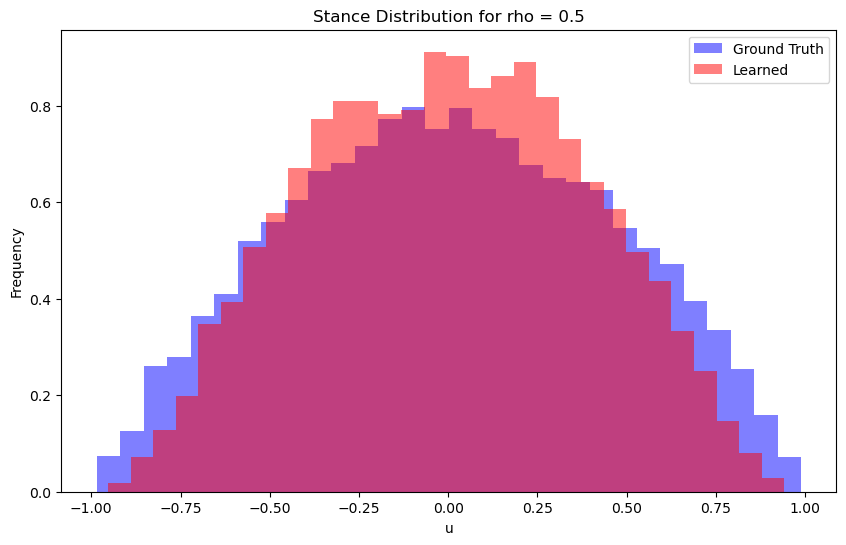

Testing Inference on Rho = 0.6
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 10000
Grid Size: 200
Learning Rate: 0.1
Improvement Threshold: 1e-05
Patience: 5
Initial Parameters:
Alpha: 3.5139124393463135
Beta: 1.0545164346694946
W: [0.8802918791770935, 0.5456262826919556, -0.5978752970695496]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 200


  0%|          | 1/200 [00:00<01:26,  2.31it/s]

Epoch 1, NLL: 12.987, Alpha: 3.368, Beta: 1.088, W: [0.6581664681434631, 0.8476079702377319, -0.6777292490005493]
Epoch 2 of 200


  1%|          | 2/200 [00:00<01:00,  3.27it/s]

Epoch 2, NLL: 11.555, Alpha: 3.286, Beta: 1.091, W: [0.5021210312843323, 1.065714716911316, -0.7397888898849487]
Epoch 3 of 200


  2%|▏         | 3/200 [00:00<00:56,  3.47it/s]

Epoch 3, NLL: 10.954, Alpha: 3.216, Beta: 1.091, W: [0.41535019874572754, 1.197648048400879, -0.7849500179290771]
Epoch 4 of 200


  2%|▏         | 4/200 [00:01<00:52,  3.73it/s]

Epoch 4, NLL: 10.756, Alpha: 3.148, Beta: 1.095, W: [0.364714115858078, 1.2829455137252808, -0.8196107149124146]
Epoch 5 of 200


  2%|▎         | 5/200 [00:01<00:49,  3.95it/s]

Epoch 5, NLL: 10.677, Alpha: 3.083, Beta: 1.102, W: [0.33311235904693604, 1.3427987098693848, -0.8478615283966064]
Epoch 6 of 200


  3%|▎         | 6/200 [00:01<01:03,  3.04it/s]

Epoch 6, NLL: 10.638, Alpha: 3.022, Beta: 1.111, W: [0.31250327825546265, 1.3875185251235962, -0.8719719052314758]
Epoch 7 of 200


  4%|▎         | 7/200 [00:02<00:57,  3.35it/s]

Epoch 7, NLL: 10.613, Alpha: 2.964, Beta: 1.122, W: [0.2987514138221741, 1.422547459602356, -0.8932486176490784]
Epoch 8 of 200


  4%|▍         | 8/200 [00:02<00:54,  3.51it/s]

Epoch 8, NLL: 10.595, Alpha: 2.911, Beta: 1.132, W: [0.28953054547309875, 1.4510066509246826, -0.912486732006073]
Epoch 9 of 200


  4%|▍         | 9/200 [00:02<01:06,  2.89it/s]

Epoch 9, NLL: 10.581, Alpha: 2.863, Beta: 1.143, W: [0.28343525528907776, 1.4748090505599976, -0.9301936626434326]
Epoch 10 of 200


  5%|▌         | 10/200 [00:03<00:59,  3.19it/s]

Epoch 10, NLL: 10.568, Alpha: 2.818, Beta: 1.155, W: [0.2795681357383728, 1.4951897859573364, -0.9467071294784546]
Epoch 11 of 200


  6%|▌         | 11/200 [00:03<00:54,  3.47it/s]

Epoch 11, NLL: 10.557, Alpha: 2.778, Beta: 1.165, W: [0.27733033895492554, 1.5129801034927368, -0.9622594714164734]
Epoch 12 of 200


  6%|▋         | 13/200 [00:03<00:44,  4.20it/s]

Epoch 12, NLL: 10.547, Alpha: 2.74, Beta: 1.176, W: [0.27630800008773804, 1.5287585258483887, -0.9770153760910034]
Epoch 13 of 200
Epoch 13, NLL: 10.538, Alpha: 2.706, Beta: 1.186, W: [0.27620670199394226, 1.5429394245147705, -0.9910947680473328]
Epoch 14 of 200


  8%|▊         | 15/200 [00:04<00:48,  3.84it/s]

Epoch 14, NLL: 10.529, Alpha: 2.675, Beta: 1.196, W: [0.276811808347702, 1.5558267831802368, -1.0045870542526245]
Epoch 15 of 200
Epoch 15, NLL: 10.521, Alpha: 2.646, Beta: 1.206, W: [0.2779635488986969, 1.5676485300064087, -1.0175604820251465]
Epoch 16 of 200


  8%|▊         | 17/200 [00:04<00:41,  4.43it/s]

Epoch 16, NLL: 10.513, Alpha: 2.619, Beta: 1.215, W: [0.27954086661338806, 1.5785788297653198, -1.0300679206848145]
Epoch 17 of 200
Epoch 17, NLL: 10.505, Alpha: 2.595, Beta: 1.224, W: [0.28145045042037964, 1.5887531042099, -1.042151689529419]
Epoch 18 of 200


  9%|▉         | 18/200 [00:05<00:51,  3.56it/s]

Epoch 18, NLL: 10.498, Alpha: 2.572, Beta: 1.232, W: [0.2836194932460785, 1.598278284072876, -1.053845763206482]
Epoch 19 of 200
Epoch 19, NLL: 10.491, Alpha: 2.551, Beta: 1.24, W: [0.285990446805954, 1.607240080833435, -1.0651782751083374]


 10%|█         | 20/200 [00:05<00:42,  4.21it/s]

Epoch 20 of 200
Epoch 20, NLL: 10.484, Alpha: 2.531, Beta: 1.248, W: [0.28851720690727234, 1.6157079935073853, -1.0761728286743164]
Epoch 21 of 200


 10%|█         | 21/200 [00:05<00:40,  4.42it/s]

Epoch 21, NLL: 10.478, Alpha: 2.513, Beta: 1.255, W: [0.29116272926330566, 1.6237393617630005, -1.086849570274353]
Epoch 22 of 200


 12%|█▏        | 23/200 [00:06<00:44,  3.98it/s]

Epoch 22, NLL: 10.472, Alpha: 2.496, Beta: 1.262, W: [0.29389676451683044, 1.631381630897522, -1.0972257852554321]
Epoch 23 of 200
Epoch 23, NLL: 10.466, Alpha: 2.48, Beta: 1.269, W: [0.2966945767402649, 1.6386748552322388, -1.1073167324066162]
Epoch 24 of 200


 12%|█▎        | 25/200 [00:06<00:39,  4.46it/s]

Epoch 24, NLL: 10.46, Alpha: 2.465, Beta: 1.276, W: [0.29953575134277344, 1.6456528902053833, -1.1171358823776245]
Epoch 25 of 200
Epoch 25, NLL: 10.455, Alpha: 2.451, Beta: 1.282, W: [0.30240345001220703, 1.652344822883606, -1.1266953945159912]
Epoch 26 of 200


 14%|█▎        | 27/200 [00:07<00:43,  3.93it/s]

Epoch 26, NLL: 10.45, Alpha: 2.438, Beta: 1.288, W: [0.30528366565704346, 1.6587756872177124, -1.1360063552856445]
Epoch 27 of 200
Epoch 27, NLL: 10.444, Alpha: 2.426, Beta: 1.294, W: [0.30816468596458435, 1.6649671792984009, -1.1450787782669067]
Epoch 28 of 200


 14%|█▍        | 29/200 [00:07<00:38,  4.45it/s]

Epoch 28, NLL: 10.44, Alpha: 2.414, Beta: 1.3, W: [0.3110368251800537, 1.6709383726119995, -1.1539219617843628]
Epoch 29 of 200
Epoch 29, NLL: 10.435, Alpha: 2.403, Beta: 1.306, W: [0.3138919472694397, 1.676706075668335, -1.16254460811615]
Epoch 30 of 200


 16%|█▌        | 31/200 [00:08<00:43,  3.92it/s]

Epoch 30, NLL: 10.43, Alpha: 2.392, Beta: 1.311, W: [0.3167232871055603, 1.6822850704193115, -1.1709548234939575]
Epoch 31 of 200
Epoch 31, NLL: 10.426, Alpha: 2.391, Beta: 1.312, W: [0.3170034885406494, 1.6828254461288452, -1.1717753410339355]
Epoch 32 of 200


 16%|█▌        | 32/200 [00:08<00:40,  4.20it/s]

Epoch 32, NLL: 10.425, Alpha: 2.391, Beta: 1.312, W: [0.31728336215019226, 1.6833641529083252, -1.1725938320159912]
Epoch 33 of 200


 16%|█▋        | 33/200 [00:08<00:38,  4.31it/s]

Epoch 33, NLL: 10.425, Alpha: 2.39, Beta: 1.313, W: [0.31756290793418884, 1.6839011907577515, -1.173410415649414]
Epoch 34 of 200


 17%|█▋        | 34/200 [00:09<00:48,  3.45it/s]

Epoch 34, NLL: 10.424, Alpha: 2.389, Beta: 1.313, W: [0.3178420960903168, 1.684436559677124, -1.1742249727249146]
Epoch 35 of 200


 18%|█▊        | 35/200 [00:09<00:45,  3.61it/s]

Epoch 35, NLL: 10.424, Alpha: 2.388, Beta: 1.314, W: [0.31812095642089844, 1.6849703788757324, -1.1750376224517822]
Epoch 36 of 200


 18%|█▊        | 36/200 [00:09<00:42,  3.83it/s]

Epoch 36, NLL: 10.423, Alpha: 2.387, Beta: 1.314, W: [0.31839945912361145, 1.685502529144287, -1.1758482456207275]
Epoch 37 of 200


 18%|█▊        | 37/200 [00:09<00:41,  3.97it/s]

Epoch 37, NLL: 10.423, Alpha: 2.386, Beta: 1.315, W: [0.3186776340007782, 1.6860331296920776, -1.17665696144104]
Epoch 38 of 200


 19%|█▉        | 38/200 [00:10<00:50,  3.19it/s]

Epoch 38, NLL: 10.423, Alpha: 2.385, Beta: 1.315, W: [0.3189554512500763, 1.6865620613098145, -1.1774637699127197]
Epoch 39 of 200


 20%|█▉        | 39/200 [00:10<00:46,  3.43it/s]

Epoch 39, NLL: 10.422, Alpha: 2.384, Beta: 1.316, W: [0.31923291087150574, 1.687089443206787, -1.178268551826477]
Epoch 40 of 200


 20%|██        | 41/200 [00:10<00:41,  3.87it/s]

Epoch 40, NLL: 10.422, Alpha: 2.383, Beta: 1.316, W: [0.31951001286506653, 1.6876152753829956, -1.1790714263916016]
Epoch 41 of 200
Epoch 41, NLL: 10.421, Alpha: 2.382, Beta: 1.317, W: [0.3197867274284363, 1.68813955783844, -1.1798723936080933]
Epoch 42 of 200


 22%|██▏       | 43/200 [00:11<00:44,  3.57it/s]

Epoch 42, NLL: 10.421, Alpha: 2.381, Beta: 1.318, W: [0.3200630843639374, 1.6886622905731201, -1.1806714534759521]
Epoch 43 of 200
Epoch 43, NLL: 10.421, Alpha: 2.38, Beta: 1.318, W: [0.3203390836715698, 1.6891834735870361, -1.1814686059951782]
Epoch 44 of 200


 22%|██▎       | 45/200 [00:12<00:37,  4.14it/s]

Epoch 44, NLL: 10.42, Alpha: 2.379, Beta: 1.319, W: [0.32061469554901123, 1.689703106880188, -1.1822638511657715]
Epoch 45 of 200
Epoch 45, NLL: 10.42, Alpha: 2.378, Beta: 1.319, W: [0.3208899199962616, 1.6902211904525757, -1.183057188987732]
Epoch 46 of 200


 24%|██▎       | 47/200 [00:12<00:39,  3.89it/s]

Epoch 46, NLL: 10.419, Alpha: 2.377, Beta: 1.32, W: [0.3211647868156433, 1.6907377243041992, -1.1838486194610596]
Epoch 47 of 200
Epoch 47, NLL: 10.419, Alpha: 2.376, Beta: 1.32, W: [0.321439266204834, 1.6912528276443481, -1.1846381425857544]
Epoch 48 of 200


 24%|██▍       | 49/200 [00:12<00:32,  4.59it/s]

Epoch 48, NLL: 10.418, Alpha: 2.375, Beta: 1.321, W: [0.3217133581638336, 1.691766381263733, -1.1854257583618164]
Epoch 49 of 200
Epoch 49, NLL: 10.418, Alpha: 2.374, Beta: 1.321, W: [0.3219870626926422, 1.692278504371643, -1.1862115859985352]
Epoch 50 of 200


 26%|██▌       | 51/200 [00:13<00:36,  4.03it/s]

Epoch 50, NLL: 10.418, Alpha: 2.374, Beta: 1.322, W: [0.3222603499889374, 1.692789077758789, -1.186995506286621]
Epoch 51 of 200
Epoch 51, NLL: 10.417, Alpha: 2.373, Beta: 1.322, W: [0.3225332498550415, 1.6932982206344604, -1.1877775192260742]
Epoch 52 of 200


 26%|██▋       | 53/200 [00:13<00:32,  4.58it/s]

Epoch 52, NLL: 10.417, Alpha: 2.372, Beta: 1.323, W: [0.3228057622909546, 1.6938059329986572, -1.188557744026184]
Epoch 53 of 200
Epoch 53, NLL: 10.416, Alpha: 2.371, Beta: 1.323, W: [0.32307785749435425, 1.6943122148513794, -1.1893360614776611]
Epoch 54 of 200


 27%|██▋       | 54/200 [00:14<00:41,  3.54it/s]

Epoch 54, NLL: 10.416, Alpha: 2.37, Beta: 1.324, W: [0.32334956526756287, 1.694817066192627, -1.190112590789795]
Epoch 55 of 200


 28%|██▊       | 56/200 [00:14<00:34,  4.23it/s]

Epoch 55, NLL: 10.416, Alpha: 2.369, Beta: 1.324, W: [0.32362085580825806, 1.6953204870224, -1.190887212753296]
Epoch 56 of 200
Epoch 56, NLL: 10.415, Alpha: 2.368, Beta: 1.325, W: [0.3238917291164398, 1.6958224773406982, -1.1916600465774536]
Epoch 57 of 200


 28%|██▊       | 57/200 [00:14<00:32,  4.36it/s]

Epoch 57, NLL: 10.415, Alpha: 2.367, Beta: 1.325, W: [0.32416221499443054, 1.696323037147522, -1.192431092262268]
Epoch 58 of 200


 30%|██▉       | 59/200 [00:15<00:33,  4.20it/s]

Epoch 58, NLL: 10.414, Alpha: 2.366, Beta: 1.326, W: [0.32443228363990784, 1.696822166442871, -1.1932002305984497]
Epoch 59 of 200
Epoch 59, NLL: 10.414, Alpha: 2.366, Beta: 1.326, W: [0.3247019350528717, 1.6973198652267456, -1.193967580795288]
Epoch 60 of 200


 30%|███       | 61/200 [00:15<00:27,  4.98it/s]

Epoch 60, NLL: 10.414, Alpha: 2.365, Beta: 1.327, W: [0.32497116923332214, 1.697816252708435, -1.1947331428527832]
Epoch 61 of 200
Epoch 61, NLL: 10.413, Alpha: 2.365, Beta: 1.327, W: [0.32499805092811584, 1.6978657245635986, -1.1948095560073853]
Epoch 62 of 200


 31%|███       | 62/200 [00:16<00:35,  3.93it/s]

Epoch 62, NLL: 10.413, Alpha: 2.365, Beta: 1.327, W: [0.32502493262290955, 1.6979151964187622, -1.1948859691619873]
Epoch 63 of 200


 32%|███▏      | 64/200 [00:16<00:29,  4.57it/s]

Epoch 63, NLL: 10.413, Alpha: 2.365, Beta: 1.327, W: [0.32505181431770325, 1.6979646682739258, -1.1949622631072998]
Epoch 64 of 200
Epoch 64, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.32507869601249695, 1.6980141401290894, -1.1950385570526123]
Epoch 65 of 200


 32%|███▎      | 65/200 [00:16<00:27,  4.91it/s]

Epoch 65, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.32510554790496826, 1.698063611984253, -1.1951148509979248]
Epoch 66 of 200


 34%|███▎      | 67/200 [00:17<00:30,  4.34it/s]

Epoch 66, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.3251323997974396, 1.6981130838394165, -1.1951911449432373]
Epoch 67 of 200
Epoch 67, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.3251592516899109, 1.69816255569458, -1.1952674388885498]
Epoch 68 of 200


 34%|███▍      | 69/200 [00:17<00:26,  4.95it/s]

Epoch 68, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.3251861035823822, 1.698211908340454, -1.1953437328338623]
Epoch 69 of 200
Epoch 69, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.3252129554748535, 1.6982612609863281, -1.1954199075698853]
Epoch 70 of 200


 36%|███▌      | 71/200 [00:18<00:31,  4.16it/s]

Epoch 70, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.32523980736732483, 1.6983106136322021, -1.1954960823059082]
Epoch 71 of 200
Epoch 71, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.32526665925979614, 1.6983599662780762, -1.1955722570419312]
Epoch 72 of 200


 36%|███▋      | 73/200 [00:18<00:26,  4.83it/s]

Epoch 72, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.32529348134994507, 1.6984093189239502, -1.195648431777954]
Epoch 73 of 200
Epoch 73, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.325320303440094, 1.6984586715698242, -1.195724606513977]
Epoch 74 of 200


 38%|███▊      | 75/200 [00:19<00:29,  4.28it/s]

Epoch 74, NLL: 10.413, Alpha: 2.364, Beta: 1.327, W: [0.3253471255302429, 1.6985080242156982, -1.19580078125]
Epoch 75 of 200
Epoch 75, NLL: 10.413, Alpha: 2.363, Beta: 1.327, W: [0.32537394762039185, 1.6985573768615723, -1.195876955986023]
Epoch 76 of 200


 38%|███▊      | 77/200 [00:19<00:25,  4.87it/s]

Epoch 76, NLL: 10.413, Alpha: 2.363, Beta: 1.327, W: [0.32540076971054077, 1.6986066102981567, -1.1959530115127563]
Epoch 77 of 200
Epoch 77, NLL: 10.413, Alpha: 2.363, Beta: 1.328, W: [0.3254275918006897, 1.6986558437347412, -1.1960290670394897]
Epoch 78 of 200


 39%|███▉      | 78/200 [00:19<00:23,  5.16it/s]

Epoch 78, NLL: 10.413, Alpha: 2.363, Beta: 1.328, W: [0.3254544138908386, 1.6987050771713257, -1.1961051225662231]
Epoch 79 of 200


 40%|████      | 80/200 [00:20<00:25,  4.62it/s]

Epoch 79, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.32548120617866516, 1.6987543106079102, -1.1961811780929565]
Epoch 80 of 200
Epoch 80, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.3255079984664917, 1.6988035440444946, -1.19625723361969]
Epoch 81 of 200


 40%|████      | 81/200 [00:20<00:23,  4.96it/s]

Epoch 81, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.32553479075431824, 1.698852777481079, -1.1963332891464233]
Epoch 82 of 200


 42%|████▏     | 83/200 [00:20<00:27,  4.19it/s]

Epoch 82, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.3255615830421448, 1.6989020109176636, -1.1964093446731567]
Epoch 83 of 200
Epoch 83, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.3255883753299713, 1.698951244354248, -1.1964852809906006]
Epoch 84 of 200


 42%|████▎     | 85/200 [00:21<00:24,  4.63it/s]

Epoch 84, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.32561516761779785, 1.6990004777908325, -1.1965612173080444]
Epoch 85 of 200
Epoch 85, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.3256419599056244, 1.6990495920181274, -1.1966371536254883]
Epoch 86 of 200


 43%|████▎     | 86/200 [00:21<00:23,  4.89it/s]

Epoch 86, NLL: 10.412, Alpha: 2.363, Beta: 1.328, W: [0.32566872239112854, 1.6990987062454224, -1.1967130899429321]
Epoch 87 of 200


 44%|████▍     | 88/200 [00:22<00:25,  4.37it/s]

Epoch 87, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3256954848766327, 1.6991478204727173, -1.196789026260376]
Epoch 88 of 200
Epoch 88, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32572224736213684, 1.6991969347000122, -1.1968649625778198]
Epoch 89 of 200


 45%|████▌     | 90/200 [00:22<00:22,  4.89it/s]

Epoch 89, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.325749009847641, 1.6992460489273071, -1.1969407796859741]
Epoch 90 of 200
Epoch 90, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32577577233314514, 1.699295163154602, -1.1970165967941284]
Epoch 91 of 200


 46%|████▌     | 92/200 [00:22<00:25,  4.31it/s]

Epoch 91, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32577845454216003, 1.6993000507354736, -1.1970242261886597]
Epoch 92 of 200
Epoch 92, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257811367511749, 1.6993049383163452, -1.197031855583191]
Epoch 93 of 200


 47%|████▋     | 94/200 [00:23<00:21,  4.89it/s]

Epoch 93, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257838189601898, 1.6993098258972168, -1.1970394849777222]
Epoch 94 of 200
Epoch 94, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257865011692047, 1.6993147134780884, -1.1970471143722534]
Epoch 95 of 200


 48%|████▊     | 96/200 [00:23<00:25,  4.15it/s]

Epoch 95, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257891833782196, 1.69931960105896, -1.1970547437667847]
Epoch 96 of 200
Epoch 96, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257918655872345, 1.6993244886398315, -1.197062373161316]
Epoch 97 of 200


 49%|████▉     | 98/200 [00:24<00:21,  4.83it/s]

Epoch 97, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257945477962494, 1.6993293762207031, -1.1970700025558472]
Epoch 98 of 200
Epoch 98, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257972300052643, 1.6993342638015747, -1.1970776319503784]
Epoch 99 of 200


 50%|█████     | 100/200 [00:24<00:24,  4.15it/s]

Epoch 99, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3257999122142792, 1.6993391513824463, -1.1970852613449097]
Epoch 100 of 200
Epoch 100, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32580259442329407, 1.6993440389633179, -1.197092890739441]
Epoch 101 of 200


 51%|█████     | 102/200 [00:25<00:21,  4.63it/s]

Epoch 101, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32580527663230896, 1.6993489265441895, -1.1971005201339722]
Epoch 102 of 200
Epoch 102, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32580795884132385, 1.699353814125061, -1.1971081495285034]
Epoch 103 of 200


 52%|█████▏    | 103/200 [00:25<00:25,  3.76it/s]

Epoch 103, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32581064105033875, 1.6993587017059326, -1.1971157789230347]
Epoch 104 of 200


 52%|█████▎    | 105/200 [00:25<00:21,  4.47it/s]

Epoch 104, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32581332325935364, 1.6993635892868042, -1.197123408317566]
Epoch 105 of 200
Epoch 105, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32581600546836853, 1.6993684768676758, -1.1971310377120972]
Epoch 106 of 200


 53%|█████▎    | 106/200 [00:26<00:19,  4.78it/s]

Epoch 106, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258186876773834, 1.6993733644485474, -1.1971386671066284]
Epoch 107 of 200


 54%|█████▍    | 108/200 [00:26<00:21,  4.25it/s]

Epoch 107, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258213698863983, 1.699378252029419, -1.1971462965011597]
Epoch 108 of 200
Epoch 108, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258240520954132, 1.6993831396102905, -1.197153925895691]
Epoch 109 of 200


 55%|█████▌    | 110/200 [00:27<00:18,  4.96it/s]

Epoch 109, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258267343044281, 1.699388027191162, -1.1971615552902222]
Epoch 110 of 200
Epoch 110, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.325829416513443, 1.6993929147720337, -1.1971691846847534]
Epoch 111 of 200


 56%|█████▌    | 112/200 [00:27<00:20,  4.21it/s]

Epoch 111, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258320987224579, 1.6993978023529053, -1.1971768140792847]
Epoch 112 of 200
Epoch 112, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258347809314728, 1.6994026899337769, -1.197184443473816]
Epoch 113 of 200


 57%|█████▋    | 114/200 [00:28<00:18,  4.57it/s]

Epoch 113, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32583746314048767, 1.6994075775146484, -1.1971920728683472]
Epoch 114 of 200
Epoch 114, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32584014534950256, 1.69941246509552, -1.1971997022628784]
Epoch 115 of 200


 57%|█████▊    | 115/200 [00:28<00:18,  4.65it/s]

Epoch 115, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32584282755851746, 1.6994173526763916, -1.1972073316574097]
Epoch 116 of 200


 58%|█████▊    | 116/200 [00:28<00:22,  3.65it/s]

Epoch 116, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32584550976753235, 1.6994222402572632, -1.197214961051941]
Epoch 117 of 200


 58%|█████▊    | 117/200 [00:28<00:21,  3.91it/s]

Epoch 117, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32584819197654724, 1.6994271278381348, -1.1972225904464722]
Epoch 118 of 200


 59%|█████▉    | 118/200 [00:29<00:20,  3.91it/s]

Epoch 118, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32585087418556213, 1.6994320154190063, -1.1972302198410034]
Epoch 119 of 200


 60%|█████▉    | 119/200 [00:29<00:25,  3.20it/s]

Epoch 119, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.325853556394577, 1.699436902999878, -1.1972378492355347]
Epoch 120 of 200


 60%|██████    | 121/200 [00:29<00:20,  3.91it/s]

Epoch 120, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258562386035919, 1.6994417905807495, -1.197245478630066]
Epoch 121 of 200
Epoch 121, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258565068244934, 1.6994422674179077, -1.1972461938858032]
Epoch 122 of 200


 61%|██████    | 122/200 [00:30<00:20,  3.88it/s]

Epoch 122, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258567750453949, 1.699442744255066, -1.1972469091415405]
Epoch 123 of 200


 62%|██████▏   | 123/200 [00:30<00:19,  3.97it/s]

Epoch 123, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258570432662964, 1.6994432210922241, -1.1972476243972778]
Epoch 124 of 200


 62%|██████▏   | 124/200 [00:30<00:23,  3.23it/s]

Epoch 124, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.3258573114871979, 1.6994436979293823, -1.1972483396530151]
Epoch 125 of 200


 62%|██████▎   | 125/200 [00:31<00:21,  3.53it/s]

Epoch 125, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32585757970809937, 1.6994441747665405, -1.1972490549087524]
Epoch 126 of 200


 62%|██████▎   | 125/200 [00:31<00:18,  3.98it/s]

Epoch 126, NLL: 10.412, Alpha: 2.362, Beta: 1.328, W: [0.32585784792900085, 1.6994446516036987, -1.1972497701644897]
Early stopping triggered after 126 epochs.
Training Took 31.48 Seconds.
Trained Params: alpha: 2.361963901012601, beta: 1.3283007969667886, W: [0.32585784792900085, 1.6994446516036987, -1.1972497701644897]
Rho Estimate: 0.640052704703242


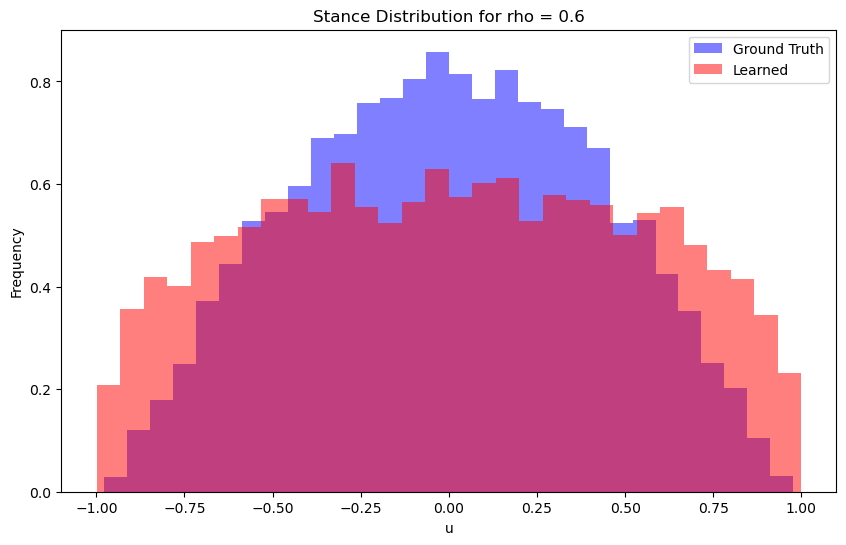

Testing Inference on Rho = 0.7
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 10000
Grid Size: 200
Learning Rate: 0.1
Improvement Threshold: 1e-05
Patience: 5
Initial Parameters:
Alpha: 1.7580174207687378
Beta: 0.04475697502493858
W: [-0.5610355734825134, -0.6313652992248535, 0.09934781491756439]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 200


  0%|          | 1/200 [00:00<01:38,  2.01it/s]

Epoch 1, NLL: 15.451, Alpha: 1.663, Beta: 0.049, W: [-0.975272536277771, -0.3485066890716553, 0.23072591423988342]
Epoch 2 of 200


  1%|          | 2/200 [00:00<01:09,  2.84it/s]

Epoch 2, NLL: 13.211, Alpha: 1.587, Beta: 0.054, W: [-1.1936354637145996, -0.16205424070358276, 0.2626369893550873]
Epoch 3 of 200


  2%|▏         | 3/200 [00:01<01:10,  2.81it/s]

Epoch 3, NLL: 12.551, Alpha: 1.523, Beta: 0.059, W: [-1.302502155303955, -0.008090338669717312, 0.21753951907157898]
Epoch 4 of 200


  2%|▏         | 4/200 [00:01<01:06,  2.97it/s]

Epoch 4, NLL: 12.172, Alpha: 1.468, Beta: 0.064, W: [-1.3563848733901978, 0.1470746397972107, 0.11625644564628601]
Epoch 5 of 200


  2%|▎         | 5/200 [00:01<01:20,  2.42it/s]

Epoch 5, NLL: 11.719, Alpha: 1.423, Beta: 0.07, W: [-1.3767613172531128, 0.29852864146232605, -0.014822669327259064]
Epoch 6 of 200


  3%|▎         | 6/200 [00:02<01:10,  2.75it/s]

Epoch 6, NLL: 11.247, Alpha: 1.385, Beta: 0.076, W: [-1.3801822662353516, 0.42252281308174133, -0.13539721071720123]
Epoch 7 of 200


  4%|▎         | 7/200 [00:02<01:02,  3.09it/s]

Epoch 7, NLL: 10.915, Alpha: 1.349, Beta: 0.082, W: [-1.3807358741760254, 0.5105025172233582, -0.22282400727272034]
Epoch 8 of 200


  4%|▍         | 8/200 [00:02<00:56,  3.39it/s]

Epoch 8, NLL: 10.733, Alpha: 1.315, Beta: 0.089, W: [-1.3840876817703247, 0.5705655217170715, -0.2795354425907135]
Epoch 9 of 200


  5%|▌         | 10/200 [00:03<00:55,  3.45it/s]

Epoch 9, NLL: 10.629, Alpha: 1.283, Beta: 0.096, W: [-1.3904473781585693, 0.6125382781028748, -0.31514865159988403]
Epoch 10 of 200
Epoch 10, NLL: 10.56, Alpha: 1.252, Beta: 0.104, W: [-1.3987109661102295, 0.643131673336029, -0.3374785780906677]
Epoch 11 of 200


  6%|▌         | 12/200 [00:03<00:43,  4.29it/s]

Epoch 11, NLL: 10.505, Alpha: 1.222, Beta: 0.112, W: [-1.4079095125198364, 0.6664431095123291, -0.3515914976596832]
Epoch 12 of 200
Epoch 12, NLL: 10.456, Alpha: 1.194, Beta: 0.121, W: [-1.4174227714538574, 0.6849676370620728, -0.36060279607772827]
Epoch 13 of 200


  7%|▋         | 14/200 [00:04<00:48,  3.87it/s]

Epoch 13, NLL: 10.413, Alpha: 1.168, Beta: 0.129, W: [-1.4269033670425415, 0.7002620697021484, -0.36641669273376465]
Epoch 14 of 200
Epoch 14, NLL: 10.372, Alpha: 1.143, Beta: 0.139, W: [-1.4361783266067505, 0.7133263945579529, -0.3702060878276825]
Epoch 15 of 200


  8%|▊         | 16/200 [00:04<00:39,  4.72it/s]

Epoch 15, NLL: 10.335, Alpha: 1.119, Beta: 0.148, W: [-1.4451767206192017, 0.7248199582099915, -0.3727012574672699]
Epoch 16 of 200
Epoch 16, NLL: 10.3, Alpha: 1.097, Beta: 0.158, W: [-1.4538840055465698, 0.7351876497268677, -0.3743617534637451]
Epoch 17 of 200


  8%|▊         | 17/200 [00:05<00:51,  3.53it/s]

Epoch 17, NLL: 10.269, Alpha: 1.077, Beta: 0.169, W: [-1.4623140096664429, 0.744735598564148, -0.37547972798347473]
Epoch 18 of 200


  9%|▉         | 18/200 [00:05<00:51,  3.56it/s]

Epoch 18, NLL: 10.24, Alpha: 1.058, Beta: 0.179, W: [-1.4704933166503906, 0.7536776661872864, -0.37624257802963257]
Epoch 19 of 200


 10%|▉         | 19/200 [00:05<00:49,  3.63it/s]

Epoch 19, NLL: 10.213, Alpha: 1.04, Beta: 0.19, W: [-1.4784520864486694, 0.7621653079986572, -0.37677139043807983]
Epoch 20 of 200


 10%|█         | 20/200 [00:05<00:48,  3.69it/s]

Epoch 20, NLL: 10.19, Alpha: 1.023, Beta: 0.201, W: [-1.4862194061279297, 0.770306408405304, -0.3771451711654663]
Epoch 21 of 200


 10%|█         | 21/200 [00:06<01:00,  2.94it/s]

Epoch 21, NLL: 10.168, Alpha: 1.008, Beta: 0.212, W: [-1.4938205480575562, 0.7781781554222107, -0.3774157166481018]
Epoch 22 of 200


 11%|█         | 22/200 [00:06<00:56,  3.17it/s]

Epoch 22, NLL: 10.149, Alpha: 0.994, Beta: 0.223, W: [-1.5012768507003784, 0.7858359217643738, -0.3776171803474426]
Epoch 23 of 200


 12%|█▏        | 23/200 [00:06<00:52,  3.36it/s]

Epoch 23, NLL: 10.132, Alpha: 0.981, Beta: 0.235, W: [-1.5086050033569336, 0.7933189868927002, -0.37777212262153625]
Epoch 24 of 200


 12%|█▏        | 24/200 [00:07<00:50,  3.47it/s]

Epoch 24, NLL: 10.117, Alpha: 0.969, Beta: 0.246, W: [-1.515817403793335, 0.8006550073623657, -0.37789562344551086]
Epoch 25 of 200


 13%|█▎        | 26/200 [00:07<00:55,  3.14it/s]

Epoch 25, NLL: 10.104, Alpha: 0.958, Beta: 0.258, W: [-1.5229231119155884, 0.8078629374504089, -0.3779977858066559]
Epoch 26 of 200
Epoch 26, NLL: 10.092, Alpha: 0.948, Beta: 0.269, W: [-1.5299279689788818, 0.8149553537368774, -0.3780854046344757]
Epoch 27 of 200


 14%|█▍        | 28/200 [00:08<00:41,  4.18it/s]

Epoch 27, NLL: 10.082, Alpha: 0.938, Beta: 0.281, W: [-1.5368351936340332, 0.8219402432441711, -0.3781629800796509]
Epoch 28 of 200
Epoch 28, NLL: 10.073, Alpha: 0.93, Beta: 0.292, W: [-1.5436463356018066, 0.8288219571113586, -0.3782336115837097]
Epoch 29 of 200


 15%|█▌        | 30/200 [00:08<00:43,  3.88it/s]

Epoch 29, NLL: 10.065, Alpha: 0.922, Beta: 0.303, W: [-1.5503612756729126, 0.8356027007102966, -0.3782992660999298]
Epoch 30 of 200
Epoch 30, NLL: 10.058, Alpha: 0.915, Beta: 0.315, W: [-1.5569791793823242, 0.8422827124595642, -0.37836140394210815]
Epoch 31 of 200


 16%|█▌        | 32/200 [00:09<00:36,  4.66it/s]

Epoch 31, NLL: 10.052, Alpha: 0.914, Beta: 0.316, W: [-1.5576311349868774, 0.8429405689239502, -0.3783673346042633]
Epoch 32 of 200
Epoch 32, NLL: 10.051, Alpha: 0.913, Beta: 0.317, W: [-1.5582818984985352, 0.8435972929000854, -0.37837326526641846]
Epoch 33 of 200


 16%|█▋        | 33/200 [00:09<00:48,  3.46it/s]

Epoch 33, NLL: 10.051, Alpha: 0.913, Beta: 0.318, W: [-1.558931589126587, 0.84425288438797, -0.3783791661262512]
Epoch 34 of 200


 17%|█▋        | 34/200 [00:09<00:47,  3.53it/s]

Epoch 34, NLL: 10.05, Alpha: 0.912, Beta: 0.319, W: [-1.5595802068710327, 0.8449074029922485, -0.3783850371837616]
Epoch 35 of 200


 18%|█▊        | 35/200 [00:10<00:44,  3.70it/s]

Epoch 35, NLL: 10.05, Alpha: 0.911, Beta: 0.32, W: [-1.5602277517318726, 0.8455607891082764, -0.378390908241272]
Epoch 36 of 200


 18%|█▊        | 36/200 [00:10<00:44,  3.73it/s]

Epoch 36, NLL: 10.049, Alpha: 0.911, Beta: 0.321, W: [-1.5608742237091064, 0.8462130427360535, -0.37839674949645996]
Epoch 37 of 200


 18%|█▊        | 37/200 [00:10<00:55,  2.91it/s]

Epoch 37, NLL: 10.049, Alpha: 0.91, Beta: 0.322, W: [-1.5615195035934448, 0.8468641638755798, -0.37840256094932556]
Epoch 38 of 200


 19%|█▉        | 38/200 [00:11<00:54,  2.98it/s]

Epoch 38, NLL: 10.048, Alpha: 0.909, Beta: 0.323, W: [-1.5621637105941772, 0.8475142121315002, -0.37840837240219116]
Epoch 39 of 200


 20%|█▉        | 39/200 [00:11<00:51,  3.10it/s]

Epoch 39, NLL: 10.048, Alpha: 0.909, Beta: 0.324, W: [-1.5628068447113037, 0.8481631278991699, -0.3784141540527344]
Epoch 40 of 200


 20%|██        | 40/200 [00:11<00:47,  3.36it/s]

Epoch 40, NLL: 10.047, Alpha: 0.908, Beta: 0.326, W: [-1.5634489059448242, 0.8488109111785889, -0.3784199059009552]
Epoch 41 of 200


 20%|██        | 41/200 [00:12<00:55,  2.88it/s]

Epoch 41, NLL: 10.047, Alpha: 0.908, Beta: 0.327, W: [-1.5640898942947388, 0.8494575619697571, -0.378425657749176]
Epoch 42 of 200


 21%|██        | 42/200 [00:12<00:52,  2.99it/s]

Epoch 42, NLL: 10.046, Alpha: 0.907, Beta: 0.328, W: [-1.5647296905517578, 0.8501031398773193, -0.37843137979507446]
Epoch 43 of 200


 22%|██▏       | 43/200 [00:12<00:55,  2.84it/s]

Epoch 43, NLL: 10.046, Alpha: 0.906, Beta: 0.329, W: [-1.565368413925171, 0.8507475852966309, -0.3784370720386505]
Epoch 44 of 200


 22%|██▏       | 44/200 [00:13<00:50,  3.06it/s]

Epoch 44, NLL: 10.045, Alpha: 0.906, Beta: 0.33, W: [-1.566006064414978, 0.8513908982276917, -0.37844276428222656]
Epoch 45 of 200


 23%|██▎       | 46/200 [00:13<00:46,  3.31it/s]

Epoch 45, NLL: 10.045, Alpha: 0.905, Beta: 0.331, W: [-1.5666426420211792, 0.8520331382751465, -0.3784484267234802]
Epoch 46 of 200
Epoch 46, NLL: 10.044, Alpha: 0.905, Beta: 0.332, W: [-1.5672781467437744, 0.8526742458343506, -0.3784540891647339]
Epoch 47 of 200


 24%|██▍       | 48/200 [00:14<00:36,  4.13it/s]

Epoch 47, NLL: 10.044, Alpha: 0.904, Beta: 0.333, W: [-1.5679124593734741, 0.853314220905304, -0.37845972180366516]
Epoch 48 of 200
Epoch 48, NLL: 10.043, Alpha: 0.904, Beta: 0.334, W: [-1.5685456991195679, 0.8539531230926514, -0.37846532464027405]
Epoch 49 of 200


 25%|██▌       | 50/200 [00:14<00:38,  3.86it/s]

Epoch 49, NLL: 10.043, Alpha: 0.903, Beta: 0.335, W: [-1.5691778659820557, 0.854590892791748, -0.37847092747688293]
Epoch 50 of 200
Epoch 50, NLL: 10.042, Alpha: 0.902, Beta: 0.336, W: [-1.5698089599609375, 0.855227530002594, -0.3784765303134918]
Epoch 51 of 200


 26%|██▌       | 52/200 [00:15<00:32,  4.62it/s]

Epoch 51, NLL: 10.042, Alpha: 0.902, Beta: 0.337, W: [-1.5704389810562134, 0.855863094329834, -0.3784821033477783]
Epoch 52 of 200
Epoch 52, NLL: 10.042, Alpha: 0.901, Beta: 0.338, W: [-1.5710678100585938, 0.8564975261688232, -0.37848764657974243]
Epoch 53 of 200


 26%|██▋       | 53/200 [00:15<00:39,  3.74it/s]

Epoch 53, NLL: 10.041, Alpha: 0.901, Beta: 0.34, W: [-1.5716955661773682, 0.8571308255195618, -0.37849318981170654]
Epoch 54 of 200


 27%|██▋       | 54/200 [00:15<00:36,  3.96it/s]

Epoch 54, NLL: 10.041, Alpha: 0.9, Beta: 0.341, W: [-1.5723222494125366, 0.8577629923820496, -0.37849870324134827]
Epoch 55 of 200


 28%|██▊       | 55/200 [00:15<00:35,  4.06it/s]

Epoch 55, NLL: 10.04, Alpha: 0.9, Beta: 0.342, W: [-1.5729478597640991, 0.8583940863609314, -0.37850421667099]
Epoch 56 of 200


 28%|██▊       | 56/200 [00:16<00:34,  4.17it/s]

Epoch 56, NLL: 10.04, Alpha: 0.899, Beta: 0.343, W: [-1.5735722780227661, 0.8590240478515625, -0.3785097002983093]
Epoch 57 of 200


 28%|██▊       | 57/200 [00:16<00:42,  3.36it/s]

Epoch 57, NLL: 10.04, Alpha: 0.899, Beta: 0.344, W: [-1.5741956233978271, 0.8596528768539429, -0.37851518392562866]
Epoch 58 of 200


 29%|██▉       | 58/200 [00:16<00:40,  3.54it/s]

Epoch 58, NLL: 10.039, Alpha: 0.898, Beta: 0.345, W: [-1.5748178958892822, 0.8602806329727173, -0.378520667552948]
Epoch 59 of 200


 30%|██▉       | 59/200 [00:17<00:38,  3.64it/s]

Epoch 59, NLL: 10.039, Alpha: 0.898, Beta: 0.346, W: [-1.5754390954971313, 0.860907256603241, -0.37852612137794495]
Epoch 60 of 200


 30%|███       | 60/200 [00:17<00:36,  3.80it/s]

Epoch 60, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.5760592222213745, 0.8615327477455139, -0.3785315454006195]
Epoch 61 of 200


 30%|███       | 61/200 [00:17<00:45,  3.05it/s]

Epoch 61, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.5761210918426514, 0.8615952134132385, -0.3785320818424225]
Epoch 62 of 200


 31%|███       | 62/200 [00:18<00:42,  3.27it/s]

Epoch 62, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.5761829614639282, 0.8616576194763184, -0.37853261828422546]
Epoch 63 of 200


 32%|███▏      | 63/200 [00:18<00:38,  3.53it/s]

Epoch 63, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.576244831085205, 0.8617200255393982, -0.37853315472602844]
Epoch 64 of 200


 32%|███▏      | 64/200 [00:18<00:36,  3.70it/s]

Epoch 64, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.576306700706482, 0.861782431602478, -0.3785336911678314]
Epoch 65 of 200


 32%|███▎      | 65/200 [00:19<00:46,  2.92it/s]

Epoch 65, NLL: 10.038, Alpha: 0.897, Beta: 0.347, W: [-1.5763685703277588, 0.8618448376655579, -0.3785342276096344]
Epoch 66 of 200


 33%|███▎      | 66/200 [00:19<00:42,  3.12it/s]

Epoch 66, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5764304399490356, 0.8619072437286377, -0.3785347640514374]
Epoch 67 of 200


 34%|███▎      | 67/200 [00:19<00:38,  3.45it/s]

Epoch 67, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5764923095703125, 0.8619695901870728, -0.37853530049324036]
Epoch 68 of 200


 34%|███▍      | 68/200 [00:19<00:36,  3.58it/s]

Epoch 68, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5765541791915894, 0.8620319366455078, -0.37853583693504333]
Epoch 69 of 200


 34%|███▍      | 69/200 [00:20<00:33,  3.89it/s]

Epoch 69, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5766159296035767, 0.8620942831039429, -0.3785363733768463]
Epoch 70 of 200


 35%|███▌      | 70/200 [00:20<00:45,  2.88it/s]

Epoch 70, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.576677680015564, 0.8621566295623779, -0.3785369098186493]
Epoch 71 of 200


 36%|███▌      | 71/200 [00:20<00:44,  2.88it/s]

Epoch 71, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5767394304275513, 0.862218976020813, -0.37853744626045227]
Epoch 72 of 200


 36%|███▌      | 72/200 [00:21<00:44,  2.90it/s]

Epoch 72, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5768011808395386, 0.8622812628746033, -0.37853798270225525]
Epoch 73 of 200


 36%|███▋      | 73/200 [00:21<00:44,  2.84it/s]

Epoch 73, NLL: 10.038, Alpha: 0.897, Beta: 0.348, W: [-1.5768629312515259, 0.8623435497283936, -0.3785385191440582]
Epoch 74 of 200


 37%|███▋      | 74/200 [00:21<00:40,  3.09it/s]

Epoch 74, NLL: 10.037, Alpha: 0.896, Beta: 0.348, W: [-1.5769246816635132, 0.8624058365821838, -0.3785390555858612]
Epoch 75 of 200


 38%|███▊      | 75/200 [00:22<00:37,  3.38it/s]

Epoch 75, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5769864320755005, 0.8624681234359741, -0.3785395920276642]
Epoch 76 of 200


 38%|███▊      | 76/200 [00:22<00:35,  3.49it/s]

Epoch 76, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5770481824874878, 0.8625304102897644, -0.37854012846946716]
Epoch 77 of 200


 38%|███▊      | 77/200 [00:22<00:32,  3.83it/s]

Epoch 77, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.577109932899475, 0.8625926971435547, -0.37854066491127014]
Epoch 78 of 200


 40%|███▉      | 79/200 [00:23<00:31,  3.88it/s]

Epoch 78, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5771716833114624, 0.8626549243927002, -0.3785412013530731]
Epoch 79 of 200
Epoch 79, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5772334337234497, 0.8627171516418457, -0.3785417377948761]
Epoch 80 of 200


 40%|████      | 81/200 [00:23<00:25,  4.62it/s]

Epoch 80, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5772950649261475, 0.8627793788909912, -0.3785422742366791]
Epoch 81 of 200
Epoch 81, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5773566961288452, 0.8628416061401367, -0.37854281067848206]
Epoch 82 of 200


 42%|████▏     | 83/200 [00:24<00:27,  4.30it/s]

Epoch 82, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.577418327331543, 0.8629038333892822, -0.37854334712028503]
Epoch 83 of 200
Epoch 83, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5774799585342407, 0.862966001033783, -0.378543883562088]
Epoch 84 of 200


 42%|████▎     | 85/200 [00:24<00:23,  4.99it/s]

Epoch 84, NLL: 10.037, Alpha: 0.896, Beta: 0.349, W: [-1.5775415897369385, 0.8630281686782837, -0.378544420003891]
Epoch 85 of 200
Epoch 85, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5776032209396362, 0.8630903363227844, -0.37854495644569397]
Epoch 86 of 200


 43%|████▎     | 86/200 [00:24<00:28,  4.00it/s]

Epoch 86, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.577664852142334, 0.8631525039672852, -0.37854549288749695]
Epoch 87 of 200


 44%|████▍     | 88/200 [00:25<00:24,  4.61it/s]

Epoch 87, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5777264833450317, 0.8632146716117859, -0.3785460293292999]
Epoch 88 of 200
Epoch 88, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5777881145477295, 0.8632767796516418, -0.3785465657711029]
Epoch 89 of 200


 44%|████▍     | 89/200 [00:25<00:22,  4.93it/s]

Epoch 89, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5778497457504272, 0.8633388876914978, -0.3785471022129059]
Epoch 90 of 200


 45%|████▌     | 90/200 [00:25<00:29,  3.73it/s]

Epoch 90, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.577911376953125, 0.8634009957313538, -0.37854763865470886]
Epoch 91 of 200


 46%|████▌     | 91/200 [00:25<00:27,  3.91it/s]

Epoch 91, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779175758361816, 0.8634071946144104, -0.37854769825935364]
Epoch 92 of 200


 46%|████▋     | 93/200 [00:26<00:25,  4.21it/s]

Epoch 92, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779237747192383, 0.863413393497467, -0.3785477578639984]
Epoch 93 of 200
Epoch 93, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.577929973602295, 0.8634195923805237, -0.3785478174686432]
Epoch 94 of 200


 47%|████▋     | 94/200 [00:26<00:32,  3.30it/s]

Epoch 94, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779361724853516, 0.8634257912635803, -0.37854787707328796]
Epoch 95 of 200


 48%|████▊     | 95/200 [00:27<00:31,  3.37it/s]

Epoch 95, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779423713684082, 0.863431990146637, -0.37854793667793274]
Epoch 96 of 200


 48%|████▊     | 96/200 [00:27<00:30,  3.43it/s]

Epoch 96, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779485702514648, 0.8634381890296936, -0.3785479962825775]
Epoch 97 of 200


 48%|████▊     | 97/200 [00:27<00:29,  3.51it/s]

Epoch 97, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779547691345215, 0.8634443879127502, -0.3785480558872223]
Epoch 98 of 200


 49%|████▉     | 98/200 [00:28<00:34,  2.93it/s]

Epoch 98, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779609680175781, 0.8634505867958069, -0.37854811549186707]
Epoch 99 of 200


 50%|████▉     | 99/200 [00:28<00:31,  3.23it/s]

Epoch 99, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779671669006348, 0.8634567856788635, -0.37854817509651184]
Epoch 100 of 200


 50%|█████     | 100/200 [00:28<00:29,  3.45it/s]

Epoch 100, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779733657836914, 0.8634629845619202, -0.3785482347011566]
Epoch 101 of 200


 50%|█████     | 101/200 [00:28<00:28,  3.53it/s]

Epoch 101, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.577979564666748, 0.8634691834449768, -0.3785482943058014]
Epoch 102 of 200


 51%|█████     | 102/200 [00:29<00:31,  3.14it/s]

Epoch 102, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779857635498047, 0.8634753823280334, -0.37854835391044617]
Epoch 103 of 200


 52%|█████▏    | 103/200 [00:29<00:29,  3.32it/s]

Epoch 103, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5779919624328613, 0.8634815812110901, -0.37854841351509094]
Epoch 104 of 200


 52%|█████▏    | 104/200 [00:29<00:27,  3.44it/s]

Epoch 104, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.577998161315918, 0.8634877800941467, -0.3785484731197357]
Epoch 105 of 200


 52%|█████▎    | 105/200 [00:30<00:27,  3.44it/s]

Epoch 105, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780043601989746, 0.8634939789772034, -0.3785485327243805]
Epoch 106 of 200


 53%|█████▎    | 106/200 [00:30<00:25,  3.72it/s]

Epoch 106, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780105590820312, 0.86350017786026, -0.37854859232902527]
Epoch 107 of 200


 54%|█████▎    | 107/200 [00:30<00:30,  3.07it/s]

Epoch 107, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578016757965088, 0.8635063767433167, -0.37854865193367004]
Epoch 108 of 200


 54%|█████▍    | 108/200 [00:31<00:27,  3.32it/s]

Epoch 108, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780229568481445, 0.8635125756263733, -0.3785487115383148]
Epoch 109 of 200


 55%|█████▍    | 109/200 [00:31<00:26,  3.37it/s]

Epoch 109, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780291557312012, 0.8635187745094299, -0.3785487711429596]
Epoch 110 of 200


 55%|█████▌    | 110/200 [00:31<00:33,  2.71it/s]

Epoch 110, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780353546142578, 0.8635249733924866, -0.37854883074760437]
Epoch 111 of 200


 56%|█████▌    | 111/200 [00:32<00:28,  3.09it/s]

Epoch 111, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780415534973145, 0.8635311722755432, -0.37854889035224915]
Epoch 112 of 200


 56%|█████▌    | 112/200 [00:32<00:25,  3.39it/s]

Epoch 112, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578047752380371, 0.8635373711585999, -0.3785489499568939]
Epoch 113 of 200


 56%|█████▋    | 113/200 [00:32<00:23,  3.63it/s]

Epoch 113, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780539512634277, 0.8635435700416565, -0.3785490095615387]
Epoch 114 of 200


 57%|█████▋    | 114/200 [00:32<00:22,  3.80it/s]

Epoch 114, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780601501464844, 0.8635497689247131, -0.37854906916618347]
Epoch 115 of 200


 57%|█████▊    | 115/200 [00:33<00:27,  3.07it/s]

Epoch 115, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578066349029541, 0.8635559678077698, -0.37854912877082825]
Epoch 116 of 200


 58%|█████▊    | 117/200 [00:33<00:21,  3.83it/s]

Epoch 116, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780725479125977, 0.8635621666908264, -0.378549188375473]
Epoch 117 of 200
Epoch 117, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780787467956543, 0.8635683655738831, -0.3785492479801178]
Epoch 118 of 200


 59%|█████▉    | 118/200 [00:33<00:19,  4.14it/s]

Epoch 118, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578084945678711, 0.8635745644569397, -0.3785493075847626]
Epoch 119 of 200


 60%|██████    | 120/200 [00:34<00:21,  3.75it/s]

Epoch 119, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780911445617676, 0.8635807633399963, -0.37854936718940735]
Epoch 120 of 200
Epoch 120, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780973434448242, 0.863586962223053, -0.3785494267940521]
Epoch 121 of 200


 60%|██████    | 121/200 [00:34<00:19,  3.98it/s]

Epoch 121, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578097939491272, 0.8635875582695007, -0.3785494267940521]
Epoch 122 of 200


 61%|██████    | 122/200 [00:34<00:18,  4.14it/s]

Epoch 122, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780985355377197, 0.8635881543159485, -0.3785494267940521]
Epoch 123 of 200


 62%|██████▏   | 124/200 [00:35<00:20,  3.72it/s]

Epoch 123, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780991315841675, 0.8635887503623962, -0.3785494267940521]
Epoch 124 of 200
Epoch 124, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5780997276306152, 0.863589346408844, -0.3785494267940521]
Epoch 125 of 200


 62%|██████▎   | 125/200 [00:35<00:21,  3.48it/s]

Epoch 125, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.578100323677063, 0.8635899424552917, -0.3785494267940521]
Epoch 126 of 200
Epoch 126, NLL: 10.037, Alpha: 0.896, Beta: 0.35, W: [-1.5781009197235107, 0.8635905385017395, -0.3785494267940521]
Early stopping triggered after 126 epochs.
Training Took 36.02 Seconds.
Trained Params: alpha: 0.8955311854977372, beta: 0.35040830272665263, W: [-1.5781009197235107, 0.8635905385017395, -0.3785494267940521]
Rho Estimate: 0.7187597744204852


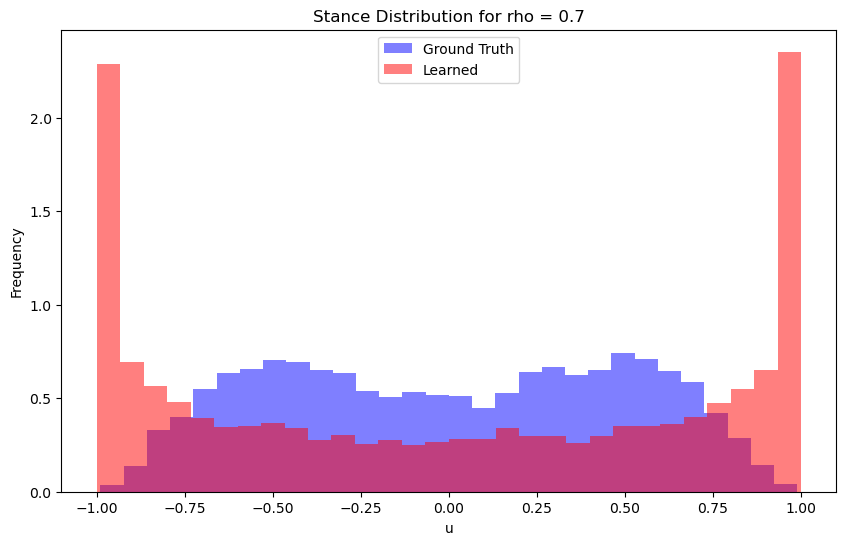

Testing Inference on Rho = 0.8
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 10000
Grid Size: 200
Learning Rate: 0.1
Improvement Threshold: 1e-05
Patience: 5
Initial Parameters:
Alpha: 0.21848678588867188
Beta: 2.0893282890319824
W: [-0.10363404452800751, -0.7200219631195068, 1.5359286069869995]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 200


  0%|          | 1/200 [00:00<00:43,  4.59it/s]

Epoch 1, NLL: 18.204, Alpha: 0.238, Beta: 1.938, W: [-0.500908374786377, -0.3632397949695587, 1.5764186382293701]
Epoch 2 of 200


  1%|          | 2/200 [00:00<00:41,  4.77it/s]

Epoch 2, NLL: 14.499, Alpha: 0.254, Beta: 1.852, W: [-0.876177966594696, 0.0052110906690359116, 1.5832358598709106]
Epoch 3 of 200


  2%|▏         | 3/200 [00:00<00:42,  4.65it/s]

Epoch 3, NLL: 12.462, Alpha: 0.27, Beta: 1.782, W: [-1.0513166189193726, 0.19620685279369354, 1.5673768520355225]
Epoch 4 of 200


  2%|▏         | 4/200 [00:01<01:00,  3.25it/s]

Epoch 4, NLL: 12.046, Alpha: 0.286, Beta: 1.719, W: [-1.1493693590164185, 0.32303860783576965, 1.5385957956314087]
Epoch 5 of 200


  2%|▎         | 5/200 [00:01<00:57,  3.38it/s]

Epoch 5, NLL: 11.904, Alpha: 0.302, Beta: 1.662, W: [-1.2133501768112183, 0.42555540800094604, 1.5000581741333008]
Epoch 6 of 200


  3%|▎         | 6/200 [00:01<00:55,  3.49it/s]

Epoch 6, NLL: 11.824, Alpha: 0.319, Beta: 1.612, W: [-1.2591150999069214, 0.5197156071662903, 1.4516615867614746]
Epoch 7 of 200


  4%|▎         | 7/200 [00:01<00:51,  3.73it/s]

Epoch 7, NLL: 11.756, Alpha: 0.336, Beta: 1.568, W: [-1.2938491106033325, 0.6151943206787109, 1.3909157514572144]
Epoch 8 of 200


  4%|▍         | 8/200 [00:02<01:01,  3.14it/s]

Epoch 8, NLL: 11.676, Alpha: 0.353, Beta: 1.529, W: [-1.3209673166275024, 0.7212375402450562, 1.311989426612854]
Epoch 9 of 200


  4%|▍         | 9/200 [00:02<00:57,  3.31it/s]

Epoch 9, NLL: 11.548, Alpha: 0.37, Beta: 1.497, W: [-1.3411697149276733, 0.8502989411354065, 1.2031285762786865]
Epoch 10 of 200


  5%|▌         | 10/200 [00:02<00:54,  3.48it/s]

Epoch 10, NLL: 11.278, Alpha: 0.386, Beta: 1.472, W: [-1.3514713048934937, 1.0169469118118286, 1.0467804670333862]
Epoch 11 of 200


  6%|▌         | 11/200 [00:03<00:51,  3.64it/s]

Epoch 11, NLL: 10.693, Alpha: 0.399, Beta: 1.458, W: [-1.3454967737197876, 1.215600848197937, 0.8421494364738464]
Epoch 12 of 200


  6%|▌         | 12/200 [00:03<01:02,  2.98it/s]

Epoch 12, NLL: 9.822, Alpha: 0.408, Beta: 1.452, W: [-1.3244131803512573, 1.3966728448867798, 0.6399915814399719]
Epoch 13 of 200


  6%|▋         | 13/200 [00:03<01:00,  3.07it/s]

Epoch 13, NLL: 9.129, Alpha: 0.414, Beta: 1.452, W: [-1.3027143478393555, 1.523491621017456, 0.4914732873439789]
Epoch 14 of 200


  7%|▋         | 14/200 [00:04<00:54,  3.43it/s]

Epoch 14, NLL: 8.799, Alpha: 0.42, Beta: 1.452, W: [-1.289688229560852, 1.6055783033370972, 0.39636027812957764]
Epoch 15 of 200


  8%|▊         | 15/200 [00:04<00:54,  3.37it/s]

Epoch 15, NLL: 8.671, Alpha: 0.426, Beta: 1.452, W: [-1.285467505455017, 1.6604198217391968, 0.33729761838912964]
Epoch 16 of 200


  8%|▊         | 16/200 [00:04<01:01,  3.00it/s]

Epoch 16, NLL: 8.623, Alpha: 0.432, Beta: 1.452, W: [-1.2874852418899536, 1.6991735696792603, 0.30056124925613403]
Epoch 17 of 200


  8%|▊         | 17/200 [00:05<00:58,  3.14it/s]

Epoch 17, NLL: 8.607, Alpha: 0.439, Beta: 1.452, W: [-1.2933471202850342, 1.7280956506729126, 0.2775009274482727]
Epoch 18 of 200


  9%|▉         | 18/200 [00:05<00:55,  3.30it/s]

Epoch 18, NLL: 8.601, Alpha: 0.445, Beta: 1.451, W: [-1.3013644218444824, 1.7507387399673462, 0.2628750503063202]
Epoch 19 of 200


 10%|▉         | 19/200 [00:05<00:51,  3.50it/s]

Epoch 19, NLL: 8.6, Alpha: 0.451, Beta: 1.451, W: [-1.3104569911956787, 1.7691993713378906, 0.25350698828697205]
Epoch 20 of 200


 10%|█         | 20/200 [00:05<00:51,  3.52it/s]

Epoch 20, NLL: 8.601, Alpha: 0.457, Beta: 1.45, W: [-1.3199676275253296, 1.7847647666931152, 0.24745221436023712]
Epoch 21 of 200


 10%|█         | 21/200 [00:06<01:01,  2.93it/s]

Epoch 21, NLL: 8.603, Alpha: 0.464, Beta: 1.449, W: [-1.329511046409607, 1.7982537746429443, 0.24350664019584656]
Epoch 22 of 200


 11%|█         | 22/200 [00:06<00:55,  3.23it/s]

Epoch 22, NLL: 8.605, Alpha: 0.47, Beta: 1.447, W: [-1.3388707637786865, 1.8102039098739624, 0.24091629683971405]
Epoch 23 of 200


 12%|█▏        | 23/200 [00:06<00:53,  3.33it/s]

Epoch 23, NLL: 8.607, Alpha: 0.476, Beta: 1.446, W: [-1.3479331731796265, 1.8209786415100098, 0.23920394480228424]
Epoch 24 of 200


 12%|█▏        | 23/200 [00:07<00:54,  3.23it/s]

Epoch 24, NLL: 8.609, Alpha: 0.482, Beta: 1.445, W: [-1.3566457033157349, 1.8308302164077759, 0.23806487023830414]
Early stopping triggered after 24 epochs.
Training Took 7.37 Seconds.
Trained Params: alpha: 0.4820077154464237, beta: 1.4449937471121825, W: [-1.3566457033157349, 1.8308302164077759, 0.23806487023830414]
Rho Estimate: 0.7498664506427356


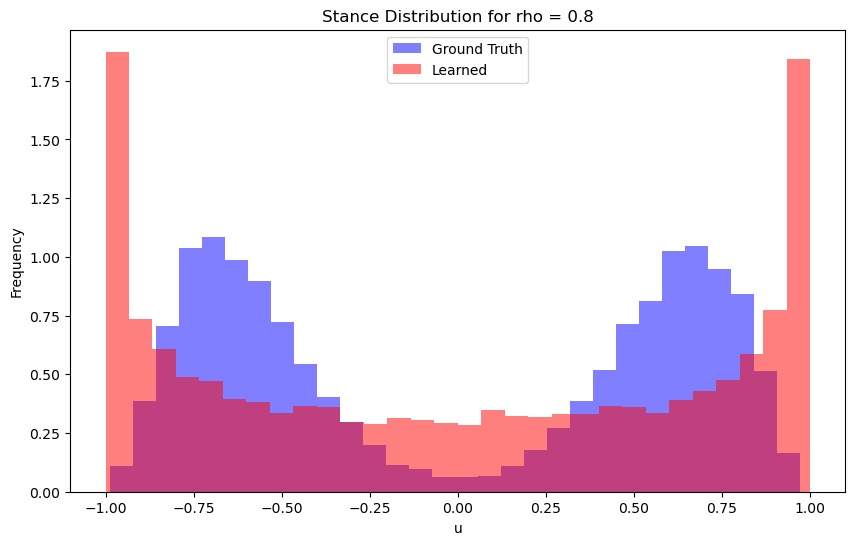

Testing Inference on Rho = 0.9
Beginning Inference...
Hyperparameters:
Dataset Length: 10000
Number Epochs: 200
Batch Size: 10000
Grid Size: 200
Learning Rate: 0.1
Improvement Threshold: 1e-05
Patience: 5
Initial Parameters:
Alpha: 0.837384045124054
Beta: 0.05983363091945648
W: [0.5973098278045654, 0.4133215546607971, 0.38019973039627075]


  0%|          | 1/200 [00:00<00:38,  5.12it/s]

Epoch 1 of 200
Epoch 1, NLL: 24.341, Alpha: 0.811, Beta: 0.065, W: [0.009906855411827564, 1.0670166015625, 0.3139054775238037]
Epoch 2 of 200


  1%|          | 2/200 [00:00<00:50,  3.88it/s]

Epoch 2, NLL: 12.615, Alpha: 0.807, Beta: 0.07, W: [-0.678114652633667, 1.6295875310897827, 0.4393578767776489]
Epoch 3 of 200


  2%|▏         | 3/200 [00:00<00:55,  3.58it/s]

Epoch 3, NLL: 7.449, Alpha: 0.802, Beta: 0.075, W: [-0.9117022752761841, 1.8433245420455933, 0.45920872688293457]
Epoch 4 of 200


  2%|▏         | 4/200 [00:01<01:12,  2.72it/s]

Epoch 4, NLL: 6.802, Alpha: 0.795, Beta: 0.08, W: [-1.0476330518722534, 1.973891258239746, 0.46457311511039734]
Epoch 5 of 200


  2%|▎         | 5/200 [00:01<01:05,  2.98it/s]

Epoch 5, NLL: 6.587, Alpha: 0.788, Beta: 0.086, W: [-1.1410465240478516, 2.0653719902038574, 0.46650567650794983]
Epoch 6 of 200


  3%|▎         | 6/200 [00:01<01:04,  3.01it/s]

Epoch 6, NLL: 6.486, Alpha: 0.78, Beta: 0.092, W: [-1.2108049392700195, 2.134312391281128, 0.46732407808303833]
Epoch 7 of 200


  4%|▎         | 7/200 [00:02<01:02,  3.11it/s]

Epoch 7, NLL: 6.428, Alpha: 0.773, Beta: 0.098, W: [-1.265621542930603, 2.188742160797119, 0.467710942029953]
Epoch 8 of 200


  4%|▍         | 8/200 [00:02<01:14,  2.59it/s]

Epoch 8, NLL: 6.39, Alpha: 0.765, Beta: 0.104, W: [-1.3102327585220337, 2.233154535293579, 0.46790990233421326]
Epoch 9 of 200


  4%|▍         | 9/200 [00:02<01:05,  2.90it/s]

Epoch 9, NLL: 6.361, Alpha: 0.757, Beta: 0.111, W: [-1.347495198249817, 2.2703073024749756, 0.4680197238922119]
Epoch 10 of 200


  5%|▌         | 10/200 [00:03<01:00,  3.16it/s]

Epoch 10, NLL: 6.338, Alpha: 0.749, Beta: 0.118, W: [-1.3792608976364136, 2.3020081520080566, 0.46808454394340515]
Epoch 11 of 200


  6%|▌         | 11/200 [00:03<00:55,  3.40it/s]

Epoch 11, NLL: 6.319, Alpha: 0.741, Beta: 0.125, W: [-1.4067950248718262, 2.3295018672943115, 0.4681251347064972]
Epoch 12 of 200


  6%|▋         | 13/200 [00:04<00:54,  3.43it/s]

Epoch 12, NLL: 6.302, Alpha: 0.733, Beta: 0.132, W: [-1.43099844455719, 2.3536782264709473, 0.4681521952152252]
Epoch 13 of 200
Epoch 13, NLL: 6.287, Alpha: 0.726, Beta: 0.14, W: [-1.4525325298309326, 2.3751933574676514, 0.46817129850387573]
Epoch 14 of 200


  8%|▊         | 15/200 [00:04<00:42,  4.31it/s]

Epoch 14, NLL: 6.274, Alpha: 0.719, Beta: 0.147, W: [-1.4718953371047974, 2.3945419788360596, 0.4681854844093323]
Epoch 15 of 200
Epoch 15, NLL: 6.263, Alpha: 0.712, Beta: 0.155, W: [-1.4894698858261108, 2.4121053218841553, 0.46819666028022766]
Epoch 16 of 200


  8%|▊         | 17/200 [00:05<00:45,  4.05it/s]

Epoch 16, NLL: 6.253, Alpha: 0.706, Beta: 0.163, W: [-1.5055550336837769, 2.4281814098358154, 0.4682057499885559]
Epoch 17 of 200
Epoch 17, NLL: 6.244, Alpha: 0.7, Beta: 0.17, W: [-1.5203876495361328, 2.4430062770843506, 0.4682135283946991]
Epoch 18 of 200


 10%|▉         | 19/200 [00:05<00:38,  4.74it/s]

Epoch 18, NLL: 6.237, Alpha: 0.694, Beta: 0.178, W: [-1.534157633781433, 2.4567694664001465, 0.46822023391723633]
Epoch 19 of 200
Epoch 19, NLL: 6.231, Alpha: 0.689, Beta: 0.186, W: [-1.5470181703567505, 2.4696240425109863, 0.4682263135910034]
Epoch 20 of 200


 10%|█         | 20/200 [00:05<00:50,  3.53it/s]

Epoch 20, NLL: 6.226, Alpha: 0.683, Beta: 0.194, W: [-1.5590941905975342, 2.481694459915161, 0.46823200583457947]
Epoch 21 of 200


 11%|█         | 22/200 [00:06<00:43,  4.12it/s]

Epoch 21, NLL: 6.222, Alpha: 0.678, Beta: 0.202, W: [-1.5704880952835083, 2.4930832386016846, 0.4682372510433197]
Epoch 22 of 200
Epoch 22, NLL: 6.218, Alpha: 0.673, Beta: 0.209, W: [-1.581284523010254, 2.5038747787475586, 0.46824219822883606]
Epoch 23 of 200


 12%|█▏        | 23/200 [00:06<00:40,  4.37it/s]

Epoch 23, NLL: 6.216, Alpha: 0.669, Beta: 0.217, W: [-1.5915533304214478, 2.51413893699646, 0.4682469666004181]
Epoch 24 of 200


 12%|█▎        | 25/200 [00:06<00:43,  4.06it/s]

Epoch 24, NLL: 6.214, Alpha: 0.665, Beta: 0.225, W: [-1.6013529300689697, 2.5239338874816895, 0.4682515859603882]
Epoch 25 of 200
Epoch 25, NLL: 6.213, Alpha: 0.661, Beta: 0.232, W: [-1.610731840133667, 2.533308267593384, 0.46825599670410156]
Epoch 26 of 200


 14%|█▎        | 27/200 [00:07<00:36,  4.71it/s]

Epoch 26, NLL: 6.212, Alpha: 0.657, Beta: 0.24, W: [-1.619731068611145, 2.5423033237457275, 0.4682602882385254]
Epoch 27 of 200
Epoch 27, NLL: 6.212, Alpha: 0.653, Beta: 0.247, W: [-1.628385066986084, 2.5509531497955322, 0.46826452016830444]
Epoch 28 of 200


 14%|█▍        | 29/200 [00:07<00:41,  4.09it/s]

Epoch 28, NLL: 6.212, Alpha: 0.65, Beta: 0.254, W: [-1.6367230415344238, 2.5592870712280273, 0.46826863288879395]
Epoch 29 of 200
Epoch 29, NLL: 6.213, Alpha: 0.646, Beta: 0.261, W: [-1.6447699069976807, 2.5673298835754395, 0.46827277541160583]
Epoch 30 of 200


 16%|█▌        | 31/200 [00:08<00:34,  4.84it/s]

Epoch 30, NLL: 6.214, Alpha: 0.643, Beta: 0.268, W: [-1.6525466442108154, 2.5751025676727295, 0.4682767987251282]
Epoch 31 of 200
Epoch 31, NLL: 6.215, Alpha: 0.643, Beta: 0.269, W: [-1.65329909324646, 2.575854778289795, 0.4682771861553192]
Epoch 32 of 200


 16%|█▌        | 31/200 [00:08<00:47,  3.56it/s]

Epoch 32, NLL: 6.215, Alpha: 0.643, Beta: 0.269, W: [-1.6540491580963135, 2.5766043663024902, 0.46827757358551025]
Early stopping triggered after 32 epochs.
Training Took 8.94 Seconds.
Trained Params: alpha: 0.6425886914424807, beta: 0.26939451022903677, W: [-1.6540491580963135, 2.5766043663024902, 0.46827757358551025]
Rho Estimate: 0.7046058417136628


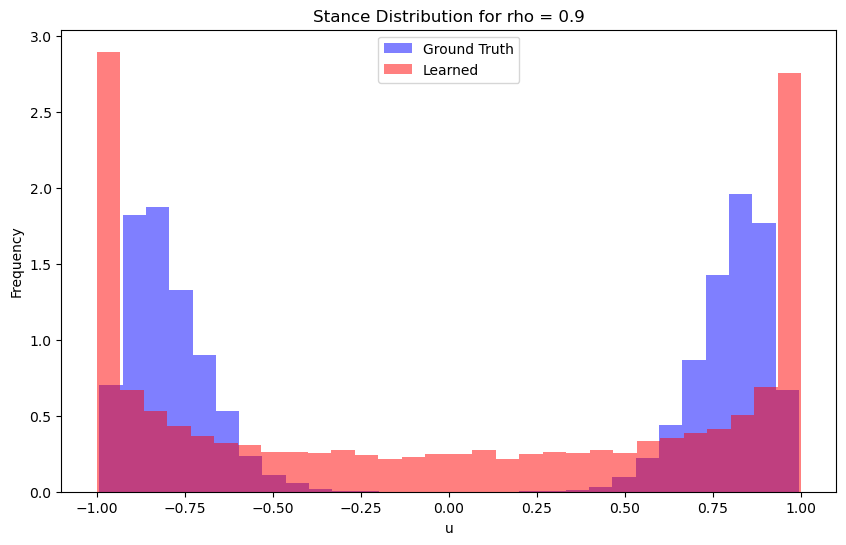

In [27]:
for rho in [0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f'=' * 20)
    print(f'Testing Inference on Rho = {rho}')
    known, unknown = generate(N=10000, rho=rho, verbose=False)
    X, y = known
    a, b, rho, epsilon, u = unknown

    trained_a, trained_b, trained_W = train(X, y, batch_size = 10000, verbose=True)
    print(f'Rho Estimate: {(max(trained_a, trained_b))/(trained_a + trained_b)}')

    samples = np.concatenate([
        stats.beta.rvs(trained_a, trained_b, size=5000), 
        stats.beta.rvs(trained_b, trained_a, size=5000)
    ]) * 2 - 1
    plt.figure(figsize=(10, 6))
    plt.hist(u, bins=50, density=True, alpha=0.5, color='blue', label='Ground Truth')
    plt.hist(samples, bins=50, density=True, alpha=0.5, color='red', label='Learned')
    plt.title(f'Stance Distribution for rho = {rho}')
    plt.xlabel('u')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Testing

Here I test if analytical solutions match what's expected.

### Prior:

We have that 
$$
\begin{align*}
p(u;\theta) &= \frac{1}{4}\left(\mathrm{Beta}\left(\frac{u+1}{2}; \alpha, \beta\right) +\mathrm{Beta}\left(\frac{u+1}{2}; \beta, \alpha \right)\right) \\
    &= \frac{1}{4}\left(\frac{\left(\frac{u+1}{2}\right)^{(\alpha-1)}\left(\frac{1-u}{2}\right)^{(\beta-1)}}{B(\alpha,\beta)} + \frac{\left(\frac{u+1}{2}\right)^{(\beta-1)}\left(\frac{1-u}{2}\right)^{(\alpha-1)}}{B(\beta,\alpha)}\right) \\
    &= \left(\frac{1}{2}\right)^{\alpha + \beta}\frac{1}{B(\alpha, \beta)}\left((u+1)^{\alpha-1}(1-u)^{\beta-1} + (u+1)^{\beta-1}(1-u)^{\alpha-1}\right).
\end{align*}
$$
Here, $B(\alpha, \beta)$ is the Beta function, and we use the fact that it's symmetric with respect to its arguments. Further, we'll use that 
$$
B(\alpha, \beta) = \frac{\Gamma(\alpha)\cdot\Gamma(\beta)}{\Gamma(\alpha + \beta)},
$$
where $\Gamma(x)$ is the gamma function, which namely satisfies $\Gamma(n) = (n-1)!$. For example, when $\alpha=3, \beta=2$, after a bit of algebra we get that 
$$
    p(u;\theta) = \frac{3}{4}(1-u^2).
$$
Let's verify our code gets this! 

In [8]:
def compute_log_prior(u_mat, log_alpha, log_beta):
    ### log prior: log p(u) = log(1/4 Beta((u+1)/2; a, b) + 1/4 Beta((u+1)/2; b, a))
    ###                     = log(1/4) + log(Beta((u+1)/2; a, b) + Beta((u+1)/2; b, a))
    alpha = torch.exp(log_alpha)
    beta  = torch.exp(log_beta)

    beta_dist_ab = Beta(alpha, beta)
    beta_dist_ba = Beta(beta, alpha)

    ### see 3-6 testing.ipynb test1 to see how log_prob broadcasts
    log_beta_prob_ab = beta_dist_ab.log_prob((u_mat + 1) / 2)
    log_beta_prob_ba = beta_dist_ba.log_prob((u_mat + 1) / 2)

    prior = torch.log(torch.exp(log_beta_prob_ab) + torch.exp(log_beta_prob_ba)) + torch.log(torch.tensor(0.25))
    return prior

def test_prior():
    u_mat = torch.tensor(
        [[0.5, 0.75, -0.9],
            [-0.5, 0.6, -.9]])
    
    log_alpha = torch.log(torch.tensor(3.))
    log_beta  = torch.log(torch.tensor(2.))

    assert torch.all(torch.abs(torch.exp(compute_log_prior(u_mat, log_alpha, log_beta))) - 3/4 * (1-u_mat**2) <= 10e-5)

    ### symmmetric w.r.t alpha/beta
    log_alpha = torch.log(torch.tensor(2.))
    log_beta  = torch.log(torch.tensor(3.))

    assert torch.all(torch.abs(torch.exp(compute_log_prior(u_mat, log_alpha, log_beta))) - 3/4 * (1-u_mat**2) <= 10e-5)
    
test_prior()
        

### Likelihood:

We have that 
$$
p(x, y |u) = 1\left(1(u\ge0)=y^{(n)}\right)\frac{S!}{x^{(n)}_1!x^{(n)}_2!x^{(n)}_3!}\prod_{s=1}^{S}\mathrm{softmax}(Wu)_{x^{(n)}_s}.
$$

We will work with the following example:
$$
\begin{align*}
    \mathrm{u_{mat}} &= \begin{bmatrix}
    0.2 & 0.7 \\
    -0.8 & -0.4
    \end{bmatrix} \\
    \mathrm{y_{batch}} &= [1, 0]^T \\
    \mathrm{x_{batch}} &= \begin{bmatrix}
    4 & 2 & 1\\
    1 & 5 & 1
    \end{bmatrix} \\
    W &= [2.1, -0.7, 0.3]^T
\end{align*} 
$$
For example, for the first row of $x$ we get that 
$$
\begin{align*}
    p(x[0], y | u) &= \frac{7!}{4!2!} \frac{e^{(2.1\cdot 4)u} \cdot e^{(-0.7\cdot 2)u} \cdot e^{(0.3 \cdot 1)u}}{(e^{2.1u} + e^{-0.7u} + e^{0.3u})^7} \\
    &= \frac{105e^{7.3u}}{(e^{2.1u} + e^{-0.7u} + e^{0.3u})^7}.
\end{align*}
$$

Analogous work tells us we get
$$
p(x[1], y | u ) = \frac{42e^{-1.1u}}{(e^{2.1u} + e^{-0.7u} + e^{0.3u})^7}.
$$

In [9]:
def compute_log_likelihood(u_mat, x_batch, y_batch, W):
    if not torch.all((u_mat >= 0).float() == y_batch.unsqueeze(1)).item():
        raise ValueError(f"u_mat is incompatible with y_batch.")

    ### likelihood: p(x, y | u) = frac{S!}{x1! x2! x3!} prod_{s=1}^{S} softmax(Wu)_{x_s}
   
    ### step 1: compute Wu (see 3-6 testing.ipynb test2 to see this logic)
    W_expanded = W.unsqueeze(0).unsqueeze(0)
    u_expanded = u_mat.unsqueeze(2)
    Wu = torch.matmul(u_expanded, W_expanded) 

    ### step 2: dot(x, log Softmax(Wu)) (see 3-6 testing.ipynb test3 to see this logic)
    log_likelihood = (x_batch.unsqueeze(1) * log_softmax(Wu, dim=2)).sum(dim=2)

    ### ensure not taking negative factorials
    assert torch.all(x_batch >= 0)

    ### step 3: multinomial constant factors (see 3-6 testing.ipynb test4)
    log_likelihood += torch.log(factorial(torch.tensor(x_batch.sum(dim=1)[0].item())))
    log_likelihood -= torch.log(factorial(x_batch)).sum(dim=1, keepdim=True) 

    return log_likelihood

def test_likelihood():
    u_mat = torch.tensor(
        [[.2, 0.7],
        [-.8, -.4]]
    )
    x = torch.tensor(
        [[4., 2., 1.],
        [1., 5., 1.]]
    )
    W = torch.tensor([2.1, -.7, .3])
    y = torch.tensor([1., 0.])

    print(torch.exp(compute_log_likelihood(u_mat, x, y, W)))
    print((105 * torch.exp(7.3 * u_mat) / (torch.exp(2.1 * u_mat) + torch.exp(-.7*u_mat) + torch.exp(0.3*u_mat))**7)[0])
    print((42 * torch.exp(-1.1 * u_mat) / (torch.exp(2.1 * u_mat) + torch.exp(-.7*u_mat) + torch.exp(0.3*u_mat))**7)[1])
    
test_likelihood()


tensor([[0.0772, 0.0496],
        [0.0911, 0.0726]])
tensor([0.0772, 0.0496])
tensor([0.0911, 0.0726])


### Negative Log Likelihood

We now wish to see if the NLL computation is correct. This computation involves two core steps:
1. Does the code function properly?
2. Is discretizing the posterior effective? If so, for what grid size is the discretized version.


**Step 1**
We'll use our work from above, where we have 
$$

\begin{align*}\
    \mathrm{y_{batch}} &= [1, 0]^T \\
    \mathrm{x_{batch}} &= \begin{bmatrix}
    4 & 2 & 1\\
    1 & 5 & 1
    \end{bmatrix} \\
    W &= [2.1, -0.7, 0.3]^T \\
    \alpha &= 3, \beta = 2,
\end{align*} 
$$
with the goal being computing the gradient of the negative log likelihood of this batch. For now, we'll assume a small grid size, specifically $G=9$, which gives
$$
\mathrm{u_{mat}} = \begin{bmatrix}
.1 & .2 & .3 & .4 & .5 & .6 & .7 &.8 & .9 \\
-.9 & -.8 & -.7 & -.6 & -.5 & -.4 & -.3 & -.2 & -.1
\end{bmatrix}
$$
Again, we could have the discrete $u$ values being $[-.9, -.8, \dots, .8, .9]$ for each $(x,y)$ pair, but it's redundant since the value of $y$ is hard constraint that half of the values will necessarily be $0$ (if $y = 0$ the probability that $u$ is $.7$ is $0$). Recall the definition of the gradient of the NLL is given by 
$$
\nabla_\theta \log p(x^{(1:N)},y^{(1:N)}) = \sum_{n=1}^{N} \sum_{u} \frac{p(x^{(n)}, y^{(n)}, u;\ \theta)}{p(x^{(n)},y^{(n)};\  \theta)}\nabla_\theta \log p(u,x^{(n)},y^{(n)};\theta).
$$
Here $N=2$, so let's treat each of the sums differently. Consider the term $1$ sum ($\nabla_\theta \log p(x^{(1)},y^{(1)})$). From work above, we have
$$
\begin{align*}
    p(x^{(1)}, y^{(1)}, u; \theta) &= \frac{3}{4}(1-u^2)\frac{105e^{7.3u}}{(e^{2.1u} + e^{-.7u} + e^{.3u})^7} \\
    p(x^{(1)}, y^{(1)}; \theta) &= \sum_{g=1}^{9}p(x^{(1)}, y^{(1)}, g/10;\theta).
\end{align*}
$$
Similarly, for the term $2$ sum ($\nabla_\theta \log p(x^{(2)},y^{(2)})$) we get 
$$
\begin{align*}
    p(x^{(2)}, y^{(2)}, u; \theta) &= \frac{3}{4}(1-u^2)\frac{42e^{-1.1u}}{(e^{2.1u} + e^{-.7u} + e^{.3u})^7} \\
    p(x^{(2)}, y^{(2)}; \theta) &= \sum_{g=1}^{9}p(x^{(1)}, y^{(1)}, -g/10;\theta).
\end{align*}
$$
We now need to compute the gradient of the log joint w.r.t to the parameters. Using standard methods, we get
$$
\begin{align*}
\nabla_{\alpha} \log p(x, y, u; \theta) &= -\log 2 + \psi(\alpha + \beta) - \psi(\alpha) + \frac{(1-u)^{\beta}(1+u)^\alpha \log(u+1) + \log(1-u)(1-u)^\alpha (1+u)^{\beta}}{(1-u)^\beta (1+u)^\alpha + (1-u)^{\alpha} (1+u)^{\beta}} \\ 
\nabla_{\beta} \log p(x, y, u; \theta) &= -\log 2 + \psi(\alpha + \beta) - \psi(\beta) + \frac{(1+u)^{\beta}(1-u)^\alpha \log(u+1) + \log(1-u)(1+u)^\alpha (1-u)^{\beta}}{(1-u)^\beta (1+u)^\alpha + (1-u)^{\alpha} (1+u)^{\beta}} \\ 
\nabla_{w_i} \log p(x,y,u; \theta) &= u \left(x_i - \frac{Se^{w_i u}}{e^{w_1u} + e^{w_2u} + e^{w_3u}} \right).
\end{align*}
$$

In [53]:
def compute_log_jointT(u_mat, x_batch, y_batch, W, log_alpha, log_beta):
    log_prior = compute_log_prior(u_mat, log_alpha, log_beta)
    log_likelihood = compute_log_likelihood(u_mat, x_batch, y_batch, W)

    return log_prior + log_likelihood

def test_disrete_expectation():
    x_batch = torch.tensor(
        [[4., 2., 1.],
        [1., 5., 1.]]
    )
    WT= torch.tensor([2.1, -.7, .3], requires_grad=True)
    alphaT = torch.tensor(3., requires_grad=True)
    betaT = torch.tensor(2., requires_grad=True)
    y_batch = torch.tensor([1., 0.])
    log_alpha = torch.log(alphaT)
    log_beta = torch.log(betaT)

    nll = compute_nll(x_batch, y_batch, log_alpha, log_beta, WT, grid_size=9, batch_size=2, speech_len=7)
    nll.backward()
    print('=' * 20)
    print(f'Alpha Grad: {alphaT.grad}')
    print(f'Beta Grad: {betaT.grad}')
    print(f'W Grad: {WT.grad}')
    print('=' * 20)
    print(f'Computed NLL: {nll}')
    print(f"=" * 20)


    alpha = 3
    beta = 2
    W = [2.1, -.7, .3]
    x1 = [4, 2, 1]
    x2 = [1, 5, 1]

    def get_joint1(u):
        return 3/4 * (1-u**2) * 105 * np.exp(u*7.3)/ ((np.exp(u*2.1) + np.exp(-.7*u) + np.exp(.3 *u))**7)
    
    def get_joint2(u):
        return 3/4 * (1-u**2) * 42 * np.exp(u*-1.1)/ ((np.exp(u*2.1) + np.exp(-.7*u) + np.exp(.3 *u))**7)
    
    def get_marginal1():
        return sum(get_joint1(g/10) for g in range(1, 10))
    
    def get_marginal2():
        return sum(get_joint2(-g/10) for g in range(1, 10))

    def get_alpha_grad(u, alpha, beta):
        return -np.log(2) + digamma(alpha + beta) - digamma(alpha) + ((1-u)**beta * (1+u)**alpha * np.log(u+1) + np.log(1-u)*(1-u)**alpha *(1+u)**beta)/((1-u)**beta * (1+u)**alpha + (1-u)**alpha * (1+u)**beta)
    
    def get_beta_grad(u, alpha, beta):
         return -np.log(2) + digamma(alpha + beta) - digamma(beta) + ((1+u)**beta * (1-u)**alpha * np.log(u+1) + np.log(1-u)*(1+u)**alpha *(1-u)**beta)/((1-u)**beta * (1+u)**alpha + (1-u)**alpha * (1+u)**beta)

    def get_w_grad(i, S, u, x, W):
        return u * (x[i] - S * np.exp(W[i] * u)/ (np.exp(W[0] *u) + np.exp(W[1]*u) + np.exp(W[2]*u)))
    
    def manual_nll(W, x1, x2, alpha, beta):

        alpha_term1 = 1/get_marginal1() * sum(get_joint1(g/10) * get_alpha_grad(g/10, alpha, beta) for g in range(1,10))
        alpha_term2 = 1/get_marginal2() * sum(get_joint2(-g/10) * get_alpha_grad(-g/10, alpha, beta) for g in range(1,10))
        print(f'Manual Alpha Grad: {-(alpha_term1 + alpha_term2)}')

        beta_term1 = 1/get_marginal1() * sum(get_joint1(g/10) * get_beta_grad(g/10, alpha, beta) for g in range(1, 10))
        beta_term2 = 1/get_marginal2() * sum(get_joint2(-g/10) * get_beta_grad(-g/10, alpha, beta) for g in range(1, 10))
        print(f'Manual Beta Grad: {-(beta_term1 + beta_term2)}')
    
        for i in range(3):
            w_term1 = 1/get_marginal1() * sum(get_joint1(g/10) * get_w_grad(i, 7, g/10, x1, W) for g in range(1, 10))
            w_term2 = 1/get_marginal2() * sum(get_joint2(-g/10) * get_w_grad(i, 7, -g/10, x2, W) for g in range(1, 10))
            print(f'Manual W{i} Grad: {-(w_term1 + w_term2)}')
    
    manual_nll(W, x1, x2, alpha, beta)
    
test_disrete_expectation()

Alpha Grad: -0.025591015815734863
Beta Grad: 0.07093220949172974
W Grad: tensor([ 0.1124,  0.1838, -0.2962])
Computed NLL: 6.478436470031738
Manual Alpha Grad: -0.025590606092335627
Manual Beta Grad: 0.07093241931938907
Manual W0 Grad: 0.11240171211042926
Manual W1 Grad: 0.18376414373868977
Manual W2 Grad: -0.2961658558491188


### Visualization

Here we look at things like the joint, posterior, etc.

In [101]:
batch_size = 1
grid_size = 300

y_batch = torch.tensor([1.])
u_mat = torch.empty(batch_size, grid_size)
u_mat[y_batch == 1] = torch.linspace(1/(grid_size+1), 1-1/(grid_size+1), grid_size).repeat((y_batch == 1).sum(), 1)
u_mat[y_batch == 0] = torch.linspace(-1+1/(grid_size+1), -1/(grid_size+1), grid_size).repeat((y_batch == 0).sum(), 1)
x_batch = torch.tensor([[11.,2., 2.]])
alpha = torch.tensor(3.)
log_alpha = torch.log(alpha)

beta = torch.tensor(2.)
log_beta = torch.log(beta)
W = torch.tensor([2.1, -.7, -0.3])
speech_len = 15

log_joint = compute_log_joint(u_mat, x_batch, y_batch, log_alpha, log_beta, W, grid_size, batch_size, speech_len)
max_log_prob = torch.max(log_joint, dim=1, keepdim=True)[0]
joint_probs = torch.exp(log_joint - max_log_prob)
posterior = joint_probs / joint_probs.sum(dim=1, keepdim=True) 

torch.Size([1, 300])
tensor([[8.3677e-05, 8.8092e-05, 9.2714e-05, 9.7551e-05, 1.0261e-04, 1.0791e-04,
         1.1344e-04, 1.1923e-04, 1.2527e-04, 1.3159e-04, 1.3818e-04, 1.4507e-04,
         1.5225e-04, 1.5975e-04, 1.6756e-04, 1.7571e-04, 1.8420e-04, 1.9305e-04,
         2.0226e-04, 2.1186e-04, 2.2184e-04, 2.3223e-04, 2.4303e-04, 2.5427e-04,
         2.6594e-04, 2.7807e-04, 2.9067e-04, 3.0375e-04, 3.1733e-04, 3.3142e-04,
         3.4603e-04, 3.6118e-04, 3.7689e-04, 3.9316e-04, 4.1001e-04, 4.2745e-04,
         4.4551e-04, 4.6419e-04, 4.8352e-04, 5.0350e-04, 5.2414e-04, 5.4547e-04,
         5.6750e-04, 5.9025e-04, 6.1372e-04, 6.3793e-04, 6.6290e-04, 6.8864e-04,
         7.1517e-04, 7.4249e-04, 7.7062e-04, 7.9958e-04, 8.2938e-04, 8.6003e-04,
         8.9154e-04, 9.2392e-04, 9.5720e-04, 9.9136e-04, 1.0264e-03, 1.0624e-03,
         1.0994e-03, 1.1372e-03, 1.1760e-03, 1.2158e-03, 1.2565e-03, 1.2982e-03,
         1.3408e-03, 1.3844e-03, 1.4291e-03, 1.4747e-03, 1.5212e-03, 1.5688e-03,
       

/tmp/ipykernel_3648353/3025568259.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=u_mat.tolist()[0], y=posterior.tolist()[0], palette="viridis")


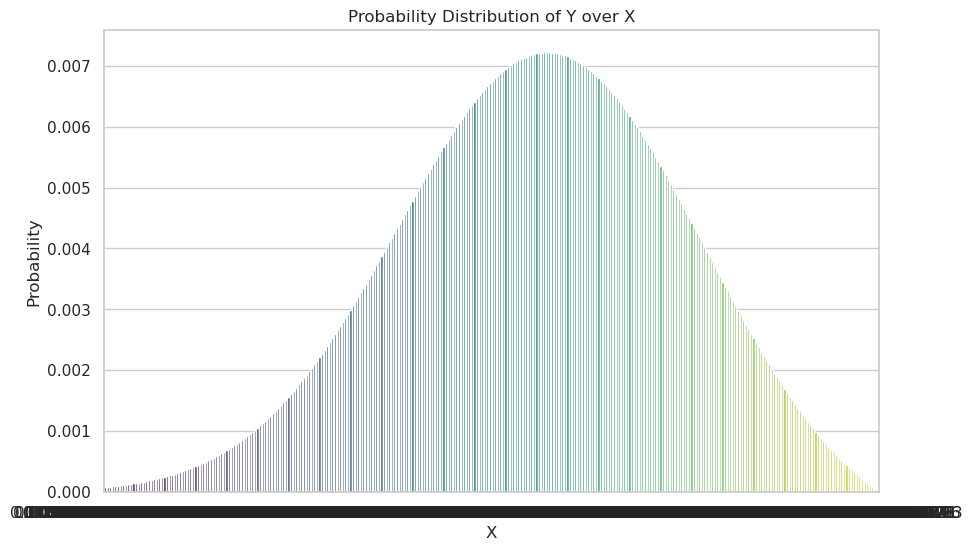

In [102]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=u_mat.tolist()[0], y=posterior.tolist()[0], palette="viridis")

plt.title('Probability Distribution of Y over X')
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()